# 코드잇 스프린트 고급 프로젝트 분석 코드
## 1팀: 이상한 마을의 데이터분석가(팀장: 정혜라 / 팀원: 강민혁, 고아윤, 홍성준)

## 활용 라이브러리

In [ ]:
"""데이터 불러오기 및 전처리"""
import re
import os
import ast
import glob
import pandas as pd
import numpy as np
import warnings
from urllib.parse import quote_plus
from sqlalchemy import create_engine
from dotenv import load_dotenv

"""EDA 및 AARRR분석, 시각화"""
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import datetime as dt
import seaborn as sns

"""검정 관련 라이브러리"""
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats

"""크롤링 라이브러리"""
from app_store_scraper import AppStore
from google_play_scraper import reviews, Sort
import time

"""이탈요인 분석 및 마케팅 효과 예측"""
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import shap
from imblearn.over_sampling import SMOTE
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import StratifiedKFold

"""활동지수 추출"""
from sklearn.preprocessing import MinMaxScaler

""" 기타 """
from pprint import pprint
import random

## 1. 데이터 불러오기

### SQLdump -> csv

In [ ]:
from urllib.parse import quote_plus
from sqlalchemy import create_engine, inspect
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

# DB 연결 설정
DB_USER = os.getenv('DB_USER', 'root')
DB_PASSWORD = quote_plus(os.getenv('DB_PASSWORD', ''))
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_NAME = os.getenv('DB_NAME', 'hackle')

engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"
)

def get_all_tables():
    """데이터베이스의 모든 테이블 목록을 반환"""
    inspector = inspect(engine)
    return inspector.get_table_names()

def export_table_to_csv(table_name):
    """특정 테이블의 데이터를 CSV 파일로 저장"""
    try:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(query, engine)

        # CSV 파일 저장
        os.makedirs('data', exist_ok=True)
        file_path = f'data/{table_name}.csv'
        df.to_csv(file_path, index=False, encoding='utf-8-sig')
        print(f"'{table_name}' 테이블이 '{file_path}'에 저장되었습니다.")

        return True
    except Exception as e:
        print(f"'{table_name}' 테이블 저장 중 오류 발생: {str(e)}")
        return False

def export_all_tables():
    """모든 테이블을 CSV 파일로 저장"""
    tables = get_all_tables()
    success_count = 0

    print(f"총 {len(tables)}개의 테이블을 내보내기 시작합니다...")

    for table in tables:
        if export_table_to_csv(table):
            success_count += 1

    print(f"\n작업 완료: {success_count}/{len(tables)} 테이블 저장됨")

export_all_tables()

In [ ]:
# vote
vote_path = './data/votes'

csv_files = [f for f in os.listdir(vote_path) if f.endswith('.csv')]

for file in csv_files:
    var_name = file.replace('.csv', '')

    globals()[var_name] = pd.read_csv(os.path.join(vote_path, file), encoding='utf-8-sig')

# hackle
hackle_path = './data/hackle'

csv_files = [f for f in os.listdir(hackle_path) if f.endswith('.csv')]

for file in csv_files:
    var_name = file.replace('.csv', '')

    globals()[var_name] = pd.read_csv(os.path.join(hackle_path, file), encoding='utf-8-sig')

# vote table
v_acc_atd = accounts_attendance
v_acc_bcrec = accounts_blockrecord
v_acc_failpay = accounts_failpaymenthistory
v_acc_frdreq = accounts_friendrequest
v_acc_grp = accounts_group
v_acc_nbs = accounts_nearbyschool
v_acc_pay = accounts_paymenthistory
v_acc_point = accounts_pointhistory
v_acc_sch = accounts_school
v_acc_trep = accounts_timelinereport
v_acc_user = accounts_user
v_acc_uqrec = accounts_userquestionrecord
v_acc_uwd = accounts_userwithdraw
v_acc_ucon = accounts_user_contacts
v_evt = events
v_evt_rcp = event_receipts
v_pol_q = polls_question
v_pol_qp = polls_questionpiece
v_pol_qrep = polls_questionreport
v_pol_qset = polls_questionset
v_pol_uc = polls_usercandidate

# hackle table
h_dev_ppt = device_properties
h_evt = hackle_events
h_prop = hackle_properties
h_user_prop = user_properties

## 2. 데이터 전처리

### 전처리 함수 모음

In [ ]:
"""
hackle_properties 데이터프레임에서 결측치를 제거하는 함수

사용예시 :
from ppc_properties import process_properties
h_prop = process_properties(h_prop)
"""
def process_properties(h_prop):
    h_prop = h_prop.dropna()

    return h_prop

"""
시도, 시군, 그외를 대분류, 중분류, 소분류로 구분했습니다.
대분류와 중분류만 존재하는 곳도 있고, 전체가 있는 곳도 있어서
3분류로 나눈 다음에 각각에 맞게 들어가게했습니다.
그 과정에서 대분류에는 몇몇 예외사항들이 있어 예외처리 포함했습니다.

사용예시 :
from ppc_address import process_school_address
v_acc_sch = process_school_address(v_acc_sch)
"""

import pandas as pd
import numpy as np

def process_school_address(v_acc_sch):
    region_mapping = {
        '전북': '전라북도', '인천': '인천광역시', '서울': '서울특별시',
        '대구': '대구광역시', '경북': '경상북도', '경남': '경상남도',
        '경기': '경기도', '강원': '강원도', '충남': '충청남도',
        '제주': '제주특별자치도',
    }

    middle_region_mapping = {
        '서울특별시': ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구',
                  '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구',
                  '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'],

        '경기도': ['수원시', '성남시', '용인시', '안양시', '안산시', '과천시', '광명시', '광주시',
               '군포시', '부천시', '시흥시', '김포시', '안성시', '오산시', '의왕시', '이천시', '평택시',
               '하남시', '화성시', '여주시', '양평군', '고양시', '구리시', '남양주시', '동두천시',
               '양주시', '의정부시', '파주시', '포천시', '연천군', '가평군'],

        '인천광역시': ['강화군', '옹진군', '중구', '동구', '미추홀구', '연수구', '남동구', '부평구', '계양구', '서구'],

        '강원도': ['춘천시', '원주시', '강릉시', '동해시', '태백시', '속초시', '삼척시', '홍천군', '횡성군',
               '영월군', '평창군', '정선군', '철원군', '화천군', '양구군', '인제군', '고성군', '양양군'],

        '충청북도': ['청주시', '충주시', '제천시', '보은군', '옥천군', '영동군', '증평군', '진천군',
                '괴산군', '음성군', '단양군'],

        '충청남도': ['천안시', '공주시', '보령시', '아산시', '서산시', '논산시', '계롱시', '당진시',
                '금산군', '부여군', '서천군', '청양군', '홍성군', '예산군', '태안군', '세종특별자치시'],

        '전라북도': ['전주시', '익산시', '군산시', '정읍시', '김제시', '남원시', '완주군', '고창군',
                '부안군', '임실군', '순창군', '진안군', '무주군', '장수군'],

        '전라남도': ['목포시', '여수시', '순천시', '나주시', '광양시', '담양군', '곡성군', '구례군',
                '고흥군', '보성군', '화순군', '장흥군', '강진군', '해남군', '영암군', '무안군',
                '함평군', '영광군', '장성군', '완도군', '진도군', '신안군'],

        '광주광역시': ['동구', '서구', '남구', '북구', '광산구'],

        '대구광역시': ['중구', '동구', '서구', '남구', '북구', '수성구', '달서구', '달성군', '군위군'],

        '대전광역시': ['동구', '중구', '서구', '유성구', '대덕구'],

        '울산광역시': ['중구', '남구', '동구', '북구', '울주군'],

        '경상북도': ['포항시', '경주시', '김천시', '안동시', '구미시', '영주시', '영천시', '상주시',
                '문경시', '경산시', '의성군', '청송군', '영양군', '영덕군', '청도군', '고령군',
                '성주군', '칠곡군', '예천군', '봉화군', '울진군', '울릉군'],

        '경상남도': ['창원시', '김해시', '진주시', '양산시', '거제시', '통영시', '사천시', '밀양시',
                '함안군', '거창군', '창녕군', '고성군', '하동군', '합천군', '남해군', '함양군',
                '산청군', '의령군'],

        '부산광역시': ['중구', '서구', '동구', '영도구', '부산진구', '동래구', '남구', '북구',
                 '해운대구', '사하구', '금정구', '강서구', '연제구', '수영구', '사상구', '기장군'],

        '제주특별자치도': ['제주시', '서귀포시']
    }

    def split_address(address):
        if address == '-' or pd.isna(address):
            return pd.Series([np.nan, np.nan, np.nan])

        parts = address.strip().split()

        if parts[0] == '대한민국':
            parts = parts[1:]

        if not parts:
            return pd.Series([np.nan, np.nan, np.nan])

        # 대분류 처리
        large_region = parts[0]
        for short, full in region_mapping.items():
            if large_region == short:
                large_region = full

        if large_region not in middle_region_mapping.keys():
            return pd.Series([np.nan, np.nan, np.nan])

        # 중분류와 소분류 처리
        middle_region = np.nan
        small_region = np.nan

        if len(parts) > 1:
            # 중분류 확인
            for region in middle_region_mapping.get(large_region, []):
                if parts[1].startswith(region):
                    middle_region = region
                    remaining_parts = parts[2:]
                    if remaining_parts:
                        small_region = ' '.join(remaining_parts)
                    break

            # 중분류를 찾지 못한 경우
            if pd.isna(middle_region):
                small_region = ' '.join(parts[1:])

        return pd.Series([large_region, middle_region, small_region])

    # 주소 분리 적용
    v_acc_sch[['지역_대분류', '지역_중분류', '지역_소분류']] = v_acc_sch['address'].apply(split_address)

    # 컬럼 순서 정리
    columns_order = ['id', 'address', 'student_count', 'school_type', '지역_대분류', '지역_중분류', '지역_소분류']
    v_acc_sch = v_acc_sch[columns_order]
    v_acc_sch = v_acc_sch.dropna(subset=['지역_대분류', '지역_중분류', '지역_소분류'], how='all')

    return v_acc_sch

"""
출석 데이터프레임의 attendance_date_list를 처리하는 함수

사용예시 :
from ppc_attendance import process_attendance
v_acc_atd = process_attendance(v_acc_atd)
"""

def process_attendance(v_acc_atd):
    # attendance_date_list를 리스트로 변환하고 explode
    v_acc_atd['attendance_date_list'] = v_acc_atd['attendance_date_list'].apply(eval)
    v_acc_atd = v_acc_atd.explode('attendance_date_list')

    v_acc_atd = v_acc_atd.rename(columns={'attendance_date_list': 'attendance_date'})

    v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date'])
    v_acc_atd = v_acc_atd.sort_values('attendance_date')

    v_acc_atd = v_acc_atd.reset_index(drop=True)

    # id 컬럼 1부터 재설정
    v_acc_atd['id'] = range(1, len(v_acc_atd) + 1)

    # attendance_date NaT 행 제거
    v_acc_atd = v_acc_atd.dropna(subset=['attendance_date'])

    return v_acc_atd

"""
차단 기록 데이터프레임에서 자기 자신을 차단한 기록을 제거하는 함수

사용예시 :
from ppc_blockrecord import process_blockrecord
v_acc_bcrec = process_blockrecord(v_acc_bcrec)
"""

def process_blockrecord(v_acc_bcrec):
    v_acc_bcrec = v_acc_bcrec[v_acc_bcrec['block_user_id'] != v_acc_bcrec['user_id']]

    v_acc_bcrec = v_acc_bcrec.reset_index(drop=True)

    return v_acc_bcrec

"""
이벤트 영수증 데이터프레임에서 user_id가 1577954인 중복 데이터 중 하나만 남기는 함수

사용예시 :
from ppc_eventreceipts import process_eventreceipts
v_evt_rcp = process_eventreceipts(v_evt_rcp)
"""

def process_eventreceipts(v_evt_rcp):
    # 1577954 user_id를 가진 데이터만 분리
    mask_1577954 = v_evt_rcp['user_id'] == 1577954
    df_1577954 = v_evt_rcp[mask_1577954].drop_duplicates(subset=['user_id'])
    df_others = v_evt_rcp[~mask_1577954]

    v_evt_rcp = pd.concat([df_1577954, df_others])

    v_evt_rcp = v_evt_rcp.reset_index(drop=True)

    return v_evt_rcp

"""
accounts_group 데이터프레임의 grade와 class_num을 처리하는 함수

사용예시 :
from pcc_group import process_group
v_acc_grp = process_group(v_acc_grp)
"""

def process_group(v_acc_grp):
    v_acc_grp = v_acc_grp[v_acc_grp['grade'] <= 3]
    v_acc_grp = v_acc_grp[(v_acc_grp['class_num'] >= 1) & (v_acc_grp['class_num'] < 25)]

    v_acc_grp = v_acc_grp.reset_index(drop=True)

    return v_acc_grp

"""
polls_question 데이터프레임에서 question_text가 'vote'인 데이터를 제거하는 함수

사용예시 :
from ppc_polls_question import process_polls_question
v_pol_q = process_polls_question(v_pol_q)
"""

def process_polls_question(v_pol_q):
    # question_text가 'vote'인 데이터 제거
    v_pol_q = v_pol_q[v_pol_q['question_text'] != 'vote']

    v_pol_q = v_pol_q.reset_index(drop=True)

    return v_pol_q

"""
polls_questionpiece 데이터프레임에서 데이터 불일치(is_voted=1, is_skipped=1)를 제거하는 함수

사용예시 :
from ppc_polls_questionpiece import process_polls_questionpiece
v_pol_qp = process_polls_questionpiece(v_pol_qp)
"""

def process_polls_questionpiece(v_pol_qp):
    # is_voted가 1이면서 is_skipped도 1인 불일치 데이터 제거
    v_pol_qp = v_pol_qp[~((v_pol_qp['is_voted'] == 1) & (v_pol_qp['is_skipped'] == 1))]

    v_pol_qp = v_pol_qp.reset_index(drop=True)

    return v_pol_qp

"""
polls_questionset 데이터프레임의 question_piece_id_list를 처리하는 함수
created_at이 opening_time보다 늦은 데이터 제거

사용예시 :
from ppc_polls_questionset import process_polls_questionset
v_pol_qset = process_polls_questionset(v_pol_qset)
"""

def process_polls_questionset(v_pol_qset):
    # question_piece_id_list를 리스트로 변환하고 explode
    v_pol_qset['question_piece_id_list'] = v_pol_qset['question_piece_id_list'].apply(eval)
    v_pol_qset = v_pol_qset.explode('question_piece_id_list')

    v_pol_qset = v_pol_qset.rename(columns={'question_piece_id_list': 'question_piece_id'})

    v_pol_qset['opening_time'] = pd.to_datetime(v_pol_qset['opening_time'])
    v_pol_qset['created_at'] = pd.to_datetime(v_pol_qset['created_at'])

    # created_at이 opening_time보다 늦은 데이터 제거
    v_pol_qset = v_pol_qset[v_pol_qset['opening_time'] >= v_pol_qset['created_at']]

    v_pol_qset = v_pol_qset.sort_values('opening_time')
    v_pol_qset = v_pol_qset.reset_index(drop=True)

    v_pol_qset['id'] = range(1, len(v_pol_qset) + 1)

    return v_pol_qset

"""
타임라인 신고 데이터프레임에서 자기 자신을 신고한 행을 제거하는 함수

사용예시 :
from ppc_timelinereport import process_timelinereport
v_acc_trep = process_timelinereport(v_acc_trep)
"""

def process_timelinereport(v_acc_trep):
    # block_user_id와 user_id가 다른 행만 필터링
    v_acc_trep = v_acc_trep[v_acc_trep['reported_user_id'] != v_acc_trep['user_id']]

    v_acc_trep = v_acc_trep.reset_index(drop=True)

    return v_acc_trep

"""
유저 데이터프레임에서 gender와 group_id가 결측치인 행을 제거하는 함수

사용예시 :
from ppc_timelinereport import process_timelinereport
v_acc_user = process_user(v_acc_user)
"""

def process_user(v_acc_user):
    v_acc_user = v_acc_user.dropna()

    return v_acc_user

"""
'invite_count' 컬럼을 생성하는 함수

사용예시 :
from ppc_usercontacts import process_usercontacts
v_acc_ucon = process_usercontacts(v_acc_ucon)
"""

def estimate_invite_count(row):
    length = len(row['invite_user_id_list']) - 2
    # 초대 인원 추정
    if length <= 0:
        return 0
    elif length <= 7:
        return 1
    elif length <= 14:
        return 2
    elif length <= 21:
        return 3
    elif length <= 28:
        return 4
    else:
        return (length + 1) // 6

def process_usercontacts(v_acc_ucon):
    v_acc_ucon['invite_count'] = v_acc_ucon.apply(estimate_invite_count, axis=1)

    return v_acc_ucon

"""
사용자 질문 기록 데이터프레임에서 데이터 불일치(has_read=0, opened_times>0) 행과
시간 순서가 맞지 않는(answer_updated_at < created_at) 행을 제거하는 함수

사용예시 :
from ppc_userquestionrecord import process_userquestionrecord
v_acc_uqrec = process_userquestionrecord(v_acc_uqrec)
"""

def process_userquestionrecord(v_acc_uqrec):
    v_acc_uqrec['created_at'] = pd.to_datetime(v_acc_uqrec['created_at'])
    v_acc_uqrec['answer_updated_at'] = pd.to_datetime(v_acc_uqrec['answer_updated_at'])

    # has_read가 0이고 opened_times가 0보다 큰 불일치 데이터 제거
    v_acc_uqrec = v_acc_uqrec[~((v_acc_uqrec['has_read'] == 0) & (v_acc_uqrec['opened_times'] > 0))]

    # answer_updated_at이 created_at보다 빠른 데이터 제거
    v_acc_uqrec = v_acc_uqrec[~(v_acc_uqrec['answer_updated_at'] < v_acc_uqrec['created_at'])]

    v_acc_uqrec = v_acc_uqrec.reset_index(drop=True)

    return v_acc_uqrec

### 전처리 실행 함수

In [ ]:
"""
모든 전처리 함수를 순차적으로 실행하는 함수

사용예시:
from function.run_preprocessing import run_preprocessing
v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp, v_pol_q, v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec = run_preprocessing(v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp, v_pol_q, v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec)
"""

def run_preprocessing(v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp,
                      v_pol_q, v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec, v_acc_ucon, h_prop):
    print("전처리 시작...")

    try:
        v_acc_sch = process_school_address(v_acc_sch)
        print("1. School Address 전처리 완료")

        v_acc_atd = process_attendance(v_acc_atd)
        print("2. Attendance 전처리 완료")

        v_acc_bcrec = process_blockrecord(v_acc_bcrec)
        print("3. Block Record 전처리 완료")

        v_evt_rcp = process_eventreceipts(v_evt_rcp)
        print("4. Event Receipts 전처리 완료")

        v_acc_grp = process_group(v_acc_grp)
        print("5. Group 전처리 완료")

        v_pol_q = process_polls_question(v_pol_q)
        print("6. Polls Question 전처리 완료")

        v_pol_qp = process_polls_questionpiece(v_pol_qp)
        print("7. Polls Question Piece 전처리 완료")

        v_pol_qset = process_polls_questionset(v_pol_qset)
        print("8. Polls Question Set 전처리 완료")

        v_acc_trep = process_timelinereport(v_acc_trep)
        print("9. Timeline Report 전처리 완료")

        v_acc_user = process_user(v_acc_user)
        print("10. User 전처리 완료")

        v_acc_uqrec = process_userquestionrecord(v_acc_uqrec)
        print("11. User Question Record 전처리 완료")

        v_acc_ucon = process_usercontacts(v_acc_ucon)
        print("12. User Contacts 전처리 완료")

        h_prop = process_properties(h_prop)
        print("13. Properties 전처리 완료")

        print("13개 데이터 전처리 완료")

        return v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp, v_pol_q, v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec, v_acc_ucon, h_prop

    except Exception as e:
        print(f"전처리 중 오류 발생: {str(e)}")

### 최종 실행 코드

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 경로를 시스템에 맞게 변경
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False   # 음수 부호가 올바르게 표시되도록 설정

# vote
vote_path = 'D:/Data/Codeit/4. 고급프로젝트/csv/votes'

csv_files = [f for f in os.listdir(vote_path) if f.endswith('.csv')]

for file in csv_files:
    var_name = file.replace('.csv', '')

    globals()[var_name] = pd.read_csv(os.path.join(vote_path, file), encoding='utf-8-sig')

# hackle
hackle_path = 'D:/Data/Codeit/4. 고급프로젝트/csv/hackle'

csv_files = [f for f in os.listdir(hackle_path) if f.endswith('.csv')]

for file in csv_files:
    var_name = file.replace('.csv', '')

    globals()[var_name] = pd.read_csv(os.path.join(hackle_path, file), encoding='utf-8-sig')

# vote table
v_acc_atd = accounts_attendance
v_acc_bcrec = accounts_blockrecord
v_acc_failpay = accounts_failpaymenthistory
v_acc_frdreq = accounts_friendrequest
v_acc_grp = accounts_group
v_acc_nbs = accounts_nearbyschool
v_acc_pay = accounts_paymenthistory
v_acc_point = accounts_pointhistory
v_acc_sch = accounts_school
v_acc_trep = accounts_timelinereport
v_acc_user = accounts_user
v_acc_uqrec = accounts_userquestionrecord
v_acc_uwd = accounts_userwithdraw
v_acc_ucon = accounts_user_contacts
v_evt = events
v_evt_rcp = event_receipts
v_pol_q = polls_question
v_pol_qp = polls_questionpiece
v_pol_qrep = polls_questionreport
v_pol_qset = polls_questionset
v_pol_uc = polls_usercandidate

# hackle table
h_dev_ppt = device_properties
h_evt = hackle_events
h_prop = hackle_properties_preprocessed
h_user_prop = user_properties

v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp, v_pol_q, v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec, v_acc_ucon, h_prop = run_preprocessing(
    v_acc_sch, v_acc_atd, v_acc_bcrec, v_evt_rcp, v_acc_grp, v_pol_q,
    v_pol_qp, v_pol_qset, v_acc_trep, v_acc_user, v_acc_uqrec, v_acc_ucon, h_prop
)

## 3. 데이터 EDA

### 사용자 출석 빈도

In [ ]:
# 사용자 출석 빈도
v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date'])

user_attendance_frequency = v_acc_atd['user_id'].value_counts().reset_index()
user_attendance_frequency.columns = ['user_id', 'attendance_count']

attendance_trends = v_acc_atd['attendance_date'].value_counts().reset_index()
attendance_trends.columns = ['attendance_date', 'user_count']
attendance_trends = attendance_trends.sort_values(by='attendance_date')

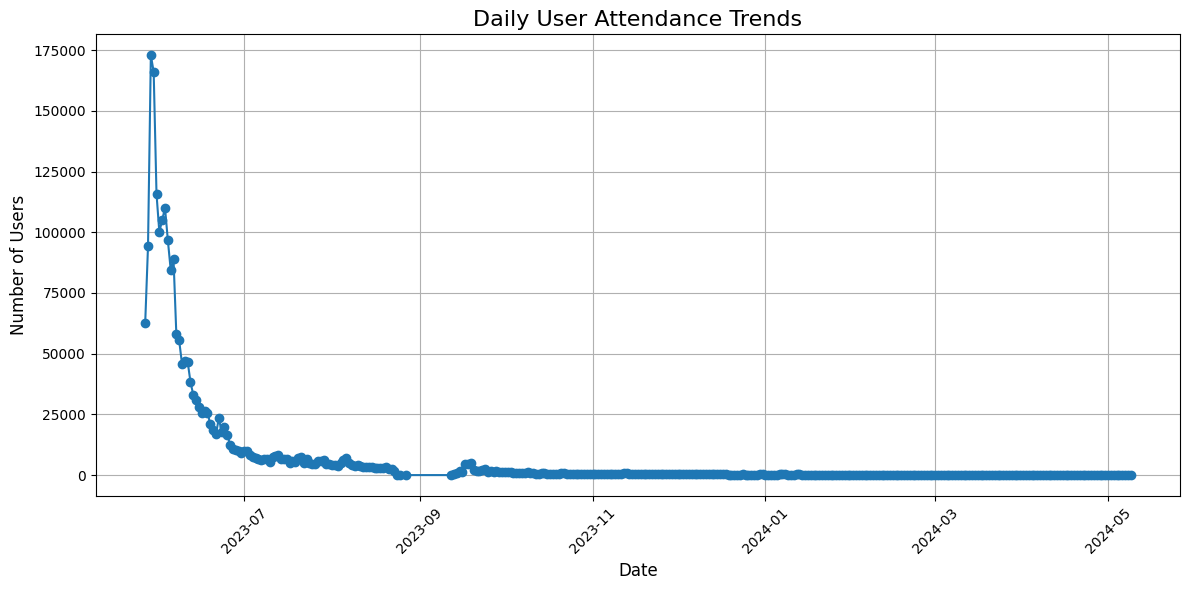

In [ ]:
# 출석 경향 시각화
# 일별 유저 출석 경향 그래프
plt.figure(figsize=(12, 6))
plt.plot(attendance_trends['attendance_date'], attendance_trends['user_count'])  # 날짜별 출석 유저 수
plt.title('Daily User Attendance Trends', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


### 날짜별 결제횟수 분포

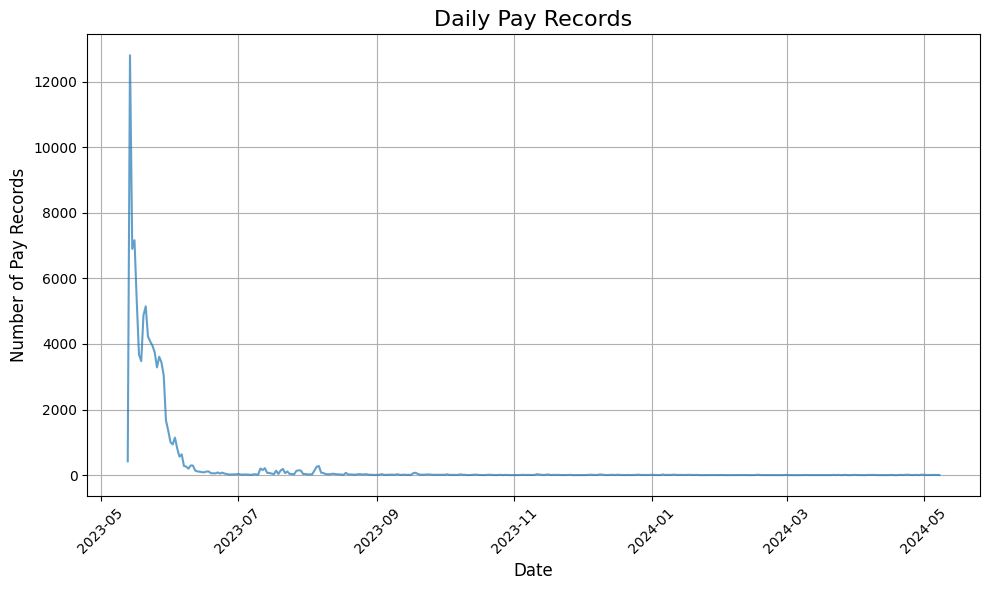

In [ ]:
# 결제가 발생한 시간을 datetime 형식으로 변환
v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at'])

# 날짜별 결제 수량 계산
daily_pay_counts = v_acc_pay['created_at'].dt.date.value_counts().sort_index()


# 날짜별 결제 트렌드 시각화
plt.figure(figsize=(10, 6))
plt.plot(daily_pay_counts.index, daily_pay_counts.values, alpha=0.7)
plt.title('Daily Pay Records', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Pay Records', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### 날짜별 계정 생성 분포

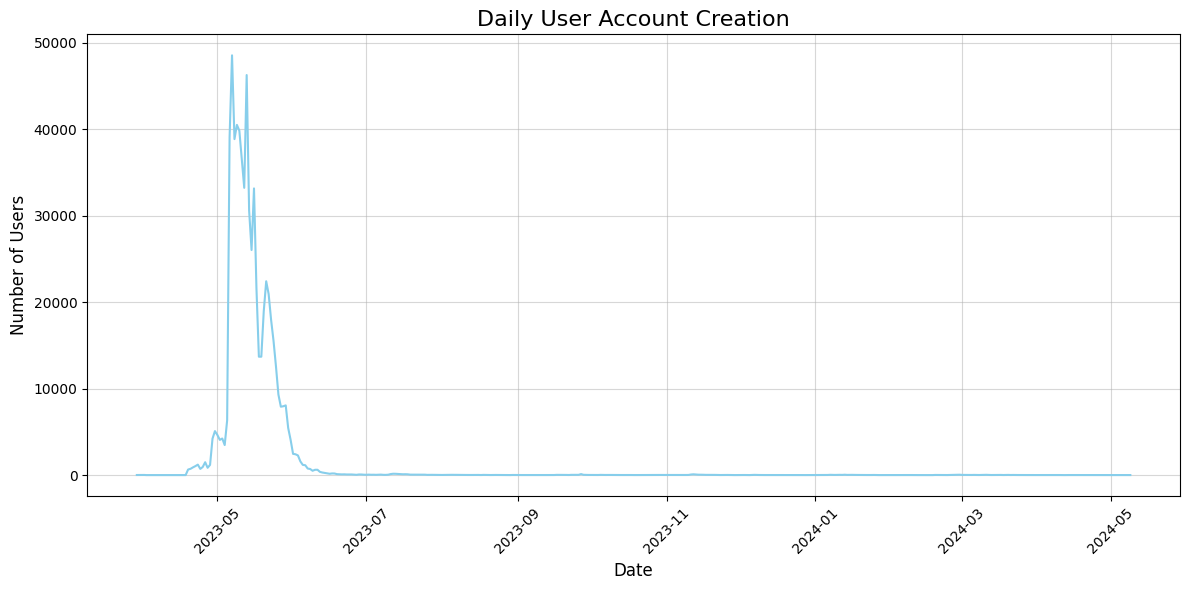

In [ ]:
vau_df = v_acc_user.copy()

# `created_at`를 datetime 형식으로 변환
vau_df['created_at'] = pd.to_datetime(vau_df['created_at'])

# 날짜만 추출하여 created_date 생성
vau_df['created_date'] = vau_df['created_at'].dt.date

# 날짜별로 계정 생성 수 집계
daily_counts = vau_df['created_date'].value_counts().sort_index()

# 시각화 (일별 데이터)
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, linestyle='-', color='skyblue')
plt.title('Daily User Account Creation', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### 시간별, 요일별 투표 횟수 분포

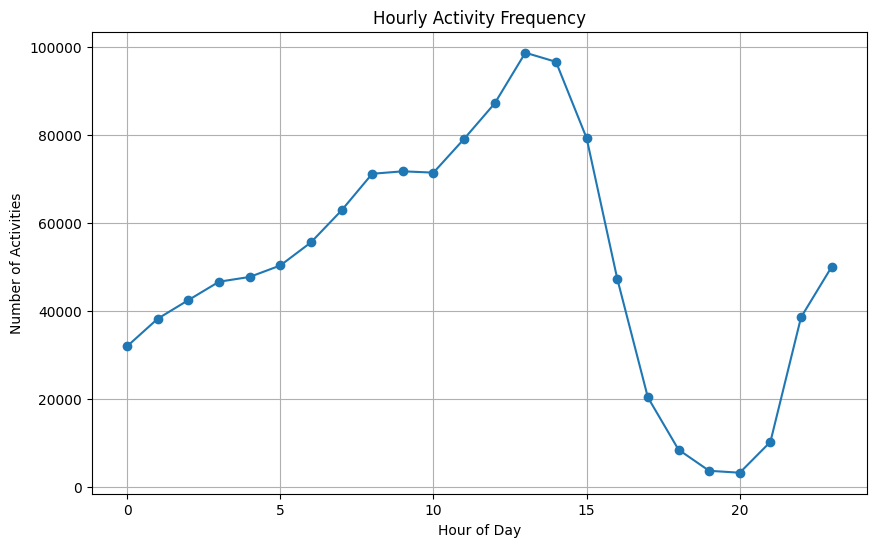

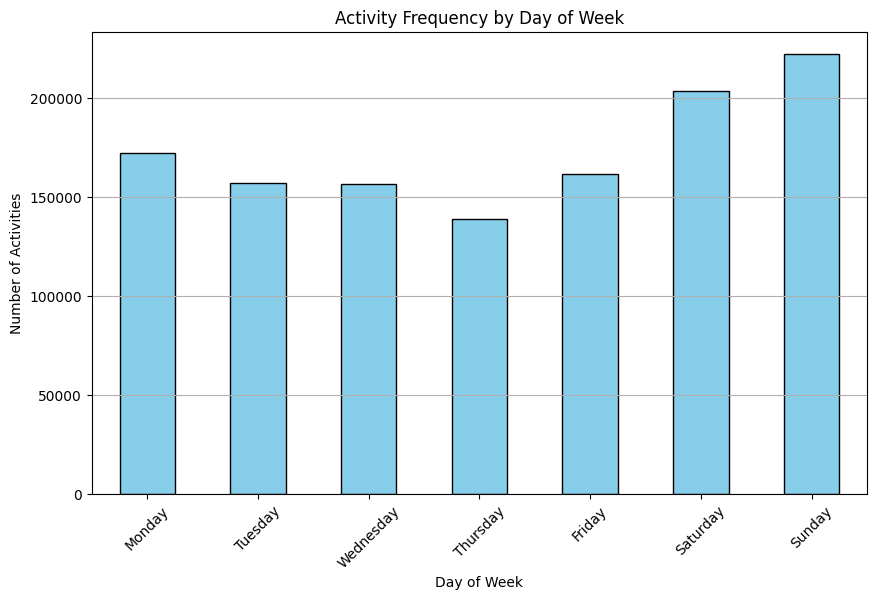

In [ ]:
uqrec = v_acc_uqrec.copy()

uqrec['created_at'] = pd.to_datetime(uqrec['created_at'])

# 시간과 요일 추출
uqrec['hour'] = uqrec['created_at'].dt.hour
uqrec['day_of_week'] = uqrec['created_at'].dt.day_name()

# 시간별 투표 횟수
hourly_activity = uqrec['hour'].value_counts().sort_index()

# 시간별 투표 횟수 분포 시각화
plt.figure(figsize=(10, 6))
plt.plot(hourly_activity.index, hourly_activity.values, marker='o')
plt.title('Hourly Activity Frequency')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Activities')
plt.grid()
plt.show()

# 요일별 투표 횟수
day_of_week_activity = uqrec['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# 요일별 투표 횟수 분포 시각화
plt.figure(figsize=(10, 6))
day_of_week_activity.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activity Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### 날짜별 사용자 탈퇴 분포

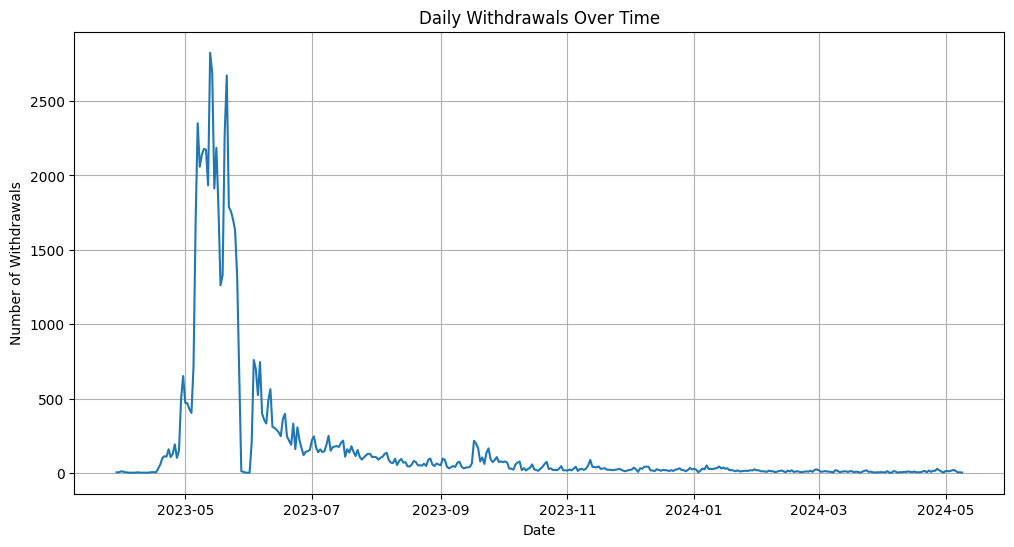

In [ ]:
uwd = v_acc_uwd.copy()

uwd['created_at'] = pd.to_datetime(uwd['created_at'])

# 날짜와 시간 추출
uwd['date'] = uwd['created_at'].dt.date
uwd['hour'] = uwd['created_at'].dt.hour

# 날짜 탈퇴 분포
daily_withdrawals = uwd['date'].value_counts().sort_index()

# 일별 탈퇴 분포 시각화
plt.figure(figsize=(12, 6))
daily_withdrawals.plot(kind='line')
plt.title('Daily Withdrawals Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Withdrawals')
plt.grid()
plt.show()

### 탈퇴 사유 시간대별 분포

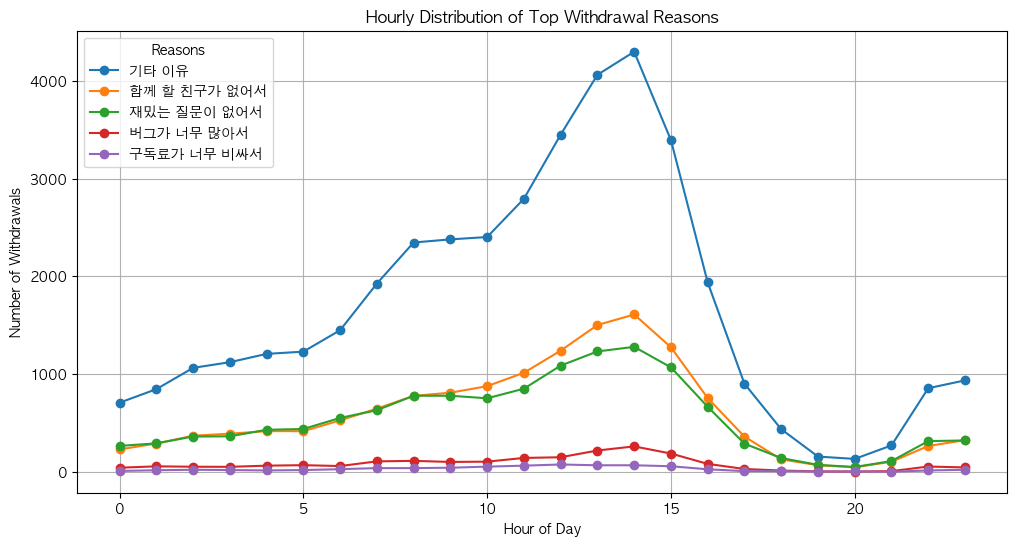

In [ ]:
#  시간별 이유 횟수 그룹화하여 시간대별 이유 횟수 생성
hourly_reason_counts = uwd.groupby(['hour', 'reason']).size().unstack(fill_value=0)
withdraw_reason_counts = v_acc_uwd['reason'].value_counts()

# 시간대별 이유 분포 시각화
top_reasons = withdraw_reason_counts.head(5).index
hourly_reason_counts[top_reasons].plot(kind='line', figsize=(12, 6), marker='o')

plt.title('Hourly Distribution of Top Withdrawal Reasons')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Withdrawals')
plt.legend(title='Reasons', loc='upper left')
plt.grid()
plt.show()

## 4. AARRR 프레임워크 분석을 통한 서비스 파악

### 4-1. Acquisition

- 신규 가입자 수

In [ ]:
v_acc_user['created_at'] = pd.to_datetime(v_acc_user['created_at'])

# 년/월 단위로 그룹화하여 고유 사용자 수 집계
monthly_new_users = (
    v_acc_user.groupby(v_acc_user['created_at'].dt.to_period('M'))['id']
    .nunique()
    .reset_index()
)

# 열 이름 변경
monthly_new_users.columns = ['month', 'new_users']

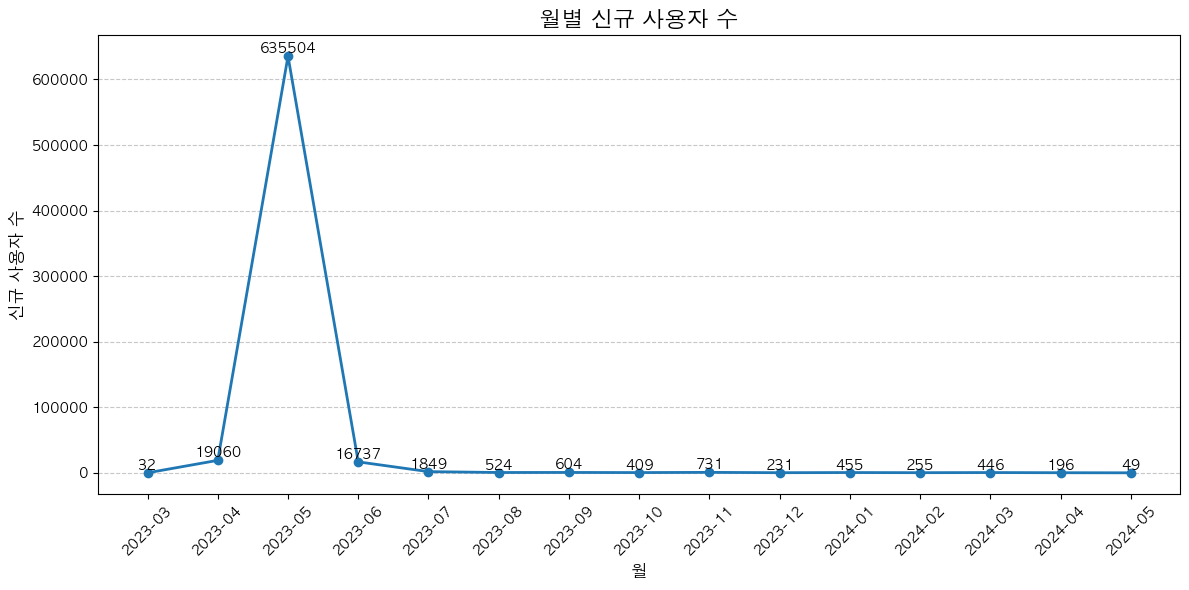

In [ ]:
graph_df = monthly_new_users.copy()
graph_df['month'] = monthly_new_users['month'].astype(str)

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(graph_df['month'], graph_df['new_users'], marker='o', linestyle='-', linewidth=2)

# 각 마커 위에 수치 표시
for i, value in enumerate(graph_df['new_users']):
    plt.text(i, value, str(value), fontsize=10, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('월별 신규 사용자 수', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('신규 사용자 수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Hackle 이벤트 데이터에서 회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율

In [ ]:
#  event_datetime을 datetime 타입으로 변환
h_evt['event_datetime'] = pd.to_datetime(h_evt['event_datetime'])

# 회원가입 완료 이벤트 필터링
signup_events = h_evt[h_evt['event_key'] == 'complete_signup']

# 회원가입을 완료한 사용자 수
complete_signup_user_count = signup_events['session_id'].nunique()

# 회원가입 완료 이벤트 필터링
signup_page_events = h_evt[h_evt['event_key'] == 'view_signup']

# 회원가입 페이지에 접속한 사용자 수
enter_signup_user_count = signup_page_events['session_id'].nunique()

# 회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율
complete_signup_user_rate = (complete_signup_user_count / enter_signup_user_count) * 100

print(f"회원가입을 완료한 사용자 수: {complete_signup_user_count}")
print(f"회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율: {complete_signup_user_rate}")

회원가입을 완료한 사용자 수: 973
회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율: 12.779091147885474


### 4-2. Activation

- 첫번째 투표 참여율
  1. vote table 이용

In [ ]:
# staff 필터링
only_user = v_acc_user[v_acc_user.is_staff != 1]

 # 가입한 총 유저 수 구하기
total_user_count = only_user.id.nunique()

#질문에 응답한 유저 수 구하기

# total_user_count에 있는 유저만 v_acc_user에서 필터링
# 필터링 결과 v_acc_user에 있는 user는 모두 total_user_count에 존재
filtered_data = v_acc_uqrec[v_acc_uqrec['user_id'].isin(v_acc_user['id'])]

answer_user_count = filtered_data.user_id.nunique()

In [ ]:
# 가입자 중 투표 참여율 구하기
(answer_user_count / total_user_count) * 100

0.7161614102870848

- 첫번째 투표 참여율
  2. hackle 이용

In [ ]:
hackle_properties_preprocessed = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/hackle/hackle_properties_preprocessed.csv')

# 가입한 총 유저 수 구하기

# complete_signup 사건만 모아보기
complete_signup = hackle_events[hackle_events.event_key == 'complete_signup'][['event_datetime','event_key','session_id']]

# hackle_properties_preprocessed에서 매칭할 컬럼만 뽑기
match_df = hackle_properties_preprocessed[['session_id','user_id']]
#중복값 제거
match_df= match_df.drop_duplicates()

# user_id 붙이기
merged_df = pd.merge(complete_signup, match_df, on = 'session_id', how = 'left')

# 2023-07-18~ 2023-08-10에 가입한 총 유저 수 구하기
total_user_count = merged_df.user_id.nunique()

#질문에 응답한 유저 수 구하기

# click_question_start 사건만 모아보기
click_question_start = hackle_events[hackle_events.event_key == 'click_question_start'][['event_datetime','event_key','session_id']]

# user_id 붙이기
merged_question_df = pd.merge(click_question_start, match_df, on = 'session_id', how = 'left')

# 2023-07-18~ 2023-08-10에 가입한 유저만 필터링
filter_df = merged_question_df[merged_question_df['user_id'].isin(merged_df['user_id'])]

# 2023-07-18~ 2023-08-10에 가입한 유저 중 질문에 응답한 유저 수 구하기
answer_user_count = filter_df.user_id.nunique()

In [ ]:
# 계산
answer_user_count / total_user_count * 100

59.9290780141844

-  회원 가입 후, 사용자가 핵심 기능을 처음 이용하기까지 걸린 시간의 분포

In [ ]:
# 유저 가입 날짜 데이터셋
user_join_date = only_user[['id','created_at']]

# 컬럼 이름 변경
user_join_date = user_join_date.rename(columns = {'id': 'user_id', 'created_at':'join_date'})

# user_id별로 created_at이 가장 오래된 행만 필터링
oldest_row = v_acc_uqrec.loc[v_acc_uqrec.groupby('user_id')['created_at'].idxmin()][['user_id', 'created_at']]

oldest_row = oldest_row.rename(columns = {'created_at':'first_vote_date'})

# 두 데이터 셋 합치기
merged_df= pd.merge(user_join_date, oldest_row, on = 'user_id', how = 'right' )

# 데이터 타입 변경
merged_df['first_vote_date'] = pd.to_datetime(merged_df['first_vote_date'])
merged_df['join_date'] = pd.to_datetime(merged_df['join_date'])

# 활성화되기까지의 시간 컬럼 생성
merged_df['activation_time'] = merged_df['first_vote_date'] - merged_df['join_date']


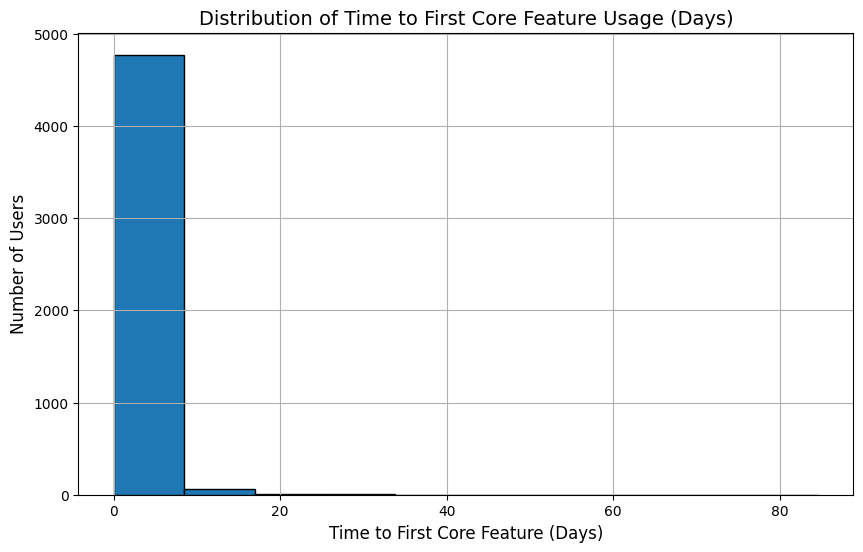

In [ ]:
# timedelta를 일단위로 변경
merged_df['activation_time_days'] = merged_df['activation_time'].dt.total_seconds() / (24 * 3600)

# 히스토그램: 가입 후 핵심 기능 사용까지 걸린 시간 (days 단위)
plt.figure(figsize=(10, 6))
plt.hist(merged_df['activation_time_days'], bins=10, edgecolor='black')
plt.title("Distribution of Time to First Core Feature Usage (Days)", fontsize=14)
plt.xlabel("Time to First Core Feature (Days)", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 20일 이내 필터링
merged_7_df = merged_df[merged_df['activation_time_days']<= 7]

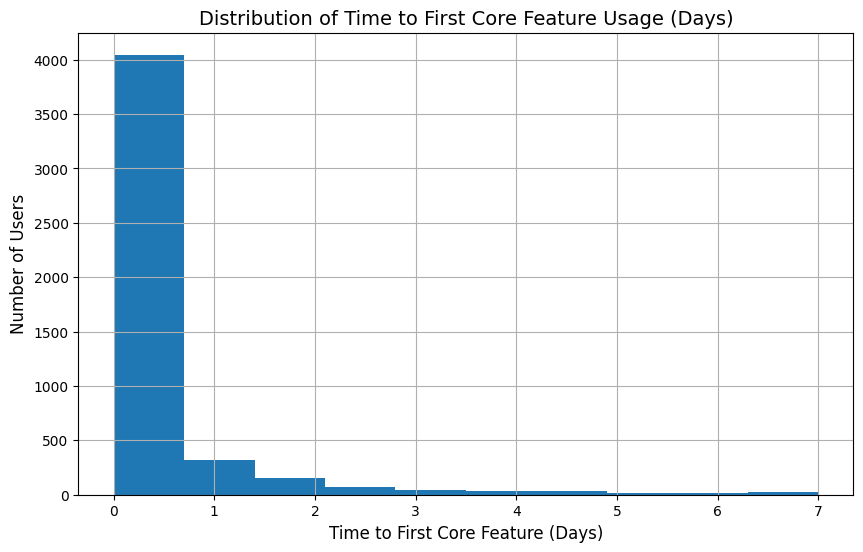

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(merged_7_df['activation_time_days'])
plt.title("Distribution of Time to First Core Feature Usage (Days)", fontsize=14)
plt.xlabel("Time to First Core Feature (Days)", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 회원 가입 후 1일 이내 핵심기능을 하는 유저 비율 계산
count_less_than_1 = merged_df[merged_df['activation_time_days'] < 1].shape[0]

# 전체 행 수
total_count = merged_df.shape[0]

# 비율 계산
percentage_less_than_1 = (count_less_than_1 / total_count) * 100

In [ ]:
percentage_less_than_1

87.4613322334502

### 4-3. Retention

#### DAU / WAU / MAU

Text(0, 0.5, 'user_count')

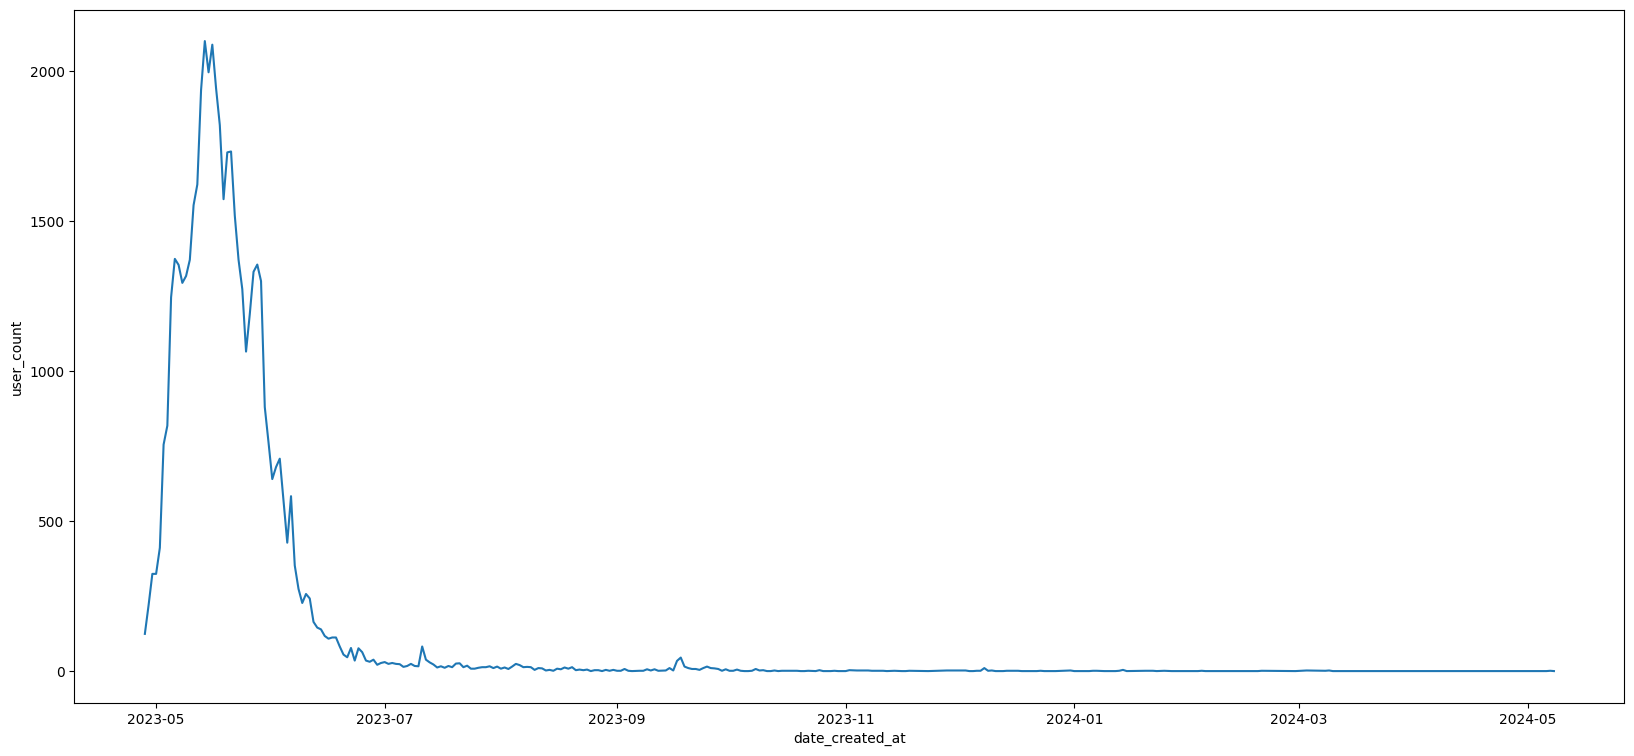

In [ ]:
## created_at을 date로 뽑아내서 일 기준 DAU 구하기
v_acc_uqrec['date_created_at'] = v_acc_uqrec['created_at'].dt.date
DAU =v_acc_uqrec.groupby('date_created_at')['user_id'].nunique().reset_index()

## 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=DAU, x='date_created_at', y='user_id')
plt.ylabel('user_count')

Text(0, 0.5, 'user_count')

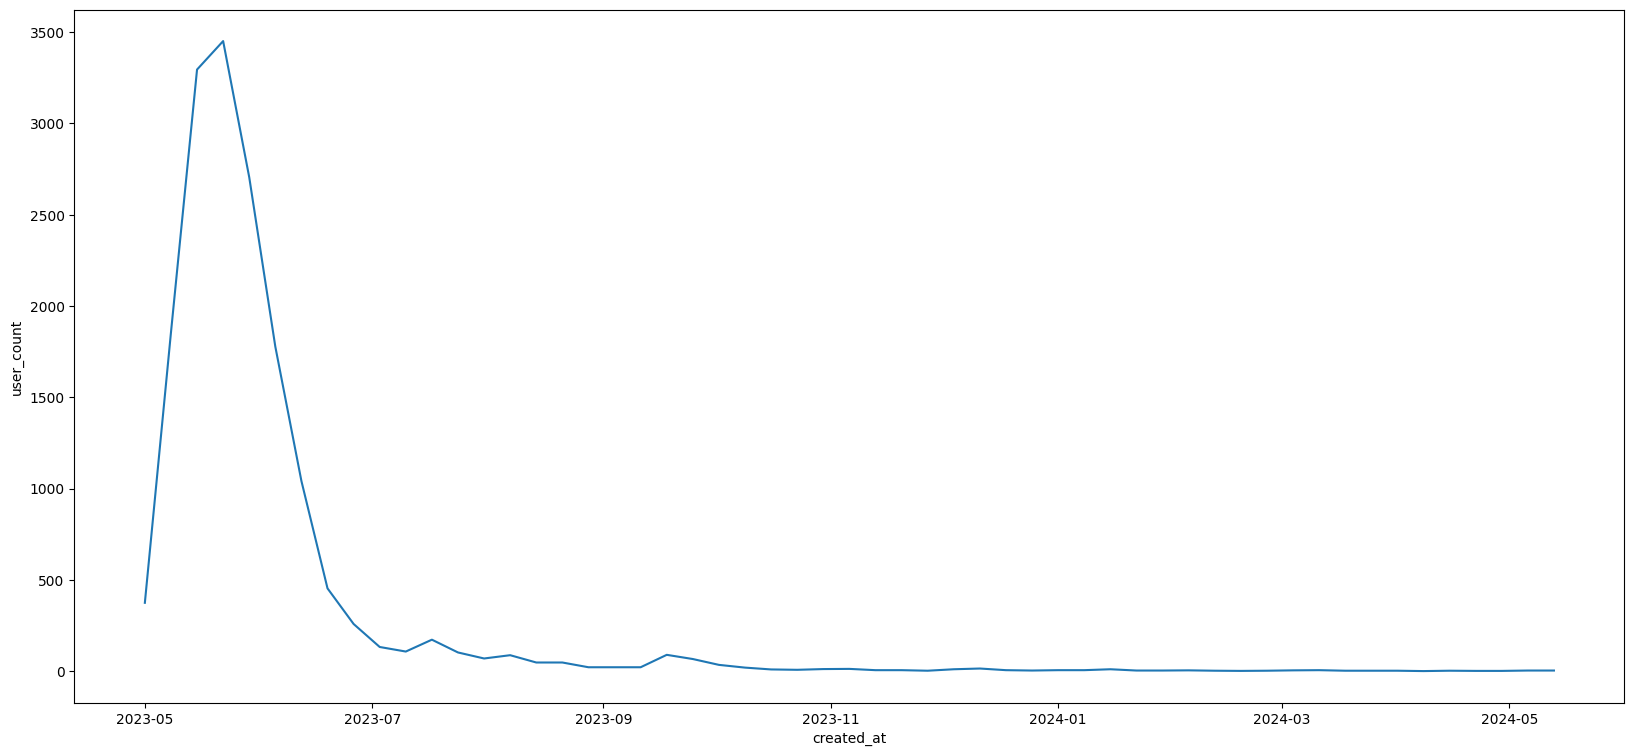

In [ ]:
# #created_at을 resample 이용하여 주별로 WAU 구하기
# 주 단위로 resample하려면, created_at을 인덱스로 설정해야 함
v_acc_uqrec.reset_index(inplace=True)
v_acc_uqrec.set_index('created_at', inplace=True)

# 주별로 user_id의 고유값 개수 계산 (월요일 기준으로 주간 시작)
WAU = v_acc_uqrec.resample('W-MON')['user_id'].nunique().reset_index()

## WAU 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=WAU, x='created_at', y='user_id')
plt.ylabel('user_count')

Text(0, 0.5, 'user_count')

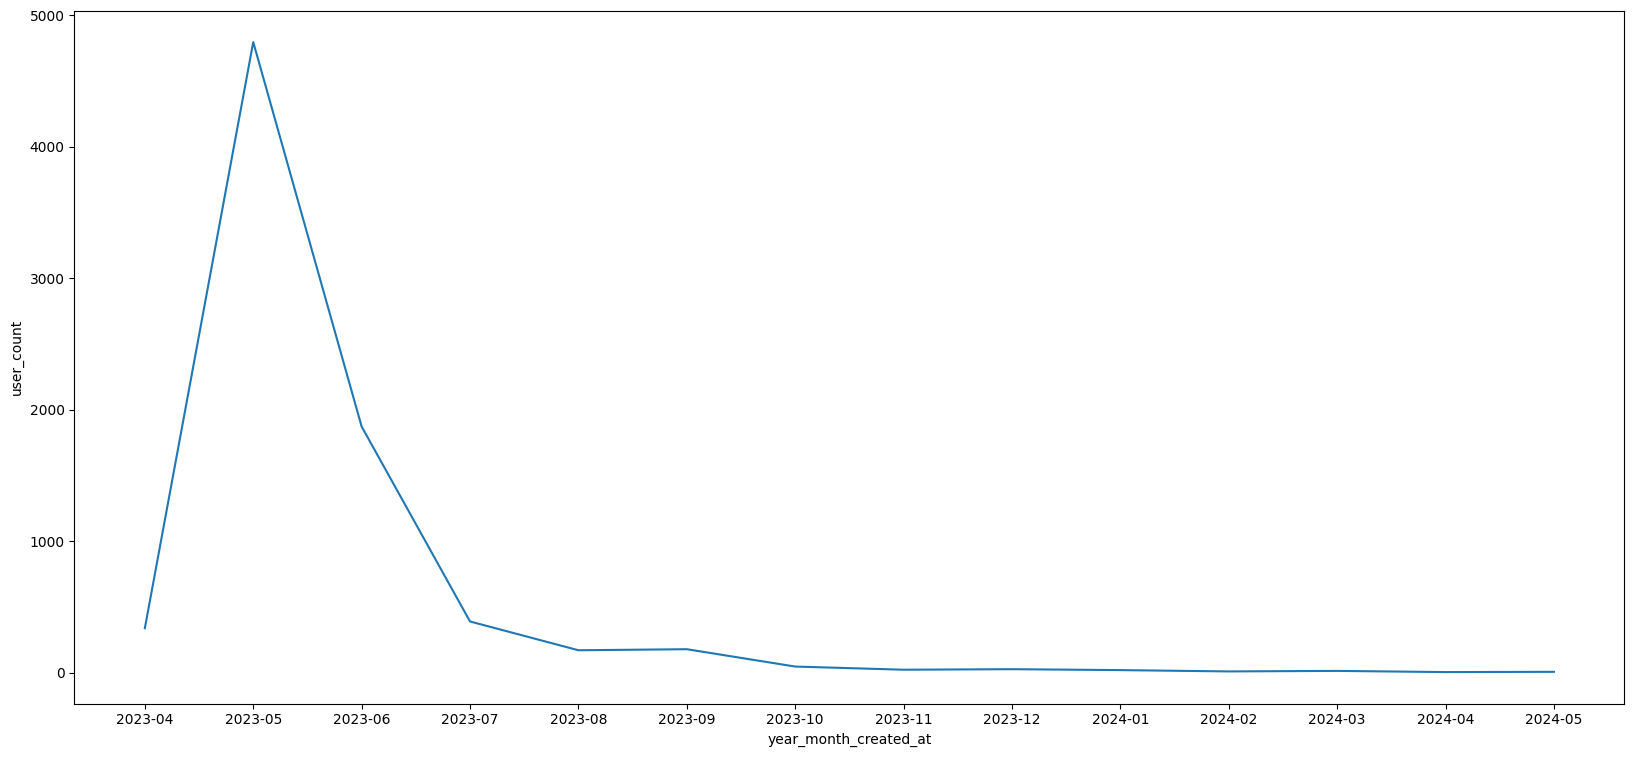

In [ ]:
## created_at을 year-month로 뽑아내서 일 기준 MAU 구하기
v_acc_uqrec = v_acc_uqrec.reset_index()
v_acc_uqrec['year_month_created_at'] = v_acc_uqrec['created_at'].dt.strftime("%Y-%m")
MAU =v_acc_uqrec.groupby('year_month_created_at')['user_id'].nunique().reset_index()
MAU

## MAU 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=MAU, x='year_month_created_at', y='user_id')
plt.ylabel('user_count')

#### 유지율 (클래식 리텐션 Day1/Day7/Day30)

In [ ]:
## 필요한 데이터만 조회(일자, user_id)
retention_basic = (v_acc_uqrec[['created_at', 'user_id']]).copy()
retention_basic['created_at'] = retention_basic['created_at'].dt.date
retention_basic.head()

,created_at,user_id
0,2023-04-28,849436
1,2023-04-28,849436
2,2023-04-28,849436
3,2023-04-28,849436
4,2023-04-28,849436


In [ ]:
## 날짜 리스트
date_list = retention_basic['created_at'].unique()

## 날짜 형식 변환 (다시 한번 해줘야 에러 없음)
retention_basic['created_at'] = pd.to_datetime(retention_basic['created_at'])

## user_id 별 최초 활동일 계산
first_activity = retention_basic.groupby('user_id')['created_at'].min().reset_index()
first_activity.rename(columns={'created_at': 'first_active_date'}, inplace=True)

## 기준일을 day 0으로 설정하여 리텐션 계산 함수 정의
def calculate_retention_with_reference(retention_basic, reference_date, target_days):
    reference_date = pd.to_datetime(reference_date)

    # 최초 활동일이 기준일 이전인 유저만 고려
    first_activity_filtered = first_activity[first_activity['first_active_date'] <= reference_date]
    retention_basic_filtered = retention_basic[retention_basic['user_id'].isin(first_activity_filtered['user_id'])]

    # 기준일로부터의 경과일 계산
    retention_basic_filtered['days_since_reference'] = (retention_basic_filtered['created_at'] - reference_date).dt.days

    # 기준일에 기준 활동 유저 수 계산
    users_at_reference = first_activity_filtered['user_id'].nunique()

    # 타겟 날짜에 활동한 유저 수 계산
    retained_users = retention_basic_filtered[retention_basic_filtered['days_since_reference'] == target_days]['user_id'].nunique()

    # 리텐션 계산
    try:
      retention_rate = retained_users / users_at_reference * 100
    except ZeroDivisionError:
      retention_rate = 0
      print("ZeroDivisionError: 해당 날짜에 활동한 유저가 없어 분모가 0 입니다.")
    return retention_rate


In [ ]:
## day 1 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 1))

<Axes: xlabel='created_at', ylabel='retention'>

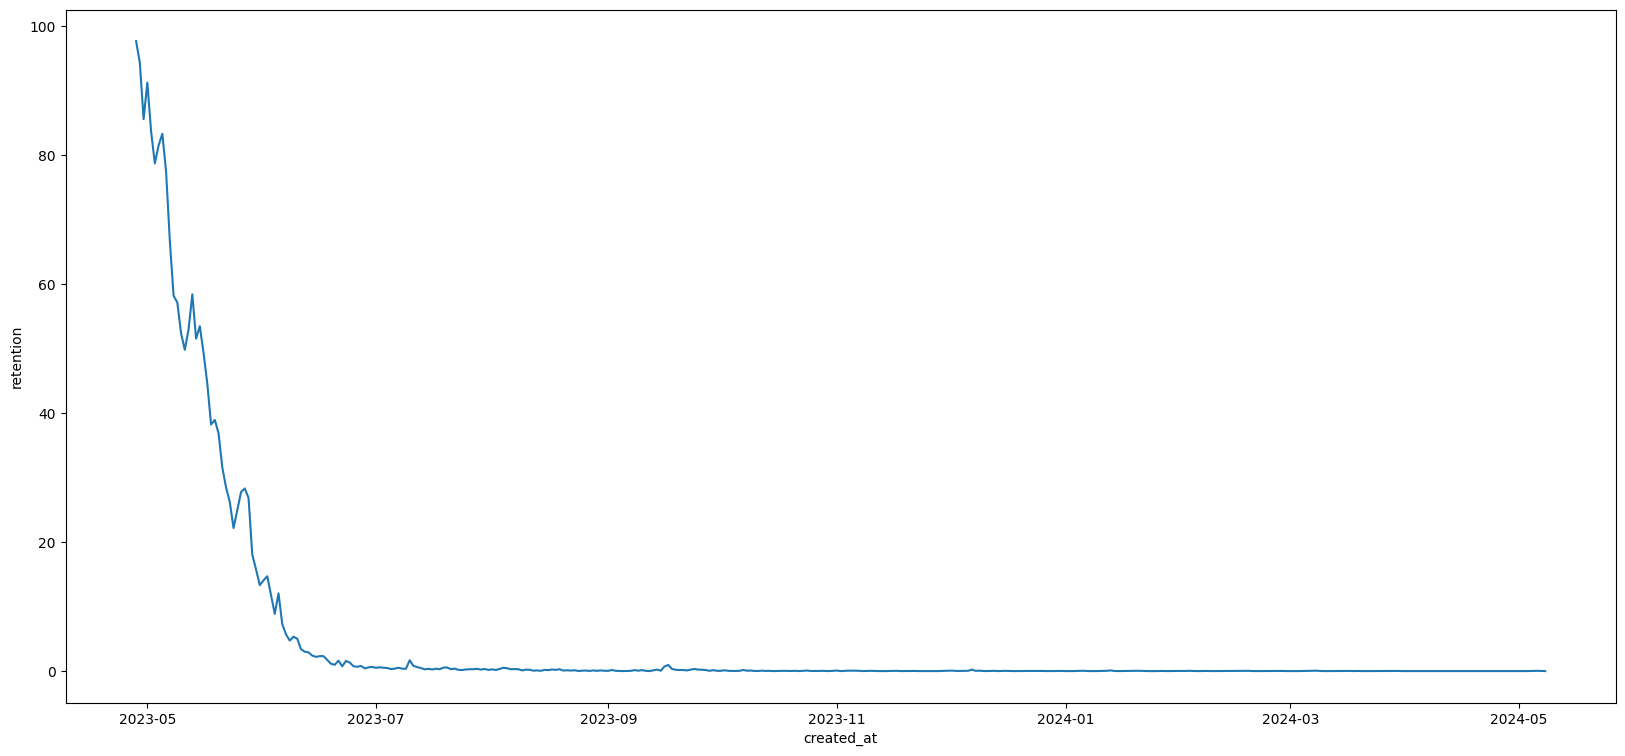

In [ ]:
## day 1 리텐션 데이터 프레임으로 만들기
day1 ={}
day1['created_at'] = list(retention_basic['created_at'].unique())
day1['retention'] = retention_list

day1 = pd.DataFrame(day1)

## day 1 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day1, x='created_at', y='retention')

In [ ]:
## day 7 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 7))

<Axes: xlabel='created_at', ylabel='retention'>

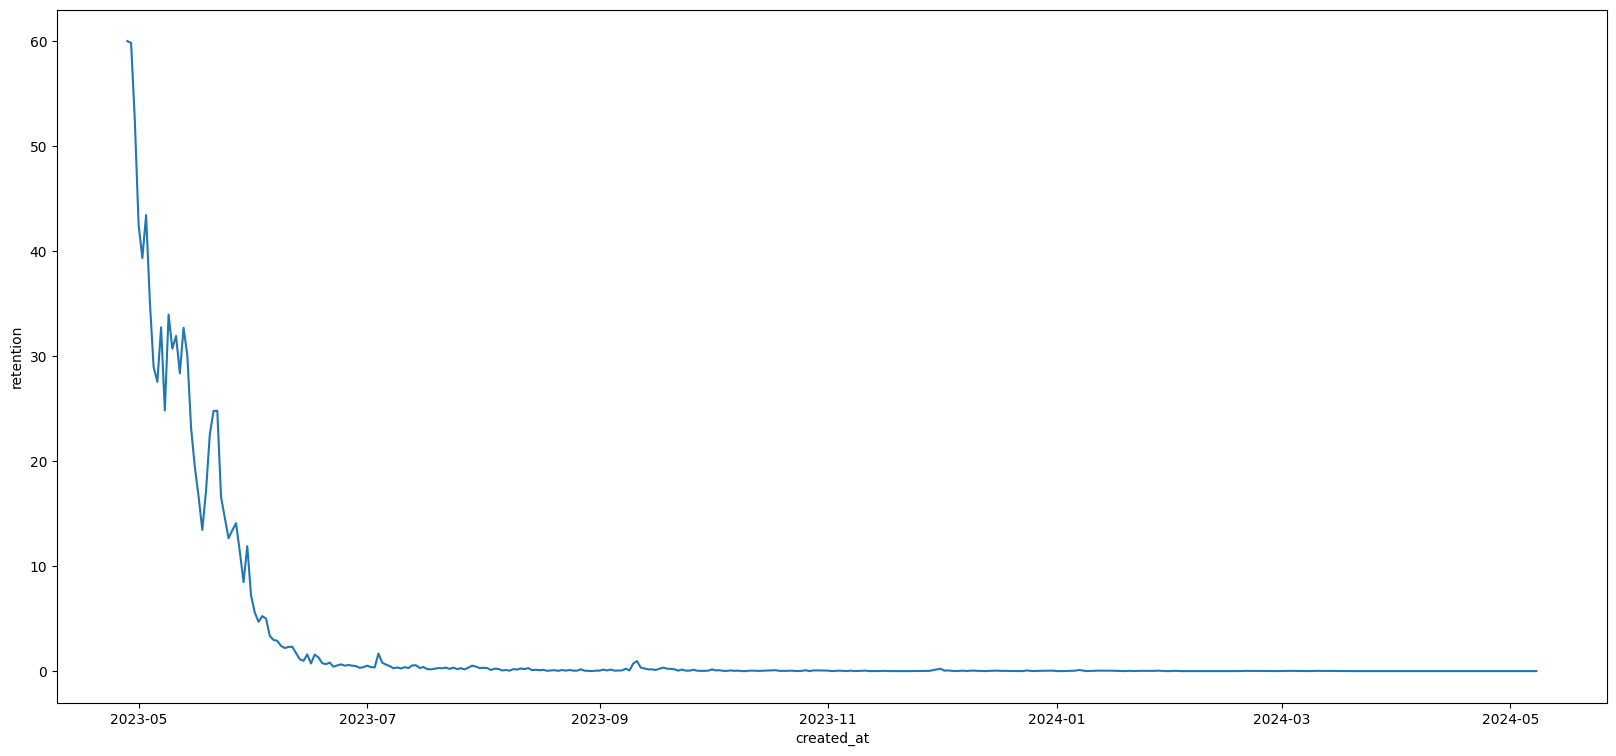

In [ ]:
## day 7 리텐션 데이터 프레임으로 만들기
day7 ={}
day7['created_at'] = list(retention_basic['created_at'].unique())
day7['retention'] = retention_list

day7 = pd.DataFrame(day7)

## day 7 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day7, x='created_at', y='retention')

In [ ]:
## day 30 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 30))

<Axes: xlabel='created_at', ylabel='retention'>

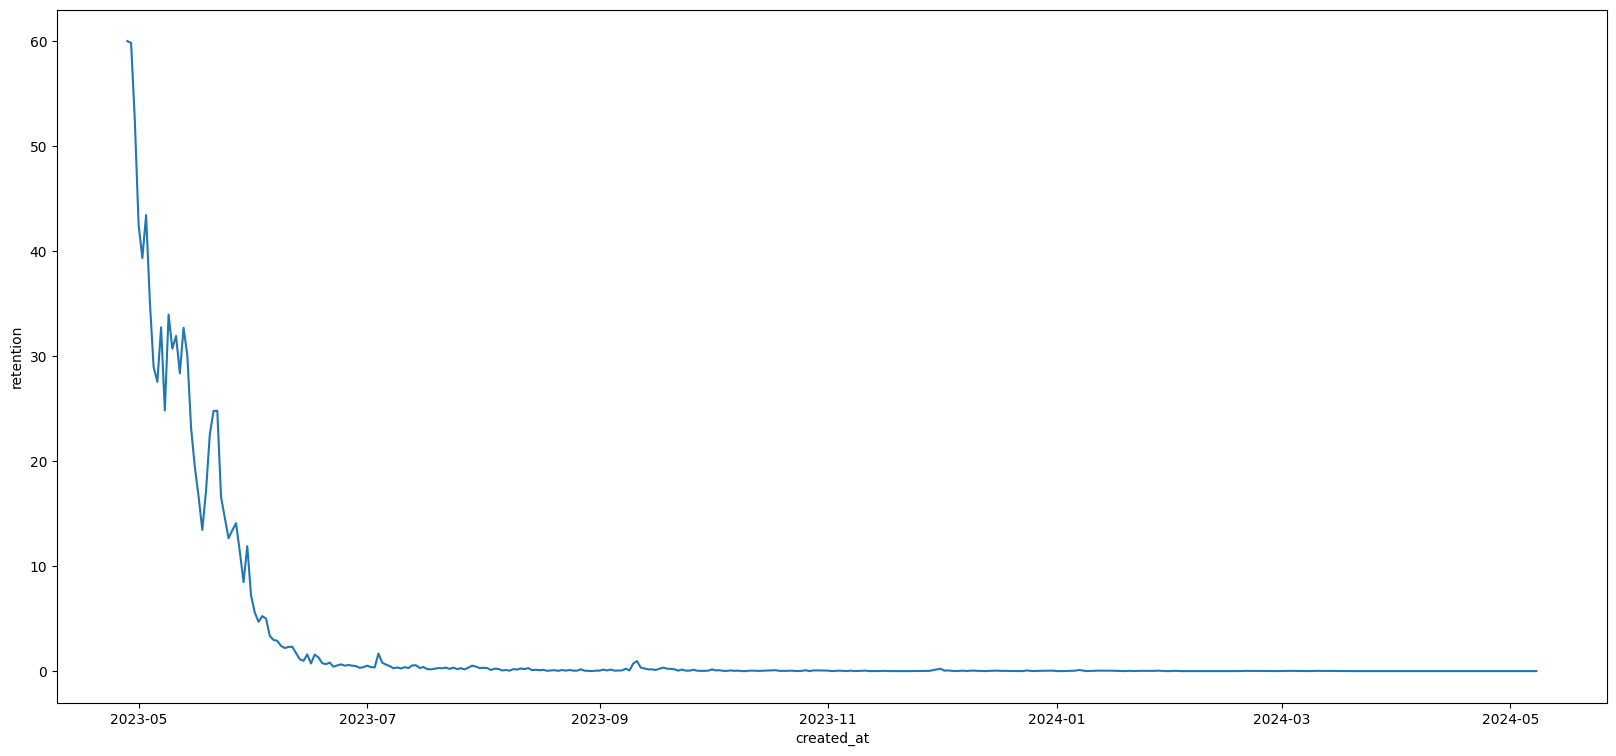

In [ ]:
## day 30 리텐션 데이터 프레임으로 만들기
day30 ={}
day30['created_at'] = list(retention_basic['created_at'].unique())
day30['retention'] = retention_list

day30 = pd.DataFrame(day30)

## day 30 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day7, x='created_at', y='retention')

#### 탈퇴건수

Text(0, 0.5, 'withdraw_user_count')

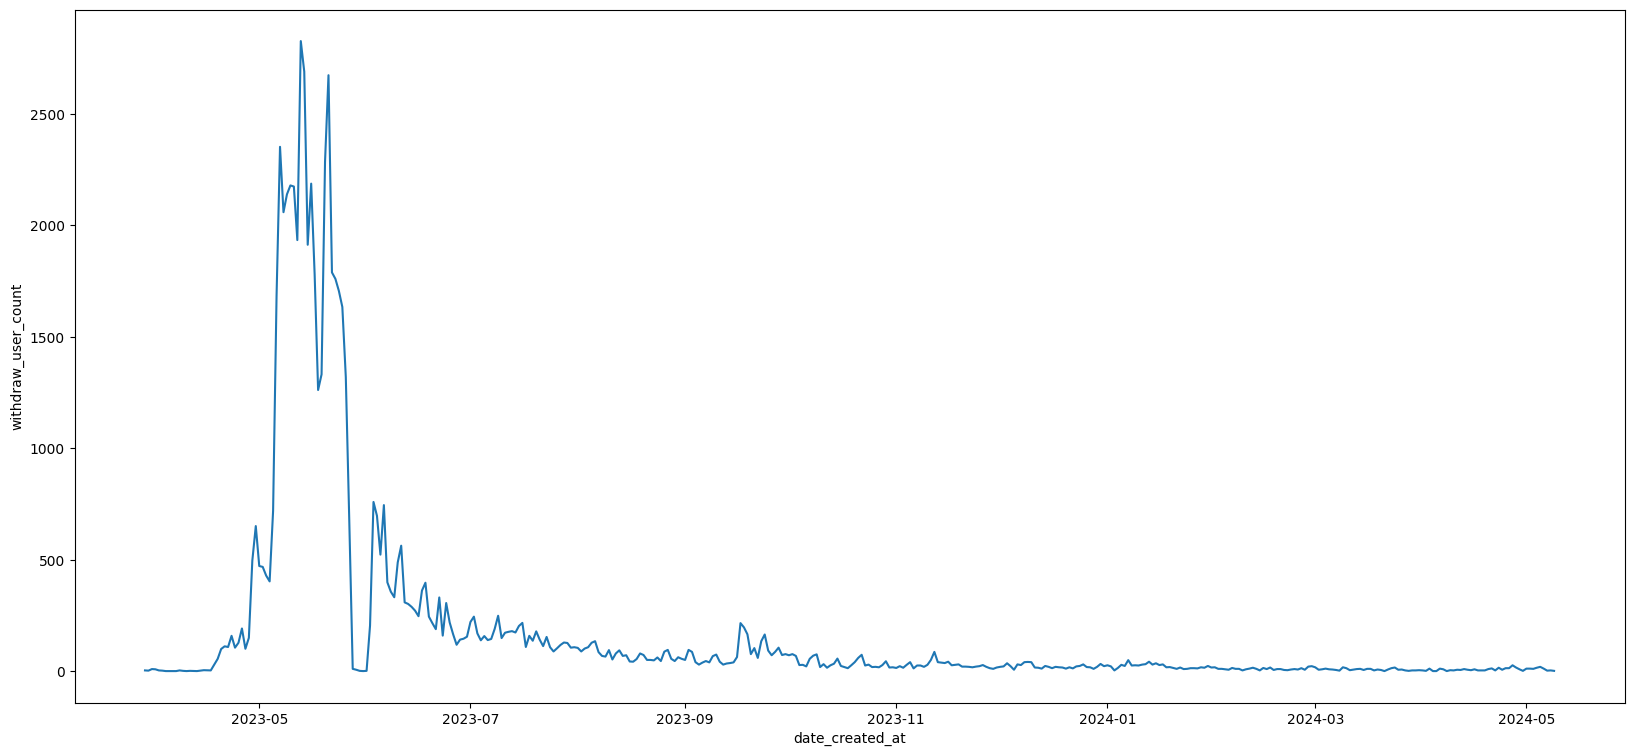

In [ ]:
## date 기준으로 뽑아주기
v_acc_uwd['created_at'] =pd.to_datetime(v_acc_uwd['created_at'])
v_acc_uwd['date_created_at'] = v_acc_uwd['created_at'].dt.date

## date 기준으로 탈퇴건수 구하기
withdraw_count = pd.DataFrame(v_acc_uwd.groupby('date_created_at')['id'].count()).reset_index()
withdraw_count

## 탈퇴건수 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=withdraw_count, x='date_created_at', y='id')
plt.ylabel('withdraw_user_count')

#### 탈퇴율

C:\Users\jungh\AppData\Local\Temp\ipykernel_18632\3278066751.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  current_users['create_account_cumsum'] = current_users['create_account_cumsum'].fillna(method='ffill')


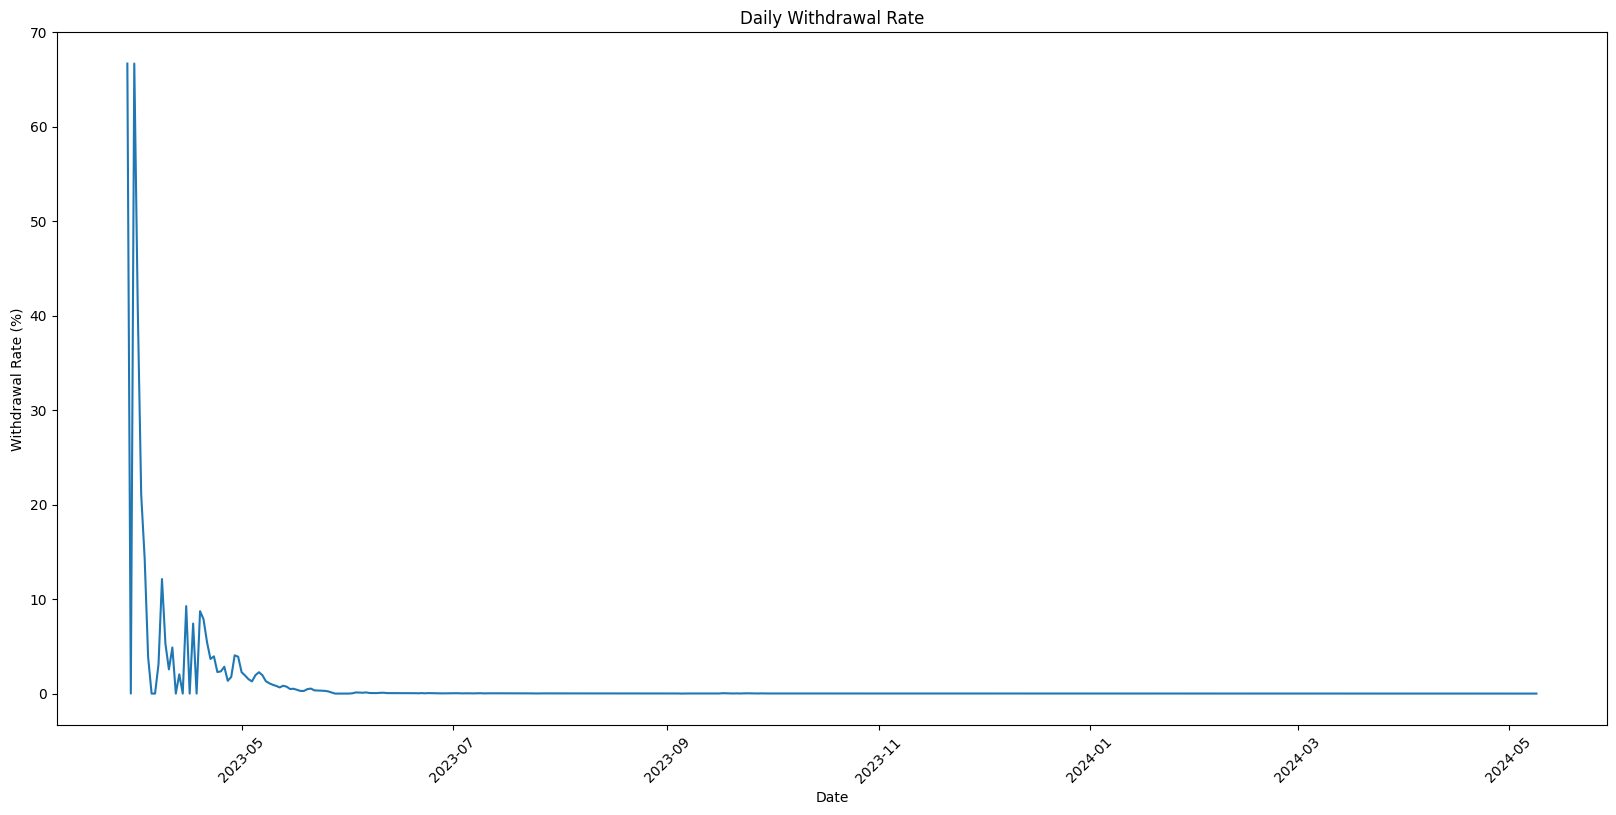

In [ ]:
def process_account_creation(v_acc_user):
    """생성된 계정의 일자별 누적 사용자 수를 계산"""
    create_account_users = v_acc_user[['id', 'created_at']].copy()
    create_account_users['created_at'] = pd.to_datetime(create_account_users['created_at'])
    create_account_users['date_created_at'] = create_account_users['created_at'].dt.date

    # 날짜별 고유 유저 수와 누적 유저 수 계산
    create_account_users_temp = (
        create_account_users.groupby('date_created_at')['id']
        .nunique()
        .reset_index(name='unique_users')
    )
    create_account_users_temp['create_account_cumsum'] = create_account_users_temp['unique_users'].cumsum()

    return create_account_users_temp[['date_created_at', 'create_account_cumsum']]

def process_withdrawal(v_acc_uwd):
    """탈퇴한 계정의 일자별 누적 탈퇴 사용자 수를 계산"""
    withdraw = v_acc_uwd[['id', 'created_at']].copy()
    withdraw['created_at'] = pd.to_datetime(withdraw['created_at'])
    withdraw['date_created_at'] = withdraw['created_at'].dt.date

    # 날짜별 고유 유저 수와 누적 유저 수 계산
    withdraw_temp = (
        withdraw.groupby('date_created_at')['id']
        .nunique()
        .reset_index(name='unique_users')
    )
    withdraw_temp['withdraw_cumsum'] = withdraw_temp['unique_users'].cumsum()

    return withdraw_temp[['date_created_at', 'withdraw_cumsum']]

def calculate_withdraw_rate(create_account_users_temp, withdraw_temp, withdraw_count):
    """탈퇴율을 계산하는 함수"""
    # 두 개의 누적 데이터프레임을 병합
    current_users = pd.merge(create_account_users_temp, withdraw_temp, on='date_created_at', how='outer')

    # 결측값을 이전 행의 값으로 채움 (전날의 누적 사용자 수와 누적 탈퇴 수 유지)
    current_users['create_account_cumsum'] = current_users['create_account_cumsum'].fillna(method='ffill')
    current_users['withdraw_cumsum'] = current_users['withdraw_cumsum'].fillna(0)

    # 총 유저 수 계산
    current_users['total_users'] = current_users['create_account_cumsum'] - current_users['withdraw_cumsum']

    # withdraw_count 테이블과 병합 후 탈퇴율 계산
    withdraw_count = withdraw_count.rename(columns={'id': 'withdraw_count'})
    withdraw_rate = pd.merge(current_users, withdraw_count, on='date_created_at', how='left')
    withdraw_rate['withdraw_rate'] = round((withdraw_rate['withdraw_count'] / withdraw_rate['total_users']) * 100, 2)

    # 결측값을 0으로 채움
    withdraw_rate['withdraw_rate'] = withdraw_rate['withdraw_rate'].fillna(0)

    return withdraw_rate

def visualize_withdraw_rate(withdraw_rate):
    """탈퇴율을 시각화하는 함수"""
    fig = plt.figure(figsize=(20, 9))
    sns.lineplot(data=withdraw_rate, x='date_created_at', y='withdraw_rate')
    plt.title('Daily Withdrawal Rate')
    plt.xlabel('Date')
    plt.ylabel('Withdrawal Rate (%)')
    plt.xticks(rotation=45)
    plt.show()

# === 메인 실행 부분 ===
create_account_users_temp = process_account_creation(v_acc_user)
withdraw_temp = process_withdrawal(v_acc_uwd)
withdraw_rate = calculate_withdraw_rate(create_account_users_temp, withdraw_temp, withdraw_count)
visualize_withdraw_rate(withdraw_rate)

### 4-4. Revenue

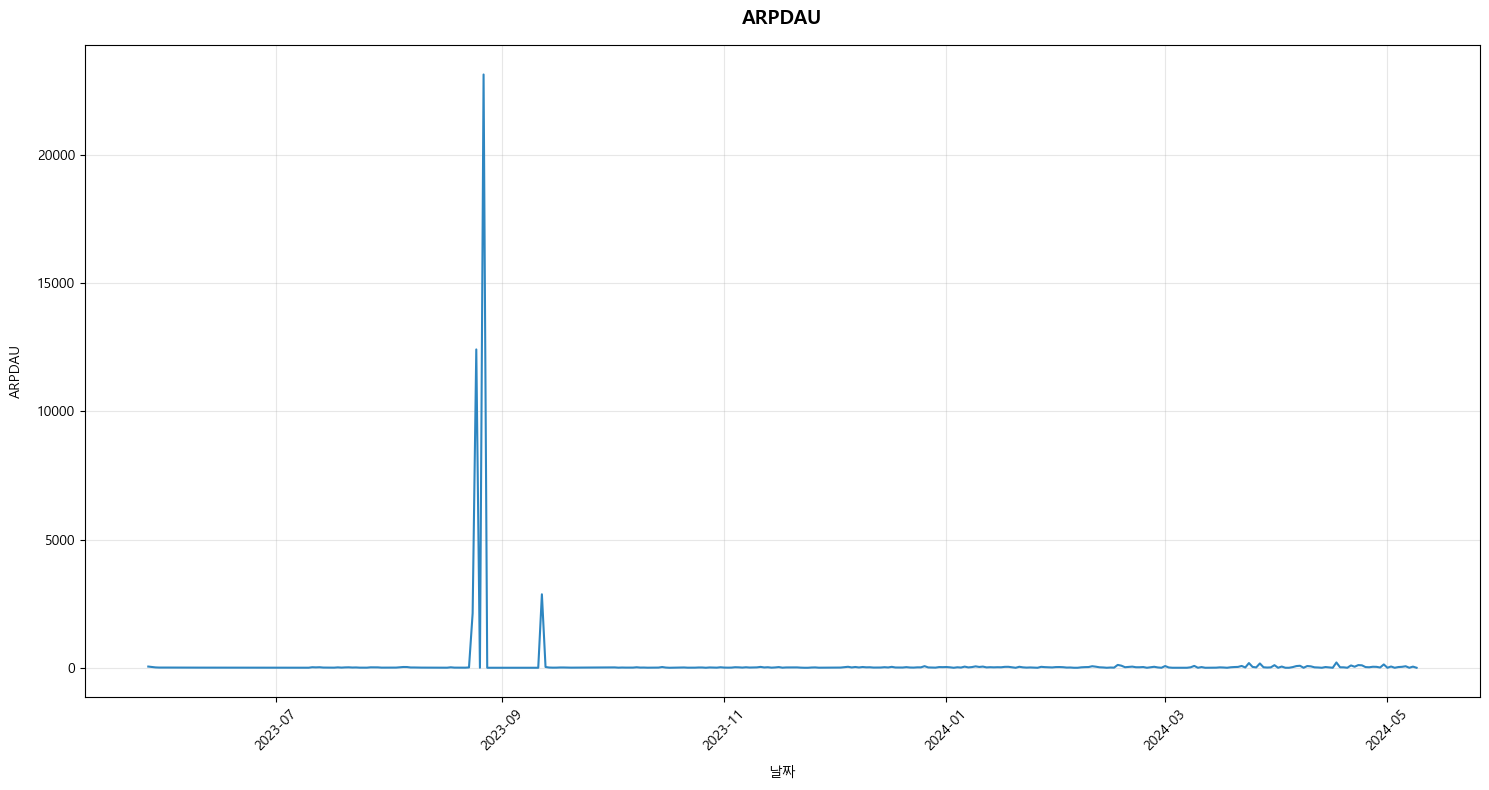

In [ ]:
v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date']).dt.date

date_range = pd.date_range(
    start=v_acc_atd['attendance_date'].min(),
    end=v_acc_atd['attendance_date'].max(),
    freq='D'
).date

daily_users = pd.DataFrame({'date': date_range})

# DAU
dau = v_acc_atd.groupby('attendance_date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'DAU']

# 빈 날짜 포함 병합
daily_users = daily_users.merge(dau, on='date', how='left')
daily_users['DAU'] = daily_users['DAU'].fillna(0)

replace_dict = {
    'heart.777': 777,
    'heart.200': 200,
    'heart.1000': 1000,
    'heart.4000': 4000
}
v_acc_pay['productId'].replace(replace_dict, inplace=True)

v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at']).dt.date

# 일별 매출 계산
daily_revenue = v_acc_pay.groupby('created_at')['productId'].sum().reset_index()
daily_revenue.columns = ['date', 'Revenue']

# 연속된 날짜 포함하여 매출 데이터 생성
daily_revenue = pd.DataFrame({'date': date_range}).merge(
    daily_revenue,
    on='date',
    how='left'
)
daily_revenue['Revenue'] = daily_revenue['Revenue'].fillna(0)

arpdau_df = pd.merge(daily_users, daily_revenue, on='date', how='outer')
arpdau_df = arpdau_df.fillna(0)

# ARPDAU 계산, DAU가 0인 경우 ARPDAU도 0
arpdau_df['ARPDAU'] = np.where(
    arpdau_df['DAU'] == 0,
    0,
    arpdau_df['Revenue'] / arpdau_df['DAU']
)

plt.figure(figsize=(15, 8))
plt.plot(arpdau_df['date'], arpdau_df['ARPDAU'],
         linewidth=1.5,
         color='#2E86C1')
plt.title('ARPDAU',
         pad=15,
         fontsize=14,
         fontweight='bold')
plt.xlabel('날짜', labelpad=10)
plt.ylabel('ARPDAU', labelpad=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4-5. Referral

- 초대를 받고 가입을 하는 사용자 수

In [ ]:
invited_users = v_acc_ucon[v_acc_ucon['invite_user_id_list'] != '[]']

invited_user_count = invited_users['user_id'].nunique()

print(f"초대를 받고 가입을 하는 사용자 수: {invited_user_count}")

초대를 받고 가입을 하는 사용자 수: 1158


In [ ]:
# 초대를 받은 사용자 ID 목록 추출
invited_user_ids = invited_users['user_id'].unique()

filtered_registration_data = v_acc_user[v_acc_user['id'].isin(invited_user_ids)]

# 필요한 열만 포함된 데이터프레임 생성
final_data = filtered_registration_data[['id', 'created_at']]

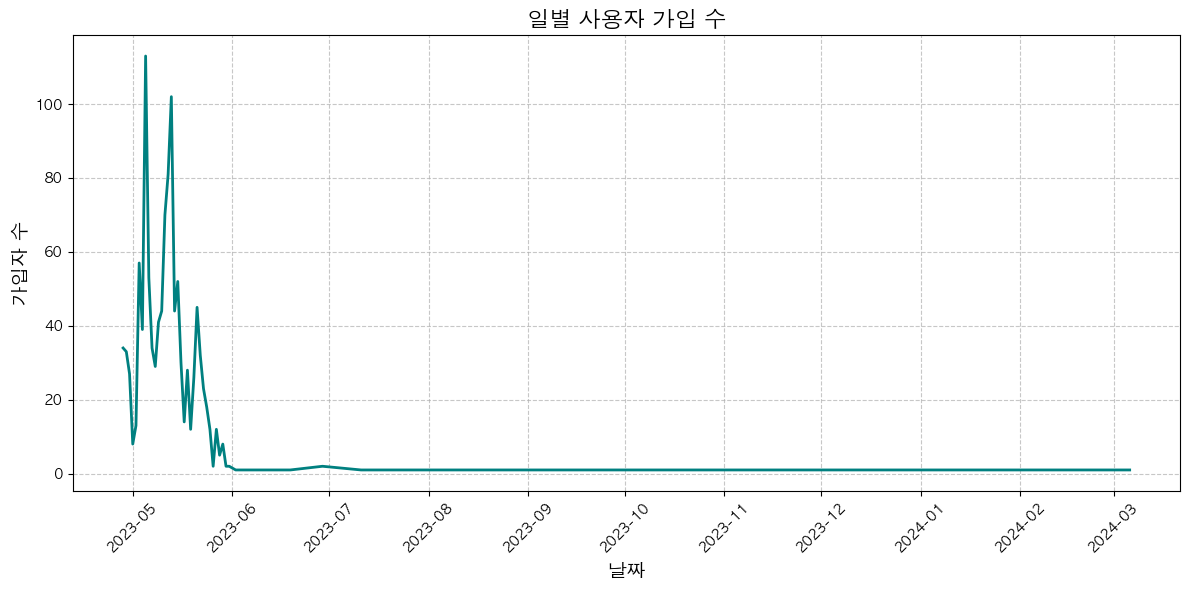

In [ ]:
# 'created_at' 열에서 날짜(Date) 추출
final_data['date'] = final_data['created_at'].dt.date

# 일별 가입자 수 집계
daily_counts = final_data.groupby('date').size()

# 일별 가입자 수 그래프 그리기
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', linestyle='-', color='teal', linewidth=2)

# 그래프 제목과 축 라벨 설정
plt.title('일별 사용자 가입 수', fontsize=16)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('가입자 수', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 5. 고착도를 통한 문제 시기 파악

### 유지율

In [ ]:
df = v_acc_atd

## datetime으로 변환
df['attendance_date'] = df['attendance_date'].apply(lambda x: pd.to_datetime(x))
df.rename(columns={'attendance_date_list': 'attendance_date'}, inplace=True)

## 유니크한 날짜값 저장
unique_dates = df['attendance_date'].drop_duplicates()

# 기준 날짜 이전의 항목만 필터링
unique_dates = [date for date in unique_dates if (date < dt.datetime(2023,7,1)) and (date > dt.datetime(2023,5,28))]

In [ ]:
## 리텐션 결과 저장
results = []

## 리텐션 계산
for date in unique_dates:
    # date가 첫번째 날인 유저의 아이디
    benchmark_users = df.loc[df.groupby('user_id')['attendance_date'].idxmin()]
    benchmark_user_ids = benchmark_users['user_id']

    # Calculate retention for Day3, Day7, Day30
    for days in [3, 7, 30]:
        target_date = date + timedelta(days=days)
        retained_users = df[
            (df['user_id'].isin(benchmark_user_ids)) &  ## 첫번째 날에도 있었고
            (df['attendance_date'] == target_date)      ## target day에도 있는 사람
        ]
        retention_rate = round(len(retained_users) / len(benchmark_user_ids)*100,2) if len(benchmark_user_ids) > 0 else 0
        results.append({
            "benchmark_date": date,
            "days": days,
            "retention_rate": retention_rate
        })

In [ ]:
# 결과표 정리하기
# DataFrame으로 변환
results_df = pd.DataFrame(results)

# 피벗 테이블로 정리해서 benchmark 날짜별 리텐션 보여주기
final_df = results_df.pivot(index='benchmark_date', columns='days', values='retention_rate')

# Rename columns for clarity
final_df.columns = [f"Day{col}_retention" for col in final_df.columns]

# Display results
display(final_df)

,Day3_retention,Day7_retention,Day30_retention
benchmark_date,,,
2023-05-29,30.43,25.75,3.16
2023-05-30,31.95,27.10,3.04
2023-05-31,33.47,17.66,2.81
2023-06-01,29.44,16.87,2.96
2023-06-02,25.75,13.94,2.98
2023-06-03,27.10,14.31,2.46
2023-06-04,17.66,14.19,2.26
2023-06-05,16.87,11.65,2.15
2023-06-06,13.94,10.02,2.02


### 고착도

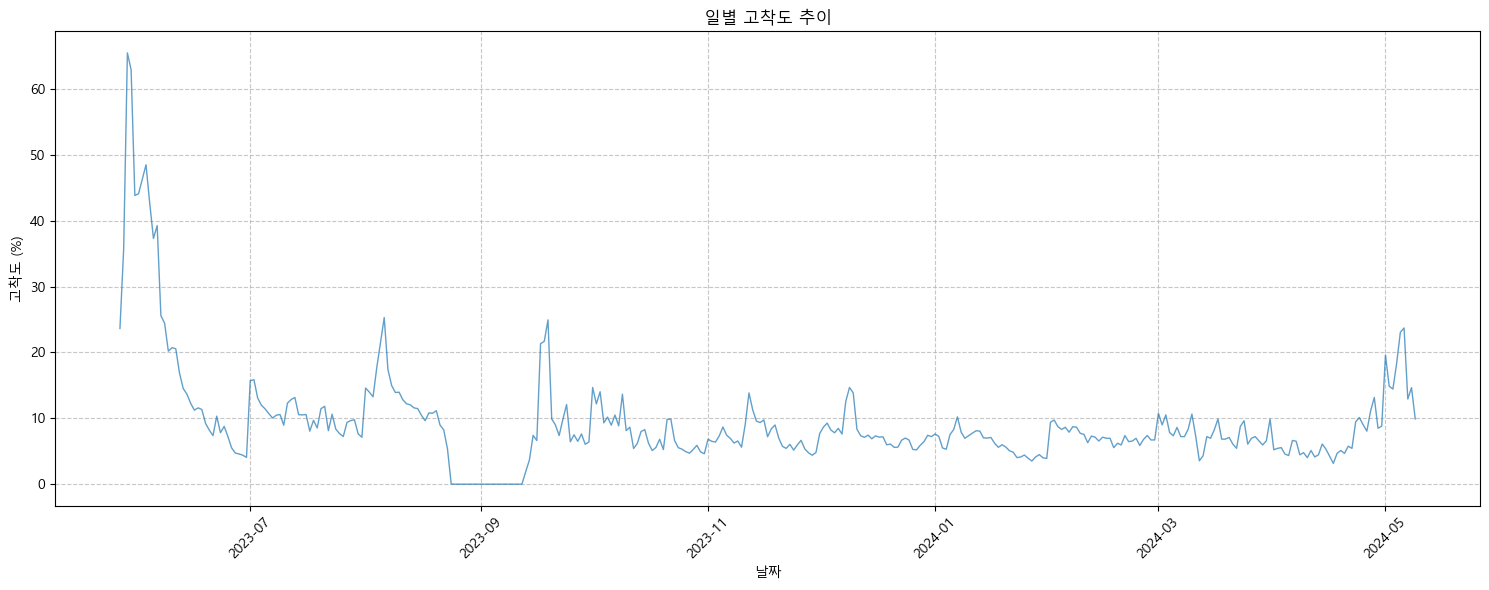

In [ ]:
daily_stats = []

v_acc_atd_df = v_acc_atd.copy()
v_acc_atd_df['attendance_date'] = pd.to_datetime(v_acc_atd_df['attendance_date'])
v_acc_atd_df['year_month'] = v_acc_atd_df['attendance_date'].dt.strftime('%Y-%m')

# 각 날짜별로 반복
for date in sorted(v_acc_atd_df['attendance_date'].unique()):
    # 월 추출
    year_month = date.strftime('%Y-%m')

    # 해당 날짜 DAU
    dau = v_acc_atd_df[v_acc_atd_df['attendance_date'] == date]['user_id'].nunique()

    # 해당 월 MAU
    month_data = v_acc_atd_df[v_acc_atd_df['year_month'] == year_month]
    mau = month_data['user_id'].nunique()

    # 고착도
    stickiness = (dau/mau) * 100

    daily_stats.append({
        'date': date,
        'year_month': year_month,
        'DAU': dau,
        'MAU': mau,
        'Stickiness': stickiness
    })

daily_stickiness_df = pd.DataFrame(daily_stats)

plt.figure(figsize=(15, 6))
plt.plot(daily_stickiness_df['date'], daily_stickiness_df['Stickiness'],
         linewidth=1, alpha=0.7)
plt.title('일별 고착도 추이')
plt.xlabel('날짜')
plt.ylabel('고착도 (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. 리뷰 크롤링 분석

In [ ]:
from app_store_scraper import AppStore
import pandas as pd
import numpy as np
import datetime as dt

# 앱스토어 객체 생성
my_app = AppStore(country='kr', app_name='HYPE', app_id='6446908786')

my_app.review()

ios_review_df = pd.DataFrame(my_app.reviews)

print(f"가져온 리뷰 수: {len(ios_review_df)}개")
ios_review_df.head()

In [ ]:
from google_play_scraper import reviews, Sort
import pandas as pd
import time

def fetch_reviews(app_id='com.zellu', num_reviews=96):
    all_reviews = []
    continuation_token = None

    while len(all_reviews) < num_reviews:
        try:
            # 리뷰 가져오기
            result, continuation_token = reviews(
                app_id,
                lang='ko',
                country='kr',
                sort=Sort.NEWEST,
                count=100,
                continuation_token=continuation_token
            )

            all_reviews.extend(result)
            print(f"현재 {len(all_reviews)}개의 리뷰를 수집했습니다.")

            if not continuation_token:  # 더 이상 가져올 리뷰가 없으면
                break

            time.sleep(4)  # API 요청 간 2초 대기

        except Exception as e:
            print(f"에러 발생: {e}")
            time.sleep(5)
            continue

    return all_reviews[:num_reviews]

# 리뷰 수집 실행
reviews_data = fetch_reviews()
reviews_df = pd.DataFrame(reviews_data)

print(f"\n총 {len(reviews_df)}개의 리뷰를 수집 완료했습니다.")
reviews_df.to_csv('../review/googleplay/zellu_googleplay_review.csv', index=False, encoding='utf-8-sig')

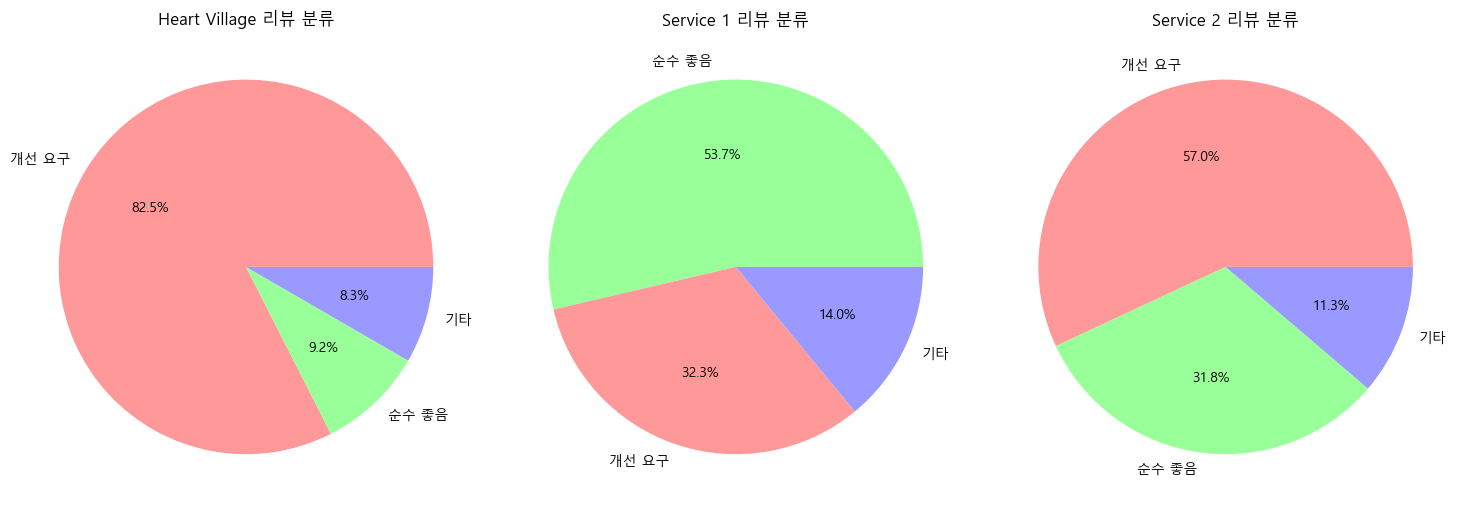


Heart Village 카테고리 분포:
category
개선 요구    702
순수 좋음     78
기타        71
Name: count, dtype: int64

Service 1 카테고리 분포:
category
순수 좋음    1013
개선 요구     610
기타        265
Name: count, dtype: int64

Service 2 카테고리 분포:
category
개선 요구    86
순수 좋음    48
기타       17
Name: count, dtype: int64


In [ ]:
improvement_subcategories = {
    "부정적 감정": [
        '빡치', '짜증', '싫어', '힘들', '힘듭니다',
        '서럽습니다', '화나네요', '미쳐가지고', '선넘네', '얼탱이가',
        '당황스럽네요', '아닌듯해요', '싸울래', '어찌하옵니까',
        '재미없어', '재밌지가않아요', '떨어지네요', '조롱', '상처', '반말',
        '어이업스'
    ],

    "개선/건의": [
        '근데', '좋은데', '조은데', '그런데'
        '개선', '좋겠', '건의', '추가', '수정', '보완',
        '말곤', '빼고', '빼고는', '빼곤',
        '제발', '좋을것', '좋을 것', '좋겟어', '좋게어요', '조을거',
        '고쳐야합니다', '고치면', '바꿔', '바꾸', '편할거같네요', '적고 싶어요',
        '좋을 거 같아요', '좋을거같아요', '좋을꺼 같아요',
        '조을거', '재미있을거'
    ],

    "기능적 불만": [
        '안돼', '안 돼요', '안돼요', '안되요', '안되여',
        '안되나요', '안될까요', '안되네', '안됩니다', '안 되는', '안되는건',
        '안되는데', '안 된다고',
        '못쓰고', '못바', '못하', '밖에', '어케', '어떻게',
        '실수', '0명', '어따', '유료', '됐으면',
        '하나두', '하나도', '없나', '이것만', '이상한', '어렵', '탈주',
        '재미가 없는 것', '다른건', '이러는 건지', '못 보는',
        '귀찮아요', '안들어와요', '안들어와', '안 들어와',
        '안 떠요', '안떠요', '안뜨', '안뜨네', '안뜨느넫', '안뜨고', '안뜨는데',
        '안보여요', '안보이고', '돈벌려고', '돈 벌려고', '눌렀는지',
        '못했는데', '못 찾아', '인증', '로그인', '로그인이',
        '너무 길어요', '해야하나요', '하라길래', '오픈이',
        '딴 건', '다 좋습', '안 되네',
        '접속할수', '접속할 수', '안남겨져', '안 남겨져',
        '못 달아', '못달아', '해지', '넘어가질',
        '작동하지', '취소되나요', '가능한가',
        '모르는 사람', '돌팔아', '어디갔죠', '열리나요', '사라졌어요',
        '불러올수없는', '불러올슈없는'
    ],

    "문제 제기": [
        '버그', '문제', '단점', '오류', '렉',
        '서버연결', '서버가', '실패', '튕김', '튕깁',
        '끊겼다', '끊겻다', '로딩이', '왜그런거죠', '왜그런',
        '왜 그런', '왜 있는', '왜이런가요', '왜구럴까',
        '왜 이러', '왜이러', '발생합니다', '그외는',
        '오래걸려요','밖에', '준비중', '로그인', '로그인이'
    ],

    "요청/제안": [
        '문의', '방법', '보시면', '답해주', '바랍니다', '필요해요',
        '있었으면', '욜어주세', '만들어주세요', '만들아주세요', '넣오주세용',
        '해주세뇨', '해주십시', '오픈좀', '오픈좀요', '열어주세',
        '오픈해', '오픈해주', '넣어주셨으면', '넣어주세',
        '섞어주세요', '줄여주세요', '도와주세요',
        '돌려주세요', '보고싶어요', '계속 로그아웃',
        '꺼주세요', '해겨뢔두세요', '언제 오픈',
        '오픈이', '언제오나', '언제 오나', '언제되나요'
    ],

    "기대 불충족/아쉬움": ['아쉬', '없을까요', '없어요', '확인할 수가',
    '없애는 것', '없애주세요',
    '모르겠어요', '모르겟어요', '모르겠어', '모르겠오',
    '알려주세요', '알려주세오', '알러주세',
    '알수있나요', '알수잇나요', '볼 수 있나요',
    '더 좋았어요', '무슨일'
    ],

    "속도/성능": [
        '느려요', '갑자기', '느리게', '기다리고', '한참이나'
    ]
}


positive_subcategories = {

    "재미/참신/중독": [
        '재밌', '재밋', '재미', '신박', '참신', '신선',
        '잼있', '재밋는', '잼잇', '쟘있', '개잼',
        '개꿀잼', '꿀잼', '꿀잰', '극락', '웃김',
        '맛도리', '중독성', '중독', '금방 가는', '제미', '신기', '새로웠'
    ],

    "좋음/만족":[
        '좋은', '좋아요', '좋네', '좋다', '좋고',
        '좋음', '좋아', '좋았어', '좋았', '만족',
        '좋습', '좋아짐', '젛아', '조음', '조아', '조어',
        '나쁘지 않다', '나쁘지않다', '괜찮', '깔끔', '추천', '최고',
        '굿', '구웃', 'Good', '나이스', '대박',
        '굳', '따봉', '대단한', '쩔어요', '쩔어',
        'b', 'OOD', 'GOO', '무조건',
        '화이팅', '흥하세요', '기모찌', '기머띠', '뭘고민해',
        'siu', 'jam', '와', '존경', '빛',  '쩜',  '굳이',
        '즐기고', '즐길', '이용',
        '쓸수', '쓸 수', '개꿀', '쓸만',
        '해볼만한', '잘 쓰고', '잘쓰고',
        '취향', '빠져', '계속 하다',
        '시간가는줄', '당장', '심심할 틈',
        '까세요', '그대로', '졸다', '느낀점',
        '안깜', '깔아',
        '할만','상', '간단히'
    ],

    "사랑/행복": [
        '사랑', '감사', '행복', '설레',
        '썸', '사겼', '고백', '유익'
    ],
    "친구/소통": [
        '친구들이랑', '친구들과', '친구', '친절', '마음', '접점',
        '소통', '선배', '인싸', '친해', '돈독', '속마음', '표현', '눈치',
        '알수있음', '알수있어요'
    ]
}

improvement_keywords = []
for kw_list in improvement_subcategories.values():
    improvement_keywords.extend(kw_list)
improvement_keywords = list(set(improvement_keywords))

positive_keywords = []
for kw_list in positive_subcategories.values():
    positive_keywords.extend(kw_list)
positive_keywords = list(set(positive_keywords))

def categorize_review(review):
    review = str(review)
    if any(keyword in review for keyword in improvement_keywords):
        return '개선 요구'
    elif any(keyword in review for keyword in positive_keywords):
        return '순수 좋음'
    return '기타'

def get_subcategory(review, main_category):

    if main_category == '개선 요구':
        for subcat, kw_list in improvement_subcategories.items():
            if any(k in review for k in kw_list):
                return subcat
        return '기타(개선 내부)'


    elif main_category == '순수 좋음':
        for subcat, kw_list in positive_subcategories.items():
            if any(k in review for k in kw_list):
                return subcat
        return '기타(긍정 내부)'

    else:
        return None

for df in [hype_emb_high, omg_emb_high, zellu_emb_high]:
    # 먼저 상위 카테고리 분류
    df['category'] = df['cleaned_review'].apply(categorize_review)

    # 세부 카테고리 분류
    df['sub_category'] = df.apply(
        lambda row: get_subcategory(row['cleaned_review'], row['category']), axis=1
    )

colors = {
    '개선 요구': '#FF9999',
    '순수 좋음': '#99FF99',
    '기타': '#9999FF'
}

plt.figure(figsize=(15, 5))

# Hype
plt.subplot(131)
hype_counts = hype_emb_high['category'].value_counts()
plt.pie(hype_counts, labels=hype_counts.index,
        colors=[colors[cat] for cat in hype_counts.index],
        autopct='%1.1f%%')
plt.title('Heart Village 리뷰 분류')

# OMG
plt.subplot(132)
omg_counts = omg_emb_high['category'].value_counts()
plt.pie(omg_counts, labels=omg_counts.index,
        colors=[colors[cat] for cat in omg_counts.index],
        autopct='%1.1f%%')
plt.title('Service 1 리뷰 분류')

# Zellu
plt.subplot(133)
zellu_counts = zellu_emb_high['category'].value_counts()
plt.pie(zellu_counts, labels=zellu_counts.index,
        colors=[colors[cat] for cat in zellu_counts.index],
        autopct='%1.1f%%')
plt.title('Service 2 리뷰 분류')

plt.tight_layout()
plt.show()

print("\nHeart Village 카테고리 분포:")
print(hype_counts)
print("\nService 1 카테고리 분포:")
print(omg_counts)
print("\nService 2 카테고리 분포:")
print(zellu_counts)

## 7. 이탈 요인 분석

### 데이터셋 준비

In [ ]:
import datetime

v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date'])

# 6월 12일 기준
target_date = datetime.date(2023, 6, 12)

atd_before_612 = v_acc_atd[v_acc_atd['attendance_date'] <= '2023-06-12']

atd_user_ids = set(atd_before_612['user_id'].unique())

vote_before_612 = v_acc_uqrec[v_acc_uqrec['created_at'] <= '2023-06-12']

vote_user_ids = set(vote_before_612['user_id'].unique())

user_df = pd.DataFrame({'user_id': list(atd_user_ids)})
user_df = user_df.sort_values('user_id').reset_index(drop=True)

vote_count = vote_before_612['user_id'].value_counts().sort_index().reset_index()
vote_count.columns = ['user_id', 'vote_count']

elected_count = vote_before_612['chosen_user_id'].value_counts().sort_index().reset_index()
elected_count.columns = ['user_id', 'elected_count']

user_df = user_df.merge(vote_count, on='user_id', how='left').fillna(0)
user_df = user_df.merge(elected_count, on='user_id', how='left').fillna(0)

atd_after_612 = v_acc_atd[v_acc_atd['attendance_date'] > '2023-06-12']

v_acc_user['friend_count'] = v_acc_user['friend_id_list'].apply(lambda x: len(x.strip('[]').split(',')) if pd.notna(x) and x != '[]' else 0)

user_df_userid = set(user_df['user_id'].unique())

v_acc_userdf = v_acc_user[v_acc_user['id'].isin(user_df_userid)]

v_acc_userdf = v_acc_userdf[['id', 'gender', 'point', 'friend_count']]

v_acc_userdf.rename(columns={'id': 'user_id'}, inplace=True)

user_df = user_df.merge(v_acc_userdf, on='user_id', how='left')

user_df['gender'].value_counts(dropna=False)

v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at'])

pay_before_612 = v_acc_pay[v_acc_pay['created_at'] <= '2023-06-12']

pay_before_612 = pay_before_612[pay_before_612['user_id'].isin(user_df_userid)]

pay_before_612.rename(columns={'productId': 'price'}, inplace=True)

rename_dict = {'heart.777':777,
               'heart.200':200,
               'heart.1000':1000,
               'heart.4000':4000}

pay_before_612['price'] = pay_before_612['price'].map(rename_dict)

pay_count = pay_before_612['user_id'].value_counts().sort_index().reset_index()
pay_count.columns = ['user_id', 'pay_count']

pay_total = pay_before_612.groupby('user_id')['price'].sum().sort_index().reset_index()
pay_total.columns = ['user_id', 'pay_total']

pay_df = pay_count.merge(pay_total, on='user_id', how='left')

user_df = user_df.merge(pay_df, on='user_id', how='left').fillna(0)

user_attendance = atd_before_612.sort_values(['user_id', 'attendance_date'])

# 각 사용자별로 이전 출석일과의 차이 계산
user_attendance['days_between'] = user_attendance.groupby('user_id')['attendance_date'].diff().dt.days

# 사용자별 평균 접속 간격 계산
user_intervals = user_attendance.groupby('user_id').agg({
    'days_between': 'mean',  # 평균 접속 간격
    'attendance_date': ['count', 'min', 'max']  # 출석 횟수, 첫 출석일, 마지막 출석일
}).reset_index()

user_intervals.columns = ['user_id', 'avg_interval', 'attendance_count', 'first_attendance', 'last_attendance']
user_intervals.drop(columns=['attendance_count', 'first_attendance', 'last_attendance'], inplace=True)
user_df = user_df.merge(user_intervals, on='user_id', how='left')

user_df['avg_interval'] = user_df['avg_interval'].fillna(0)

# 사용자별 최대 접속 간격 계산
user_intervals = user_attendance.groupby('user_id').agg({
    'days_between': 'max',  # 최대 접속 간격
    'attendance_date': ['count', 'min', 'max']  # 출석 횟수, 첫 출석일, 마지막 출석일
}).reset_index()

user_intervals.columns = ['user_id', 'max_interval', 'attendance_count', 'first_attendance', 'last_attendance']
user_intervals.drop(columns=['first_attendance', 'last_attendance'], inplace=True)
user_df = user_df.merge(user_intervals, on='user_id', how='left')

# NaN 값 처리
user_df['max_interval'] = user_df['max_interval'].fillna(0)
user_df['attendance_count'] = user_df['attendance_count'].fillna(0)


base_date = pd.to_datetime('2023-06-13')

# avg_interval 이내에 출석한 경우
# 6월 12일 이후 각 사용자의 첫 출석일 확인
after_612_first_attendance = atd_after_612.groupby('user_id')['attendance_date'].min().reset_index()
after_612_first_attendance['attendance_date'] = pd.to_datetime(after_612_first_attendance['attendance_date'])

# 6월 12일부터 첫 출석까지의 간격 계산
after_612_first_attendance['days_until_first_attendance'] = (after_612_first_attendance['attendance_date'] - base_date).dt.days

user_df = user_df.merge(after_612_first_attendance[['user_id', 'days_until_first_attendance']],
                       on='user_id',
                       how='left')

# max_interval 이내에 출석한 경우
# 이탈 여부 판단
user_df['is_breakaway'] = ~(
    (user_df['days_until_first_attendance'] >= 0) &  # 6월 12일 이후 첫 출석일이 존재하고
    (user_df['days_until_first_attendance'] <= user_df['avg_interval'])  # avg_interval 이내에 출석한 경우
)

user_df = user_df.drop('days_until_first_attendance', axis=1)

user_df = user_df.merge(after_612_first_attendance[['user_id', 'days_until_first_attendance']],
                       on='user_id',
                       how='left')

# 이탈 여부 판단
user_df['is_breakaway_plenty'] = ~(
    (user_df['days_until_first_attendance'] >= 0) &  # 6월 12일 이후 첫 출석일이 존재하고
    (user_df['days_until_first_attendance'] <= user_df['max_interval'])  # max_interval 이내에 출석한 경우
)

user_df = user_df.drop('days_until_first_attendance', axis=1)

# 이탈 유저의 평균 출석 간격을 365일로 설정
user_df.loc[(user_df['avg_interval'] == 0) & (user_df['is_breakaway'] == True), 'avg_interval'] = 365
user_df.loc[(user_df['max_interval'] == 0) & (user_df['is_breakaway_plenty'] == True), 'max_interval'] = 365

gender_int = {'M': 0, 'F': 1}
user_df['gender'] = user_df['gender'].map(gender_int)

delta_point_df = v_acc_point.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).reset_index()

user_df = user_df.merge(delta_point_df, on='user_id', how='left').fillna(0)

df1 = v_acc_uqrec.groupby('user_id')['status'].value_counts().sort_index().reset_index()

df1 = df1[df1['status'] == 'I']

df1.rename(columns={'count': 'hint_count'}, inplace=True)
df1.drop(columns=['status'], inplace=True)
user_df = user_df.merge(df1, on='user_id', how='left').fillna(0)

use_point = v_acc_point[v_acc_point['delta_point'] < 0]
user_use_point = use_point.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).reset_index()
user_use_point.rename(columns={'delta_point': 'use_point'}, inplace=True)
user_df = user_df.merge(user_use_point, on='user_id', how='left').fillna(0)

user_df['hint_open_ratio'] = np.where(user_df['elected_count'] == 0, 0, user_df['hint_count'] / user_df['elected_count'])
user_df['vote_survice_use_score'] = user_df['vote_count'] * 2 + user_df['elected_count']

# 투표를 이성에게 받았는지 동성에게 받았는지 확인
chosen_df = v_acc_uqrec[['chosen_user_id', 'user_id', 'question_id']]
chosen_df.rename(columns={'user_id': 'pick_user_id'}, inplace=True)

gender_df = v_acc_user[['id', 'gender']]


chosen_df = chosen_df.merge(gender_df, left_on='chosen_user_id', right_on='id', how='left')
chosen_df.rename(columns={'gender': 'chosen_gender'}, inplace=True)

chosen_df = chosen_df.merge(gender_df, left_on='pick_user_id', right_on='id', how='left')
chosen_df.rename(columns={'gender': 'pick_gender'}, inplace=True)
chosen_df.head()

chosen_df.drop(columns=['id_x', 'id_y'], inplace=True)

chosen_df['is_same_gender'] = chosen_df['chosen_gender'] == chosen_df['pick_gender']

동성_선택 = chosen_df.groupby('chosen_user_id')['is_same_gender'].apply(lambda x: sum(x))
이성_선택 = chosen_df.groupby('chosen_user_id')['is_same_gender'].apply(lambda x: sum(~x))

gender_counts = pd.DataFrame({
    'same_gender': 동성_선택,
    'diff_gender': 이성_선택
})

chosen_df = chosen_df.merge(
    gender_counts,
    left_on='chosen_user_id',
    right_index=True,
    how='left'
)

chosen_df['total_selected'] = chosen_df['same_gender'] + chosen_df['diff_gender']
chosen_df['same_gender_ratio'] = (chosen_df['same_gender'] / chosen_df['total_selected']).round(3)
chosen_df['diff_gender_ratio'] = (chosen_df['diff_gender'] / chosen_df['total_selected']).round(3)

chosen_df_merge = chosen_df[['chosen_user_id', 'same_gender', 'diff_gender', 'same_gender_ratio', 'diff_gender_ratio']]

chosen_df_merge.rename(columns={'chosen_user_id': 'user_id'}, inplace=True)

user_df = user_df.merge(chosen_df_merge, on='user_id', how='left').fillna(0)

user_df = user_df[['user_id', 'vote_count', 'elected_count', 'same_gender', 'diff_gender', 'same_gender_ratio', 'diff_gender_ratio',
         'gender', 'friend_count', 'pay_count', 'avg_interval', 'attendance_count', 'hint_count', 'use_point',
         'hint_open_ratio','is_breakaway_plenty']]
user_df.drop_duplicates(inplace=True)
user_df.head(3)

C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_acc_user['friend_count'] = v_acc_user['friend_id_list'].apply(lambda x: len(x.strip('[]').split(',')) if pd.notna(x) and x != '[]' else 0)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen_df.rename(columns={'user_id': 'pick_user_id'}, inplace=True)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\2699142002.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy

,user_id,vote_count,elected_count,same_gender,diff_gender,same_gender_ratio,diff_gender_ratio,gender,friend_count,pay_count,avg_interval,attendance_count,hint_count,use_point,hint_open_ratio,is_breakaway_plenty
0,832151,0.0,0.0,0.0,0.0,0.0,0.0,0,51,0.0,365.0,1,0.0,0.0,0.0,True
1,832340,0.0,0.0,0.0,0.0,0.0,0.0,1,57,0.0,1.0,2,0.0,0.0,0.0,True
2,832986,0.0,0.0,0.0,0.0,0.0,0.0,0,18,0.0,365.0,1,0.0,0.0,0.0,True


### 이탈 요인 분석(XGBoost)

클래스 분포:
is_breakaway_plenty
True     0.836802
False    0.163198
Name: proportion, dtype: float64


[I 2025-01-13 02:12:17,065] A new study created in memory with name: no-name-dfd6cd41-eb05-44b8-a5f3-b05d105bd53c



SMOTE 적용 후 클래스 분포:
is_breakaway_plenty
True     0.5
False    0.5
Name: proportion, dtype: float64


[I 2025-01-13 02:12:40,152] Trial 0 finished with value: 0.9893842356445411 and parameters: {'learning_rate': 0.022446956015044636, 'n_estimators': 808, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.6065296258106467, 'colsample_bytree': 0.6944231570945523, 'gamma': 4.269586132085918, 'reg_alpha': 7.586450837147328e-06, 'reg_lambda': 5.7261620610141104e-05}. Best is trial 0 with value: 0.9893842356445411.
[I 2025-01-13 02:12:52,492] Trial 1 finished with value: 0.9869442471982289 and parameters: {'learning_rate': 0.23038030766098713, 'n_estimators': 904, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6228860076011007, 'colsample_bytree': 0.5372353183106423, 'gamma': 2.7622024630369975, 'reg_alpha': 1.3540345291734246e-08, 'reg_lambda': 0.0077213732493527}. Best is trial 0 with value: 0.9893842356445411.
[I 2025-01-13 02:12:57,716] Trial 2 finished with value: 0.9503171658840938 and parameters: {'learning_rate': 0.02882382046120371, 'n_estimators': 207, 'max_depth': 4, 'm

Best trial:
  AUC: 0.9922
  Best hyperparameters: 
    learning_rate: 0.1439493694804499
    n_estimators: 793
    max_depth: 10
    min_child_weight: 1
    subsample: 0.6007563517093372
    colsample_bytree: 0.7552973062478188
    gamma: 0.7385211567253511
    reg_alpha: 0.044477283894106795
    reg_lambda: 4.603089407617221e-05

Optuna 최적화 모델 성능 평가:
Accuracy: 0.9368
Precision: 0.9756
Recall: 0.9482
F1 Score: 0.9617
ROC AUC: 0.9812


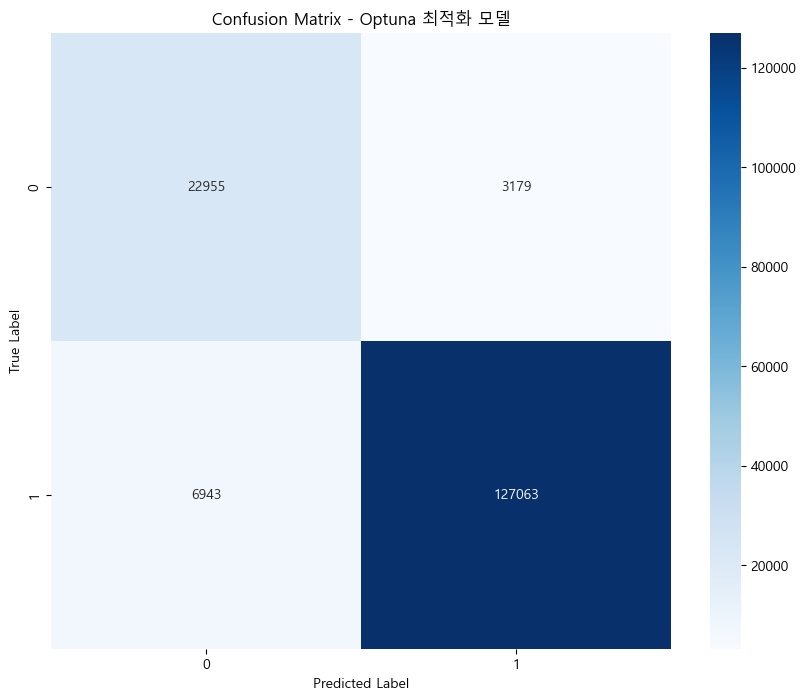

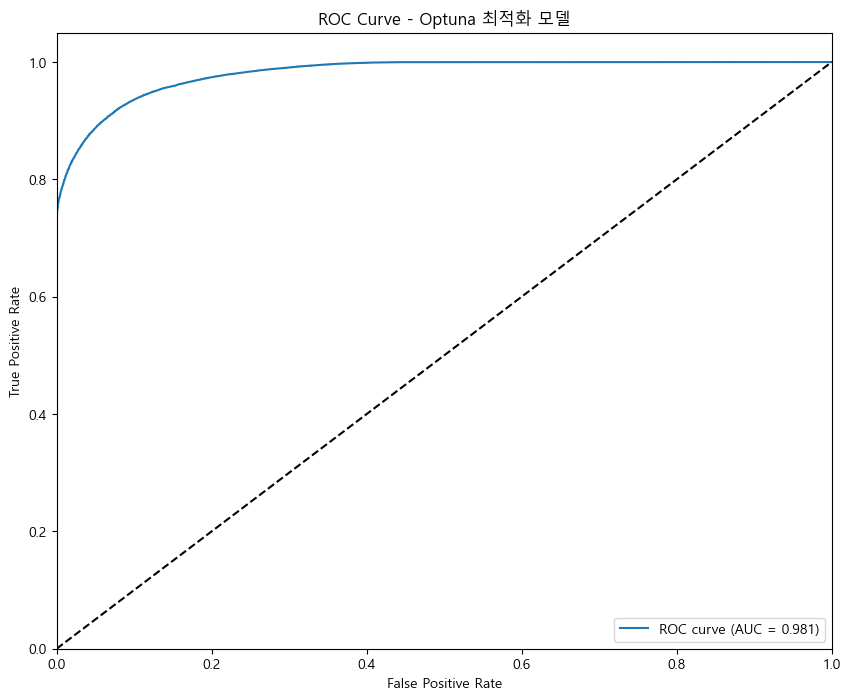

<Figure size 1000x600 with 0 Axes>

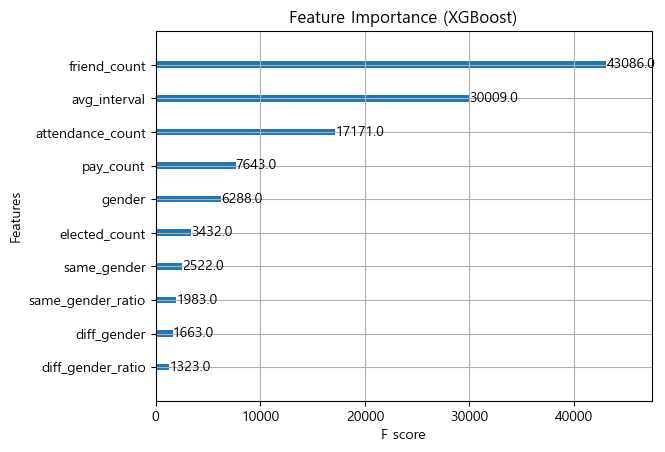

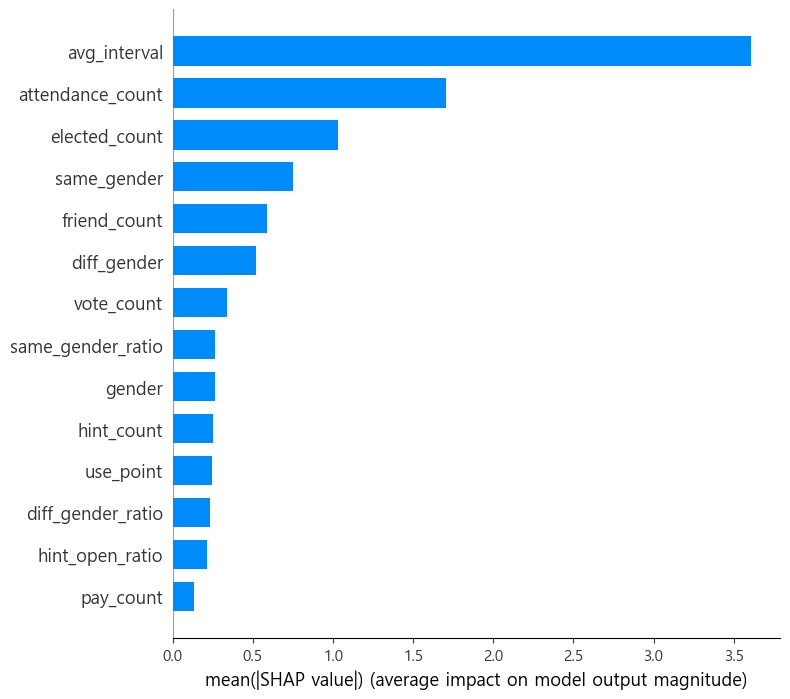

<Figure size 1000x600 with 0 Axes>

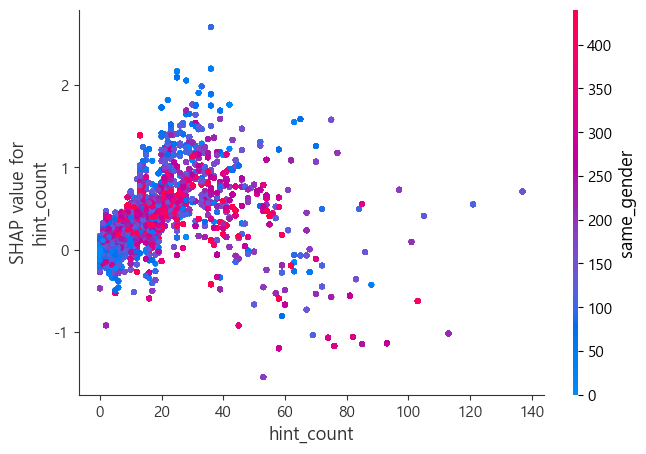

<Figure size 1000x600 with 0 Axes>

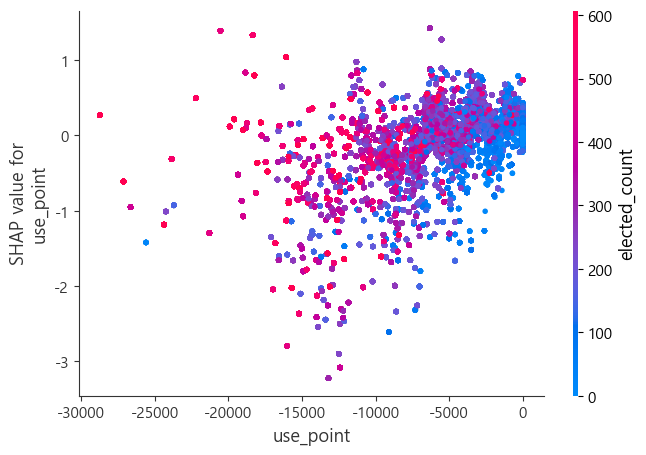

<Figure size 1000x600 with 0 Axes>

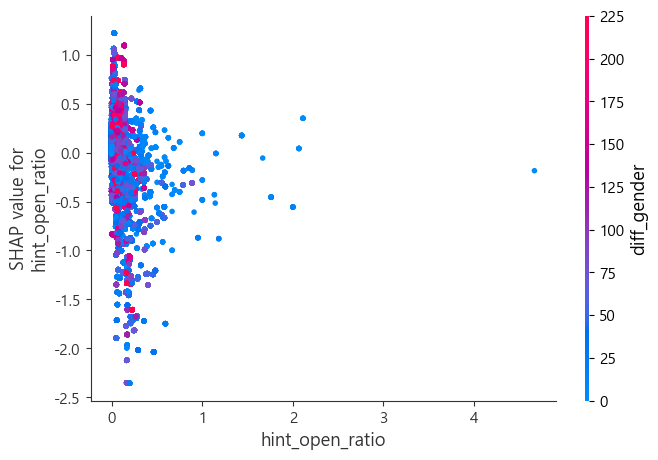

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import shap
from imblearn.over_sampling import SMOTE
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import StratifiedKFold

drop_columns = ['user_id']
X = user_df.drop(drop_columns + ['is_breakaway_plenty'], axis=1)
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("클래스 분포:")
print(y_train.value_counts(normalize=True))

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'tree_method': 'gpu_hist',  # GPU 사용
        'gpu_id': 0,  # GPU 장치 번호

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1]),
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)

    # 5-Fold 교차 검증
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc', n_jobs=-1)

    return auc_scores.mean()

# Optuna 스터디 생성 시 더 많은 trials 설정
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)

print("Best trial:")
trial = study.best_trial

print(f"  AUC: {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['use_label_encoder'] = False
best_params['scale_pos_weight'] = len(y_train_resampled[y_train_resampled==0]) / len(y_train_resampled[y_train_resampled==1])
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# 모델 평가 함수 (이미 제공된 evaluate_model 함수 사용)
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} 성능 평가:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model

evaluate_model(best_model, X_test, y_test, "Optuna 최적화 모델")

# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# SHAP Dependence Plot
feature_importance = pd.DataFrame({'feature': X.columns,
                                 'importance': best_model.feature_importances_})
top_features = feature_importance.nlargest(3, 'importance')['feature'].values

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test)
    plt.show()

## 8. 세그먼트 분류 및 그룹화

In [ ]:
#데이터 복사
v_acc_atd
atd_copy = v_acc_atd.copy()

In [ ]:
#출석 데이터
# 데이터 복제
atd_copy = v_acc_atd.copy()

#출석 리스트 형식 푸르기
atd_df = atd_copy.explode('attendance_date_list', ignore_index=True)

#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
atd_df['attendance_date_list'] = pd.to_datetime(atd_df['attendance_date_list'])
filtered_atd = atd_df[atd_df['attendance_date_list'] < cutoff_date]

#유저별 출석 횟수 계산
att_cnt = filtered_atd.groupby('user_id').size().reset_index(name = 'attendance_count')

# 출석 횟수의 사분위수 계산
Q1 = att_cnt['attendance_count'].quantile(0.25)
Q2 = att_cnt['attendance_count'].quantile(0.5)  # 중앙값
Q3 = att_cnt['attendance_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
att_cnt['quartile_label'] = att_cnt['attendance_count'].apply(assign_quartile_label)


#친구데이터
#친구 수에 필요한 컬럼만 가져오기
friend_df = v_acc_user[['id','friend_id_list']]

#att_cnt에 있는 user_id 추출
user_list = att_cnt.user_id.tolist()

#friend_df에서 att_cnt에 있는 user_id만 추출
filter_friend_df = friend_df[friend_df.id.isin(user_list)]
filter_friend_df


import ast
#리스트 형식 푸르기
filter_friend_df = filter_friend_df.explode('friend_id_list', ignore_index=True)

# 친구 아이디 리스트 개수 세기
def count_friends(friend_list_str):
    # 문자열을 리스트로 변환
    friend_list = ast.literal_eval(friend_list_str)
    # 리스트의 길이 반환
    return len(friend_list)

# 새로운 컬럼 '친구수' 추가
filter_friend_df['친구수'] = filter_friend_df['friend_id_list'].apply(count_friends)

# 친구 수의 사분위수 계산
Q1 = filter_friend_df['친구수'].quantile(0.25)
Q2 = filter_friend_df['친구수'].quantile(0.5)  # 중앙값
Q3 = filter_friend_df['친구수'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
filter_friend_df['quartile_label'] = filter_friend_df['친구수'].apply(assign_quartile_label)

use_friend_df = filter_friend_df[['id','친구수','quartile_label']]
use_friend_df = use_friend_df.rename(columns = {'id':'user_id',
                                                'quartile_label':'quartile_label_f'})

#친구수, 출석수 합치기
final_df = pd.merge(use_friend_df, att_cnt, on = 'user_id', how = 'inner')

#컬럼 순서 바꾸기
final_df = final_df[['user_id','친구수','attendance_count','quartile_label_f','quartile_label']]

df = final_df
# 'quartile_label_f'와 'quartile_label'을 합쳐서 'group' 컬럼 생성
df['group'] = df['quartile_label_f'] + '-' + df['quartile_label']

# groupname 컬럼 생성
def classify_group(row):
    if row['group'] in ['Q1-Q2', 'Q2-Q1', 'Q1-Q1']:
        return '친구 low, 활동 low'
    elif row['group'] in ['Q3-Q3', 'Q2-Q3', 'Q3-Q2', 'Q2-Q2']:
        return '친구 middle, 활동 middle'
    elif row['group'] in ['Q3-Q4', 'Q4-Q3', 'Q4-Q4']:
        return '친구 high, 활동 high'
    elif row['group'] in ['Q4-Q1', 'Q4-Q2', 'Q3-Q1']:
        return '친구 high, 활동 low'
    elif row['group'] in ['Q1-Q4', 'Q2-Q4', 'Q1-Q3']:
        return '친구 low, 활동 high'
    else:
        return '미분류'  # 예외처리

# 'groupname' 컬럼 생성
df['groupname'] = df.apply(classify_group, axis=1)

use_df = df[['user_id','groupname']]



In [ ]:
use_df

,user_id,groupname
0,832151,"친구 low, 활동 low"
1,832340,"친구 high, 활동 low"
2,832986,"친구 low, 활동 low"
3,833041,"친구 high, 활동 high"
4,833154,"친구 high, 활동 low"
...,...,...
303234,1575079,"친구 high, 활동 low"
303235,1575080,"친구 low, 활동 low"
303236,1575082,"친구 low, 활동 low"
303237,1575092,"친구 low, 활동 low"


## 9. 페르소나

### 9-1. 페르소나별 활동지수

#### 9-1-1. 활동지수 추출(메인)-민혁

##### 데이터셋 준비 및 가중치 계산

In [ ]:
## 위의 머신러닝 코드의 user_df사용
atd_q1 = user_df['attendance_count'].quantile(0.25)
atd_q2 = user_df['attendance_count'].quantile(0.5)
atd_q3 = user_df['attendance_count'].quantile(0.75)

frd_q1 = user_df['friend_count'].quantile(0.25)
frd_q2 = user_df['friend_count'].quantile(0.5)
frd_q3 = user_df['friend_count'].quantile(0.75)

def assign_attendance_score(x):
    if x < atd_q1:
        return 'a1'
    elif x < atd_q2:
        return 'a2'
    elif x < atd_q3:
        return 'a3'
    else:
        return 'a4'

def assign_friend_score(x):
    if x < frd_q1:
        return 'f1'
    elif x < frd_q2:
        return 'f2'
    elif x < frd_q3:
        return 'f3'
    else:
        return 'f4'

user_df['attendance_score'] = user_df['attendance_count'].apply(assign_attendance_score)
user_df['friend_score'] = user_df['friend_count'].apply(assign_friend_score)
user_df['group'] = user_df['attendance_score'] + user_df['friend_score']
user_df.drop(columns=['attendance_score', 'friend_score'], inplace=True)

def classify_group(row):
    if row['group'] in ['a1f2', 'a2f1', 'a1f1']:
        return '잠꾸러기 여행자'
    elif row['group'] in ['a3f3', 'a2f3', 'a3f2', 'a2f2']:
        return '여유로운 마을 지킴이'
    elif row['group'] in ['a3f4', 'a4f3', 'a4f4']:
        return '열정적인 작가'
    elif row['group'] in ['a4f1', 'a4f2', 'a3f1']:
        return '호기심 많은 탐험가'
    elif row['group'] in ['a1f4', 'a2f4', 'a1f3']:
        return '인기쟁이 수집가'

user_df['groupname'] = user_df.apply(classify_group, axis=1)
user_df.drop(columns=['group'], inplace=True)

## 각각 가중치 확인
# 인기 관련
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = user_df[['friend_count', 'elected_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'friend Count Weight: {weights[0]}, Elected Count Weight: {weights[1]}')

# 투표관련
X = user_df[['vote_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'vote Count Weight: {weights[0]}')

# 출석 관련
X = user_df[['attendance_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'attendance Count Weight: {weights[0]}')

# 결제 관련
X = user_df[['pay_count']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'pay Count Weight: {weights[0]}')

# 활동 관련
X = user_df[['hint_count', 'use_point']]
y = user_df['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0]
print(f'hint Count Weight: {weights[0]}, use Point Weight: {weights[1]}')

friend Count Weight: -0.00034402244669326417, Elected Count Weight: 0.0014629408306261514
vote Count Weight: 2.18726460638712e-05
attendance Count Weight: -0.3864789185831365
pay Count Weight: -0.09176883845932361
hint Count Weight: -0.003896264950562928, use Point Weight: -1.3330612328535801e-05


##### 활동지수 추출

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


df_group = user_df.groupby('groupname')[['vote_count', 'friend_count', 'elected_count', 'attendance_count', 'pay_count', 'hint_count', 'use_point', 'is_breakaway_plenty']].mean()

# 가중치 - 이탈에 영향 미친 항목도 활동 했으면 긍정적으로 평가, 로지스틱 회귀로 가중치 구함
adjusted_weights = {
    'vote_count': 0.0000218726460638712,
    'friend_count': 0.00034402244669326417,
    'elected_count': 0.0014629408306261514,
    'attendance_count': 0.38647891858313653859022359097301,
    'pay_count': 0.09134486684907289,
    'hint_count': 0.003896264950562928,
    'use_point': -0.000013330612328535801
}

# 카테고리별 가중치 합계
category_weights = {
    'vote_related': adjusted_weights['vote_count'],
    'popularity_related': adjusted_weights['friend_count'] + adjusted_weights['elected_count'],
    'attendance_related': adjusted_weights['attendance_count'],
    'payment_related': adjusted_weights['pay_count'],
    'usage_related': adjusted_weights['hint_count'] + adjusted_weights['use_point']
}

# 총 가중치 합계
total_category_weight = sum(category_weights.values())

# 카테고리별 점수 - 카테고리별 만점은 100점
category_max_scores = {
    'vote_related': 100,         # 투표 관련
    'popularity_related': 100,  # 인기 관련
    'attendance_related': 100,   # 출석 관련
    'payment_related': 100,     # 결제 관련
    'usage_related': 100         # 사용 관련
}

# 각 카테고리 내 점수 계산 및 스케일링
# 투표 관련
vote_features = ['vote_count']
df_group['vote_raw'] = df_group[vote_features].dot([adjusted_weights['vote_count']])
scaler_vote = MinMaxScaler(feature_range=(20, category_max_scores['vote_related']))
df_group['vote_score'] = scaler_vote.fit_transform(df_group[['vote_raw']])

# 인기 관련
popularity_features = ['friend_count', 'elected_count']
df_group['popularity_raw'] = df_group[popularity_features].dot([adjusted_weights['friend_count'], adjusted_weights['elected_count']])
scaler_popularity = MinMaxScaler(feature_range=(20, category_max_scores['popularity_related']))
df_group['popularity_score'] = scaler_popularity.fit_transform(df_group[['popularity_raw']])

# 출석 관련
attendance_features = ['attendance_count']
df_group['attendance_raw'] = df_group['attendance_count'] * adjusted_weights['attendance_count']
scaler_attendance = MinMaxScaler(feature_range=(20, category_max_scores['attendance_related']))
df_group['attendance_score'] = scaler_attendance.fit_transform(df_group[['attendance_raw']])

# 결제 관련
payment_features = ['pay_count']
df_group['payment_raw'] = df_group[payment_features].dot([adjusted_weights['pay_count']])
scaler_payment = MinMaxScaler(feature_range=(20, category_max_scores['payment_related']))
df_group['payment_score'] = scaler_payment.fit_transform(df_group[['payment_raw']])

# 사용 관련
usage_features = ['hint_count', 'use_point']
df_group['usage_raw'] = df_group[usage_features].dot([adjusted_weights['hint_count'], adjusted_weights['use_point']])
scaler_usage = MinMaxScaler(feature_range=(20, category_max_scores['usage_related']))
df_group['usage_score'] = scaler_usage.fit_transform(df_group[['usage_raw']])

# 최종 활동 점수
df_group['activity_score'] = (
    df_group['vote_score'] +
    df_group['popularity_score'] +
    df_group['attendance_score'] +
    df_group['payment_score'] +
    df_group['usage_score']
)

df_group.drop(columns=['vote_raw', 'popularity_raw', 'attendance_raw', 'payment_raw', 'usage_raw'], inplace=True)
df_group['activity_score'].head()

groupname
여유로운 마을 지킴이    250.155970
열정적인 작가        494.909338
인기쟁이 수집가       329.749591
잠꾸러기 여행자       100.000000
호기심 많은 탐험가     258.316238
Name: activity_score, dtype: float64

#### 9-1-2. 활동지수 추출(서브) - 참고용

In [ ]:
# 데이터 복제
atd_df = v_acc_atd.copy()

#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
atd_df['attendance_date'] = pd.to_datetime(atd_df['attendance_date'])
filtered_atd = atd_df[atd_df['attendance_date'] < cutoff_date]

#유저별 출석 횟수 계산
att_cnt = filtered_atd.groupby('user_id').size().reset_index(name = 'attendance_count')

# 출석 횟수의 사분위수 계산
Q1 = att_cnt['attendance_count'].quantile(0.25)
Q2 = att_cnt['attendance_count'].quantile(0.5)  # 중앙값
Q3 = att_cnt['attendance_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
att_cnt['quartile_label'] = att_cnt['attendance_count'].apply(assign_quartile_label)

In [ ]:
#친구데이터
#친구 수에 필요한 컬럼만 가져오기
friend_df = v_acc_user[['id','friend_id_list']]

#att_cnt에 있는 user_id 추출
user_list = att_cnt.user_id.tolist()

#friend_df에서 att_cnt에 있는 user_id만 추출
filter_friend_df = friend_df[friend_df.id.isin(user_list)]
filter_friend_df

,id,friend_id_list
2,832151,"[838785, 982531, 882567, 879496, 838541, 83649..."
3,832340,"[841345, 982531, 838785, 963714, 882567, 83252..."
10,832986,"[838785, 1426466, 874050, 832740, 832894, 8326..."
12,833041,"[841345, 982531, 838785, 882567, 832520, 87949..."
15,833154,"[862215, 868366, 860692, 870935, 858135, 88579..."
...,...,...
669102,1575079,"[1572864, 1568002, 1572740, 1524356, 1524483, ..."
669103,1575080,"[1323527, 941080, 1091737, 1221402, 1575582, 1..."
669105,1575082,"[1184771, 1571971, 1552521, 1291532, 1571853, ..."
669113,1575092,"[1573219, 1571971, 1573415, 1572360, 1575082, ..."


In [ ]:
# friend_id_list를 문자열에서 리스트로 변환
filter_friend_df['friend_id_list'] = filter_friend_df['friend_id_list'].apply(
    lambda x: x.strip('[]').split(', ') if isinstance(x, str) and x.startswith('[') else []
)

# friend_id_list의 각 요소를 숫자로 변환 (빈 리스트는 그대로 유지)
filter_friend_df['friend_id_list'] = filter_friend_df['friend_id_list'].apply(
    lambda x: [int(friend) for friend in x if friend.isdigit()]
)

# friend_id_list에서 친구 수 계산
filter_friend_df['friend_count'] = filter_friend_df['friend_id_list'].apply(len)

# 친구 수의 사분위수 계산
Q1 = filter_friend_df['friend_count'].quantile(0.25)
Q2 = filter_friend_df['friend_count'].quantile(0.5)  # 중앙값
Q3 = filter_friend_df['friend_count'].quantile(0.75)

# 분위수 라벨링 함수
def assign_quartile_label_f(x):
    if x <= Q1:
        return 'Q1'  # 1사분위수
    elif x <= Q2:
        return 'Q2'  # 2사분위수
    elif x <= Q3:
        return 'Q3'  # 3사분위수
    else:
        return 'Q4'  # 4사분위수

# 새로운 컬럼 'quartile_label' 추가
filter_friend_df['quartile_label'] = filter_friend_df['friend_count'].apply(assign_quartile_label_f)

use_friend_df = filter_friend_df[['id','friend_count','quartile_label']]

In [ ]:
use_friend_df = use_friend_df.rename(columns = {'id':'user_id',
                                                'quartile_label':'quartile_label_f'})

#친구수, 출석수 합치기
final_df = pd.merge(use_friend_df, att_cnt, on = 'user_id', how = 'inner')

#컬럼 순서 바꾸기
final_df = final_df[['user_id','friend_count','attendance_count','quartile_label_f','quartile_label']]

In [ ]:
df = final_df
# 'quartile_label_f'와 'quartile_label'을 합쳐서 'group' 컬럼 생성
df['group'] = df['quartile_label_f'] + '-' + df['quartile_label']

In [ ]:
# groupname 컬럼 생성
def classify_group(row):
    if row['group'] in ['Q1-Q2', 'Q2-Q1', 'Q1-Q1']:
        return '친구 low, 활동 low'
    elif row['group'] in ['Q3-Q3', 'Q2-Q3', 'Q3-Q2', 'Q2-Q2']:
        return '친구 middle, 활동 middle'
    elif row['group'] in ['Q3-Q4', 'Q4-Q3', 'Q4-Q4']:
        return '친구 high, 활동 high'
    elif row['group'] in ['Q4-Q1', 'Q4-Q2', 'Q3-Q1']:
        return '친구 high, 활동 low'
    elif row['group'] in ['Q1-Q4', 'Q2-Q4', 'Q1-Q3']:
        return '친구 low, 활동 high'
    else:
        return '미분류'  # 예외처리

In [ ]:
# 'groupname' 컬럼 생성
df['groupname'] = df.apply(classify_group, axis=1)

use_df = df[['user_id','friend_count','attendance_count','groupname']]
use_df

,user_id,friend_count,attendance_count,groupname
0,832151,51,1,"친구 low, 활동 low"
1,832340,57,2,"친구 high, 활동 low"
2,832986,18,1,"친구 low, 활동 low"
3,833041,67,9,"친구 high, 활동 high"
4,833154,126,1,"친구 high, 활동 low"
...,...,...,...,...
303234,1575079,71,1,"친구 high, 활동 low"
303235,1575080,22,1,"친구 low, 활동 low"
303236,1575082,45,1,"친구 low, 활동 low"
303237,1575092,23,1,"친구 low, 활동 low"


- 투표횟수

In [ ]:
v_uqrec = v_uqrec[v_uqrec['created_at'] <= '2023-06-12']

# 사용자별 투표 빈도 계산
vote_frequency = v_uqrec.groupby('user_id').size().reset_index(name='vote_count')

# use_df와 결합
group_table = use_df.merge(vote_frequency, on='user_id', how='left')

# 결측치 처리 (투표 횟수가 없는 경우 0으로 처리)
group_table['vote_count'].fillna(0, inplace=True)

group_table['vote_count'] = group_table['vote_count'].astype(int)

- 투표 받은 횟수

In [ ]:
# 사용자별 chosen_user_id 빈도 계산
elected_counts = v_uqrec.groupby('chosen_user_id').size().reset_index(name='elected_count')

# group_table에 chosen_count 컬럼 추가, 겹치지 않는 경우 0으로 처리
group_table = pd.merge(group_table, elected_counts, left_on='user_id', right_on='chosen_user_id', how='left')
group_table['elected_count'] = group_table['elected_count'].fillna(0).astype(int)

# chosen_user_id 매핑에 사용한 컬럼 제거
group_table = group_table.drop(columns=['chosen_user_id'])

- 결제 횟수

In [ ]:
v_pay =  v_acc_pay[v_acc_pay['created_at'] <= '2023-06-12']

# 사용자별 pay_user_id 빈도 계산
pay_counts = v_pay.groupby('user_id').size().reset_index(name='pay_count')

# group_table에 pay_count 컬럼 추가, 겹치지 않는 경우 0으로 처리
group_table = pd.merge(group_table, pay_counts, on='user_id', how='left')

group_table['pay_count'] = group_table['pay_count'].fillna(0).astype(int)

- 초성힌트 사용 횟수

In [ ]:
# 사용자별 초성힌트 사용 횟수를 계산
# status가 I인 경우만 필터링하여 카운트
user_initial_hint_usage = v_uqrec[v_uqrec['status'] == 'I'].groupby('user_id').size().reset_index(name='hint_count')

# 중심이 되는 그룹 테이블과 병합
group_table = group_table.merge(
    user_initial_hint_usage,
    on='user_id',
    how='left'
)

# 초성 힌트 사용 횟수가 없는 경우 0으로 설정
group_table['hint_count'] = group_table['hint_count'].fillna(0).astype(int)

- 포인트 사용량

In [ ]:
# 사용자별 포인트 사용 횟수 계산
v_point =v_acc_point[v_acc_point['created_at'] <= '2023-06-12']

# delta_point가 음수인 경우만 필터링하고 절댓값 처리
negative_points = v_point[v_point['delta_point'] < 0].copy()
negative_points['abs_delta_point'] = negative_points['delta_point'].abs()

# 사용자별 포인트 사용량 합산
user_point_usage = negative_points.groupby('user_id')['abs_delta_point'].sum().reset_index()
user_point_usage.rename(columns={"abs_delta_point": "use_point"}, inplace=True)

# use_df에 포인트 사용량 추가 (기본값 0 처리)
group_table = group_table.merge(user_point_usage, on="user_id", how="left")
group_table['use_point'] = group_table['use_point'].fillna(0).astype(int)

- 활성지수 계산

In [ ]:
# 데이터를 복사하여 작업
ai_data = group_table.copy()

# 점수 환산 함수: min-max 스케일링
def scale_to_range(series, min_val, max_val):
    return ((series - series.min()) / (series.max() - series.min())) * (max_val - min_val) + min_val

# 투표 관련 점수 (투표 횟수 -> 0~100)
ai_data['vote_score'] = scale_to_range(ai_data['vote_count'], 0, 100)

# 인기 관련 점수 (친구 수와 뽑힌 횟수 각각 -> 0~50)
ai_data['friend_score'] = scale_to_range(ai_data['friend_count'], 0, 50)
ai_data['elected_score'] = scale_to_range(ai_data['elected_count'], 0, 50)

# 인기 관련 점수 합산 (최대 100점)
ai_data['popularity_score'] = ai_data['friend_score'] + ai_data['elected_score']

# 출석 관련 점수 (출석 수 -> 0~100)
ai_data['attendance_score'] = scale_to_range(ai_data['attendance_count'], 0, 100)

# 결제 관련 점수 (결제 횟수 -> 0~100)
ai_data['payment_score'] = scale_to_range(ai_data['pay_count'], 0, 100)

# 사용 관련 점수 (힌트 사용 횟수와 포인트 사용 횟수 각각 -> 0~50)
ai_data['hint_score'] = scale_to_range(ai_data['hint_count'], 0, 50)
ai_data['point_usage_score'] = scale_to_range(ai_data['use_point'], 0, 50)

# 사용 관련 점수 합산 (최대 100점)
ai_data['usage_score'] = ai_data['hint_score'] + ai_data['point_usage_score']

# 총 활성지수 계산 (최대 500점)
ai_data['activation_score'] = (
    ai_data['vote_score'] +
    ai_data['popularity_score'] +
    ai_data['attendance_score'] +
    ai_data['payment_score'] +
    ai_data['usage_score']
)

# 결과 데이터 확인
ai_data[['user_id', 'groupname', 'vote_score', 'popularity_score', 'attendance_score',
      'payment_score', 'usage_score', 'activation_score']]

,user_id,groupname,vote_score,popularity_score,attendance_score,payment_score,usage_score,activation_score
0,832151,"친구 low, 활동 low",0.0,1.901566,0.00,0.000000,0.0,1.901566
1,832340,"친구 high, 활동 low",0.0,2.125280,6.25,0.000000,0.0,8.375280
2,832986,"친구 low, 활동 low",0.0,0.671141,0.00,0.000000,0.0,0.671141
3,833041,"친구 high, 활동 high",0.0,2.498136,50.00,3.389831,0.0,55.887966
4,833154,"친구 high, 활동 low",0.0,4.697987,0.00,0.000000,0.0,4.697987
...,...,...,...,...,...,...,...,...
303234,1575079,"친구 high, 활동 low",0.0,2.647278,0.00,0.000000,0.0,2.647278
303235,1575080,"친구 low, 활동 low",0.0,0.820283,0.00,0.000000,0.0,0.820283
303236,1575082,"친구 low, 활동 low",0.0,1.677852,0.00,0.000000,0.0,1.677852
303237,1575092,"친구 low, 활동 low",0.0,0.857569,0.00,0.000000,0.0,0.857569


In [ ]:
# 그룹별 활성화 지수 평균 계산
group_activation_avg = ai_data.groupby('groupname')['activation_score'].mean().reset_index()
group_activation_avg = group_activation_avg.rename(columns={'activation_score': 'average_activation_score'})

# 점수 환산 (0~100)
group_activation_avg['activation_score_scaled'] = scale_to_range(
    group_activation_avg['average_activation_score'], 0, 100
)

# 등급 부여 (A, B, C, D, E 등급)
def assign_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 75:
        return 'B'
    elif score >= 50:
        return 'C'
    elif score >= 25:
        return 'D'
    else:
        return 'E'

group_activation_avg['grade'] = group_activation_avg['activation_score_scaled'].apply(assign_grade)

# 결과 확인
print(group_activation_avg)

              groupname  average_activation_score  activation_score_scaled  \
0      친구 high, 활동 high                 58.108694               100.000000   
1       친구 high, 활동 low                  8.656638                 4.448721   
2       친구 low, 활동 high                 55.571227                95.097105   
3        친구 low, 활동 low                  6.354226                 0.000000   
4  친구 middle, 활동 middle                 25.466524                36.928788   

  grade  
0     A  
1     E  
2     A  
3     E  
4     D  


In [ ]:
# 그룹별 활성화 지수 평균 계산
group_activation_avg = ai_data.groupby('groupname')['activation_score'].mean().reset_index()
group_activation_avg = group_activation_avg.rename(columns={'activation_score': 'average_activation_score'})

# 점수 환산 (0~100)
group_activation_avg['activation_score_scaled'] = scale_to_range(
    group_activation_avg['average_activation_score'], 0, 100
)

# 등급 부여 (A, B, C, D, E 등급)
def assign_grade(score):
    if score >= 90:
        return 'A'
    elif score >= 75:
        return 'B'
    elif score >= 50:
        return 'C'
    elif score >= 25:
        return 'D'
    else:
        return 'E'

group_activation_avg['grade'] = group_activation_avg['activation_score_scaled'].apply(assign_grade)

# 결과 확인
print(group_activation_avg)

              groupname  average_activation_score  activation_score_scaled  \
0      친구 high, 활동 high                 58.108694               100.000000   
1       친구 high, 활동 low                  8.656638                 4.448721   
2       친구 low, 활동 high                 55.571227                95.097105   
3        친구 low, 활동 low                  6.354226                 0.000000   
4  친구 middle, 활동 middle                 25.466524                36.928788   

  grade  
0     A  
1     E  
2     A  
3     E  
4     D  


In [ ]:
# 그룹별 점수 환산 기준 설정
scaling_factors = {
    "attendance_count": 100,  # 출석 관련 점수
    "friend_count": 50,      # 친구 수 (인기 관련 점수 1)
    "elected_count": 50,      # 뽑힌 횟수 (인기 관련 점수 2)
    "vote_count": 100,   # 투표 관련 점수
    "pay_count": 100,        # 결제 관련 점수
    "hint_count": 50,  # 힌트 사용 횟수 (사용 관련 점수 1)
    "use_point": 50   # 포인트 사용 횟수 (사용 관련 점수 2)
}

#group_table에서 필요한 데이터만 추출
columns_to_use = ["attendance_count", "friend_count", "elected_count", "vote_count", "pay_count", "hint_count", "use_point", "groupname"]
group_table_subset =group_table[columns_to_use]

# 그룹별 평균 계산
grouped =group_table_subset.groupby("groupname").mean()

# 항목별 점수 환산 (최소-최대 정규화를 이용)
for column, scale in scaling_factors.items():
    min_val = grouped[column].min()
    max_val = grouped[column].max()
    if max_val > min_val:
        grouped[column] = (grouped[column] - min_val) / (max_val - min_val) * scale
    else:
        grouped[column] = 0

# 총점 계산
grouped["total_score"] = grouped.sum(axis=1)

# 등급 부여 기준 설정
def assign_grade(score):
    if score >= 400:
        return "A"
    elif score >= 200:
        return "B"
    else:
        return "C"


grouped["grade"] = grouped["total_score"].apply(assign_grade)

# 결과 출력
grouped = grouped.reset_index()

grouped

,groupname,attendance_count,friend_count,elected_count,vote_count,pay_count,hint_count,use_point,total_score,grade
0,"친구 high, 활동 high",100.000000,50.000000,35.534766,100.000000,100.000000,50.000000,50.000000,485.534766,A
1,"친구 high, 활동 low",0.050877,48.847865,50.000000,71.097570,38.839643,36.226558,43.464911,288.527423,B
2,"친구 low, 활동 high",99.575937,0.482376,0.000000,26.334394,48.415811,8.650457,11.809041,195.268016,C
3,"친구 low, 활동 low",0.000000,0.000000,2.583929,0.000000,0.000000,0.000000,0.000000,2.583929,C
4,"친구 middle, 활동 middle",36.696621,19.613602,19.452663,44.998186,50.219404,21.590702,26.117588,218.688766,B


#### 기타

- 페르소나별 특징                       
  1) 투표한 횟수

In [ ]:
#만들어놓은 vote count 테이블과 user_df 테이블 합치기
vote_merge = pd.merge(use_df, vote_count, on ='user_id',how = 'left')

#null값 0으로 채우기
vote_merge = vote_merge.fillna(0)


In [ ]:
group_summary = vote_merge.groupby('groupname')['count'].describe()
group_summary

,count,mean,std,min,25%,50%,75%,max
groupname,,,,,,,,
"친구 high, 활동 high",50400.0,3.141290,47.401604,0.0,0.0,0.0,0.0,2154.0
"친구 high, 활동 low",72075.0,2.586098,35.483522,0.0,0.0,0.0,0.0,1389.0
"친구 low, 활동 high",50561.0,1.728981,31.676787,0.0,0.0,0.0,0.0,1659.0
"친구 low, 활동 low",75289.0,1.223818,21.134355,0.0,0.0,0.0,0.0,1314.0
"친구 middle, 활동 middle",54914.0,2.083658,32.518881,0.0,0.0,0.0,0.0,1623.0


In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg = vote_merge.groupby('groupname')['count'].mean().reset_index()


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/675520911.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')


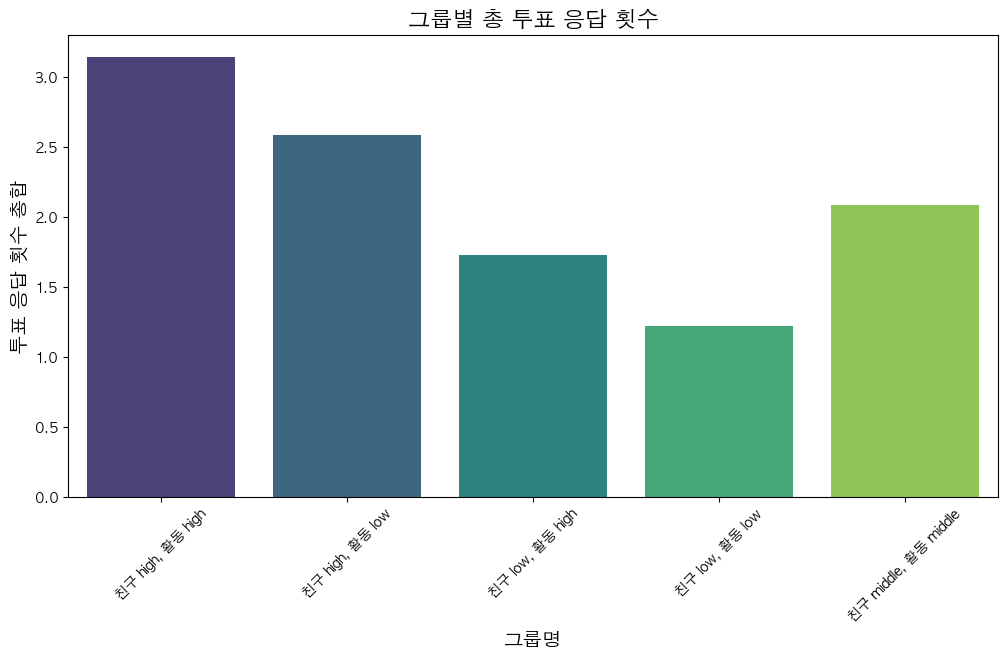

In [ ]:
# 그룹별 count 값의 합계 계산
group_sum = group_summary.groupby('groupname')['count'].sum().reset_index()

# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 총 투표 응답 횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('투표 응답 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

2) 투표 받은 횟수

In [ ]:
#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
v_acc_uqrec['created_at'] = pd.to_datetime(v_acc_uqrec['created_at'])
filtered_uqrec= v_acc_uqrec[v_acc_uqrec['created_at'] < cutoff_date]

#투표에 뽑힌 user_id만 추출
filtered_uqrec_ch = filtered_uqrec[['chosen_user_id']]

#투표에 뽑힌 횟수
chosen_vote_count = filtered_uqrec_ch.value_counts('chosen_user_id').reset_index()

#컬럼 이름 변경
chosen_vote_count = chosen_vote_count.rename(columns = {'chosen_user_id':'user_id'})

#데이터 셋 합치기
chosen_vote_merge = pd.merge(use_df, chosen_vote_count, on ='user_id',how = 'left')

#null값에 0넣기
chosen_vote_merge = chosen_vote_merge.fillna(0)

In [ ]:
group_avg

,groupname,count
0,"친구 high, 활동 high",2.130020
1,"친구 high, 활동 low",2.664003
2,"친구 low, 활동 high",0.823876
3,"친구 low, 활동 low",0.919603
4,"친구 middle, 활동 middle",1.539207


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/1177466083.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')


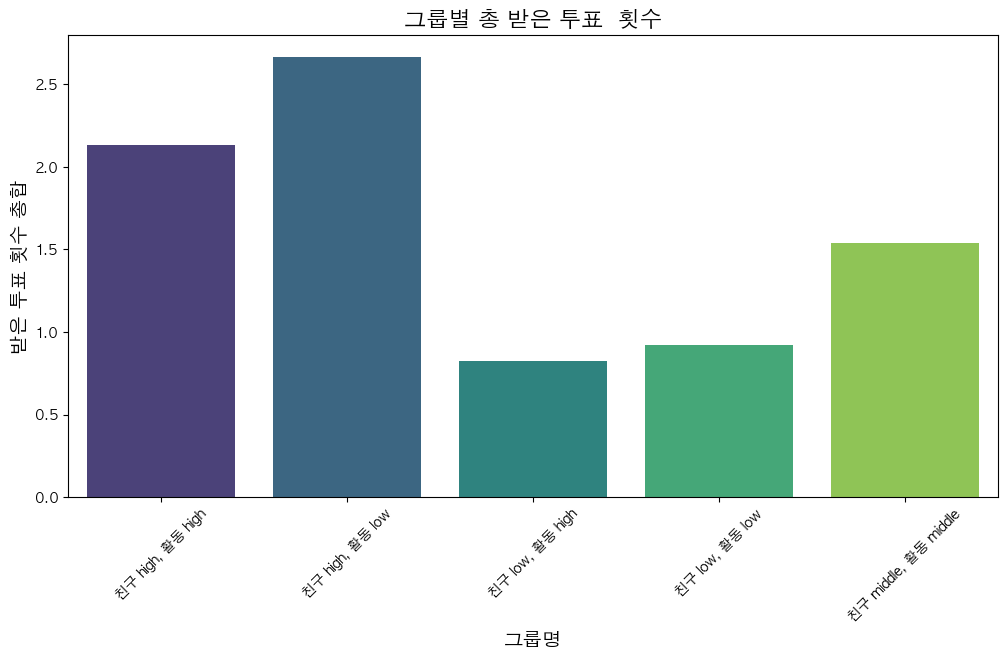

In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg = chosen_vote_merge.groupby('groupname')['count'].mean().reset_index()


# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg, x='groupname', y='count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 총 받은 투표  횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('받은 투표 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

3. 투표 관련 행동
  - 투표를 한 횟수에 2배 가중치를 두어 계산

In [ ]:
#컬럼 이름 변경
chosen_vote_merge = chosen_vote_merge.rename(columns = {'count':'passive_count'})

#컬럼 이름 변경
vote_merge = vote_merge.rename(columns = {'count':'active_count'})

#두 데이터 셋 합치기
all_vote_df = pd.merge(vote_merge, chosen_vote_merge, on = ['user_id','groupname'], how = 'inner')

#투표를 한 횟수에 2배 가중치 부여하여 투표 관련 행동 횟수 컬럼 생성
all_vote_df['total_count'] = all_vote_df['active_count']*2+all_vote_df['passive_count']

In [ ]:
all_vote_df

,user_id,groupname,active_count,passive_count,total_count
0,832151,"친구 low, 활동 low",0.0,0.0,0.0
1,832340,"친구 high, 활동 low",0.0,0.0,0.0
2,832986,"친구 low, 활동 low",0.0,0.0,0.0
3,833041,"친구 high, 활동 high",0.0,0.0,0.0
4,833154,"친구 high, 활동 low",0.0,0.0,0.0
...,...,...,...,...,...
303234,1575079,"친구 high, 활동 low",0.0,0.0,0.0
303235,1575080,"친구 low, 활동 low",0.0,0.0,0.0
303236,1575082,"친구 low, 활동 low",0.0,0.0,0.0
303237,1575092,"친구 low, 활동 low",0.0,0.0,0.0


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/3178945001.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_avg_all, x='groupname', y='total_count', palette='viridis')


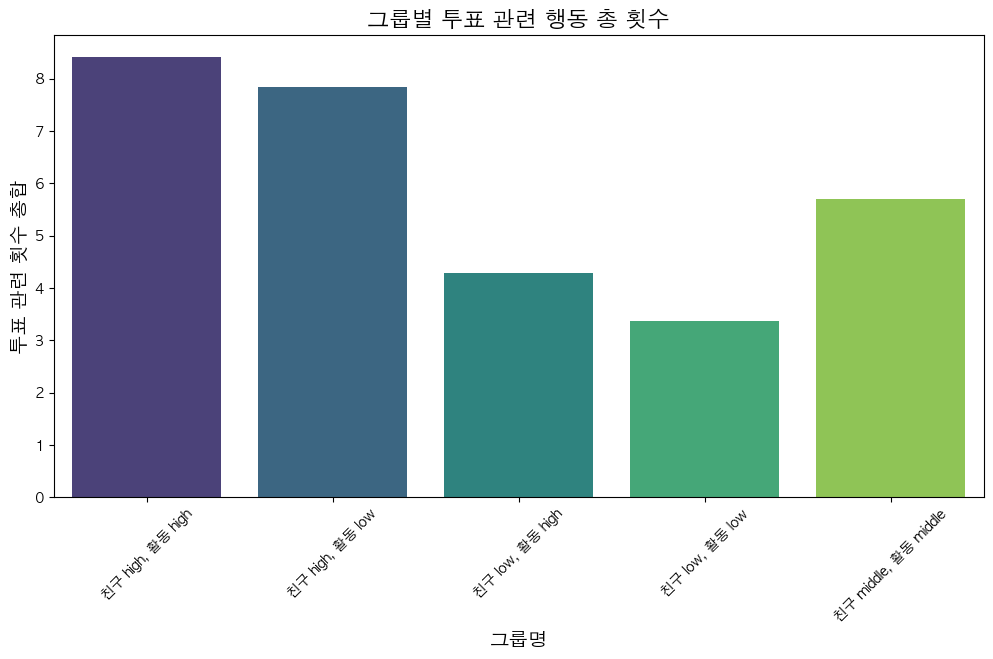

In [ ]:
# 그룹별 평균 응답 횟수 계산
group_avg_all = all_vote_df.groupby('groupname')['total_count'].mean().reset_index()


# 바 차트 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=group_avg_all, x='groupname', y='total_count', palette='viridis')

# 그래프 제목 설정
plt.title('그룹별 투표 관련 행동 총 횟수', fontsize=16)
plt.xlabel('그룹명', fontsize=14)
plt.ylabel('투표 관련 횟수 총합', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)
plt.show()

4. 결제 관련

In [ ]:
#6월13일 이전 데이터만 남기기
cutoff_date = pd.to_datetime('2023-06-13')
v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at'])
filtered_pay= v_acc_pay[v_acc_pay['created_at'] < cutoff_date]

#user_id별로 결제 횟수 카운트
pay_cnt = filtered_pay.value_counts('user_id').reset_index(name = 'pay_count')

# 데이터 합치기
pay_merge = pd.merge(use_df, pay_cnt, on = 'user_id', how = 'left')
pay_merge = pay_merge.fillna(0)

# groupname별로 pay_count의 평균과 총합 계산
group_pay = pay_merge.groupby('groupname')['pay_count'].agg(['mean', 'sum']).reset_index()
group_pay

,groupname,mean,sum
0,"친구 high, 활동 high",0.314663,15859.0
1,"친구 high, 활동 low",0.194089,13989.0
2,"친구 low, 활동 high",0.213030,10771.0
3,"친구 low, 활동 low",0.117653,8858.0
4,"친구 middle, 활동 middle",0.216484,11888.0


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/2234834931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_pay, x='groupname', y='mean', palette='viridis')


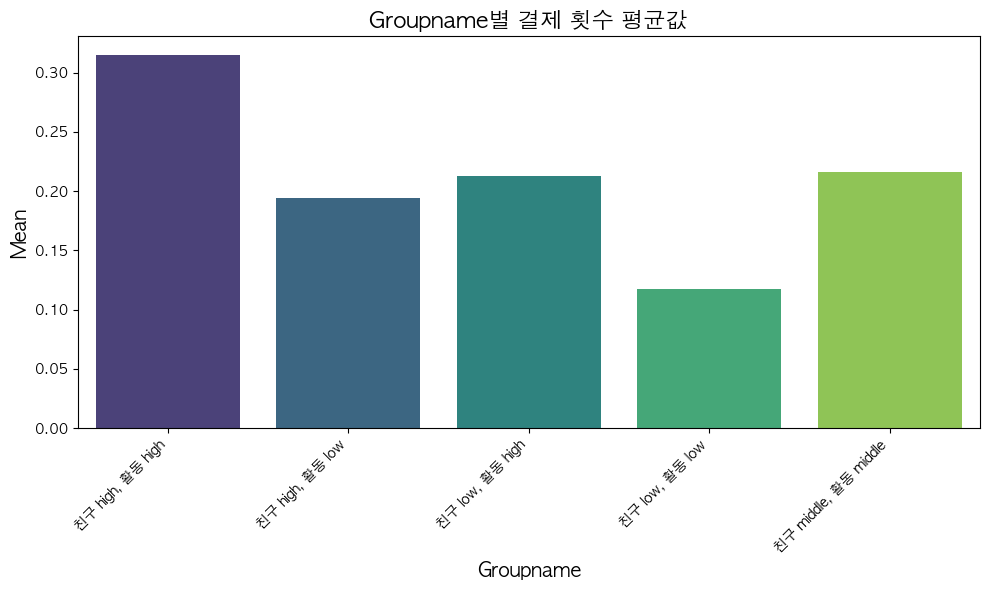

In [ ]:
# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=group_pay, x='groupname', y='mean', palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('Groupname별 결제 횟수 평균값', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Mean', fontsize=14)

# x축 라벨 회전 (너무 긴 텍스트를 보이기 위해)
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

5. 힌트 사용 관련

In [ ]:
#필요한 컬럼 가져오기
hint_df = v_acc_uqrec[['created_at','chosen_user_id','status']]

#6월 13일 이전만 필터링
hint_df['created_at'] = pd.to_datetime(hint_df['created_at'])
filtered_hint = hint_df[hint_df['created_at']<cutoff_date]

# 각 chosen_user_id별로 질문 받은 횟수 (행 개수)와 status가 'I'인 횟수 (오픈 횟수)를 계산
hint_df = filtered_hint.groupby('chosen_user_id').agg(
    question_count=('chosen_user_id', 'size'),  # 질문 받은 횟수
    open_count=('status', lambda x: (x == 'I').sum())  # status가 'I'인 횟수
).reset_index()

#컬럼이름 바꾸기
hint_df = hint_df.rename(columns = {'chosen_user_id':'user_id'})

#데이터 합치기
hint_merge = pd.merge(use_df, hint_df, on = 'user_id', how = 'left')

# null값 채우기
hint_merge = hint_merge.fillna(0)

#그룹합 계산
group_hint = hint_merge.groupby('groupname').agg(
    total_question_count=('question_count', 'sum'),
    total_open_count=('open_count', 'sum')
).reset_index()
group_hint


In [ ]:
group_hint['hint_open_probability'] = group_hint['total_open_count']/group_hint['total_question_count']
group_hint

,groupname,total_question_count,total_open_count,hint_open_probability
0,"친구 high, 활동 high",107353.0,6507.0,0.060613
1,"친구 high, 활동 low",192008.0,9083.0,0.047305
2,"친구 low, 활동 high",41656.0,4255.0,0.102146
3,"친구 low, 활동 low",69236.0,4676.0,0.067537
4,"친구 middle, 활동 middle",84524.0,5641.0,0.066738


/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/3955982860.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_hint, x='groupname', y='hint_open_probability', palette='viridis')


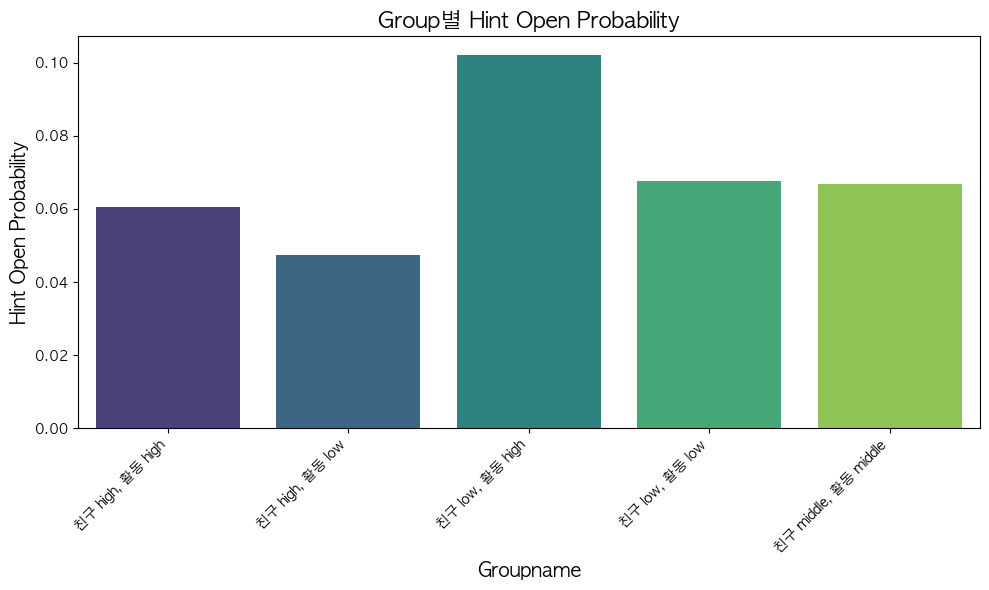

In [ ]:
# 힌트 오픈 확률에 대한 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(data=group_hint, x='groupname', y='hint_open_probability', palette='viridis')

# 그래프 제목 및 레이블 설정
plt.title('Group별 Hint Open Probability', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Hint Open Probability', fontsize=14)

# x축 라벨 회전 (긴 텍스트를 보이기 위해)
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

6. 성별과 푸쉬 알람

In [ ]:
#필요한 컬럼만 가져오기
user_info = v_acc_user[['id','gender','is_push_on']]

#컬럼 이름 변경
user_info = user_info.rename(columns = {'id':'user_id'})

#데이터 합치기
user_merge = pd.merge(use_df, user_info, on = 'user_id', how = 'left')

# groupname별로 여성 수, 남성 수, 알람을 켰는지(1), 껐는지(0) 횟수 계산
group_info = user_merge.groupby('groupname').agg(
    female_count=('gender', lambda x: (x == 'F').sum()),  # 여성 수
    male_count=('gender', lambda x: (x == 'M').sum()),  # 남성 수
    push_on_count=('is_push_on', lambda x: (x == 1).sum()),  # 알람 켰을 때의 횟수
    push_off_count=('is_push_on', lambda x: (x == 0).sum())  # 알람 껐을 때의 횟수
).reset_index()

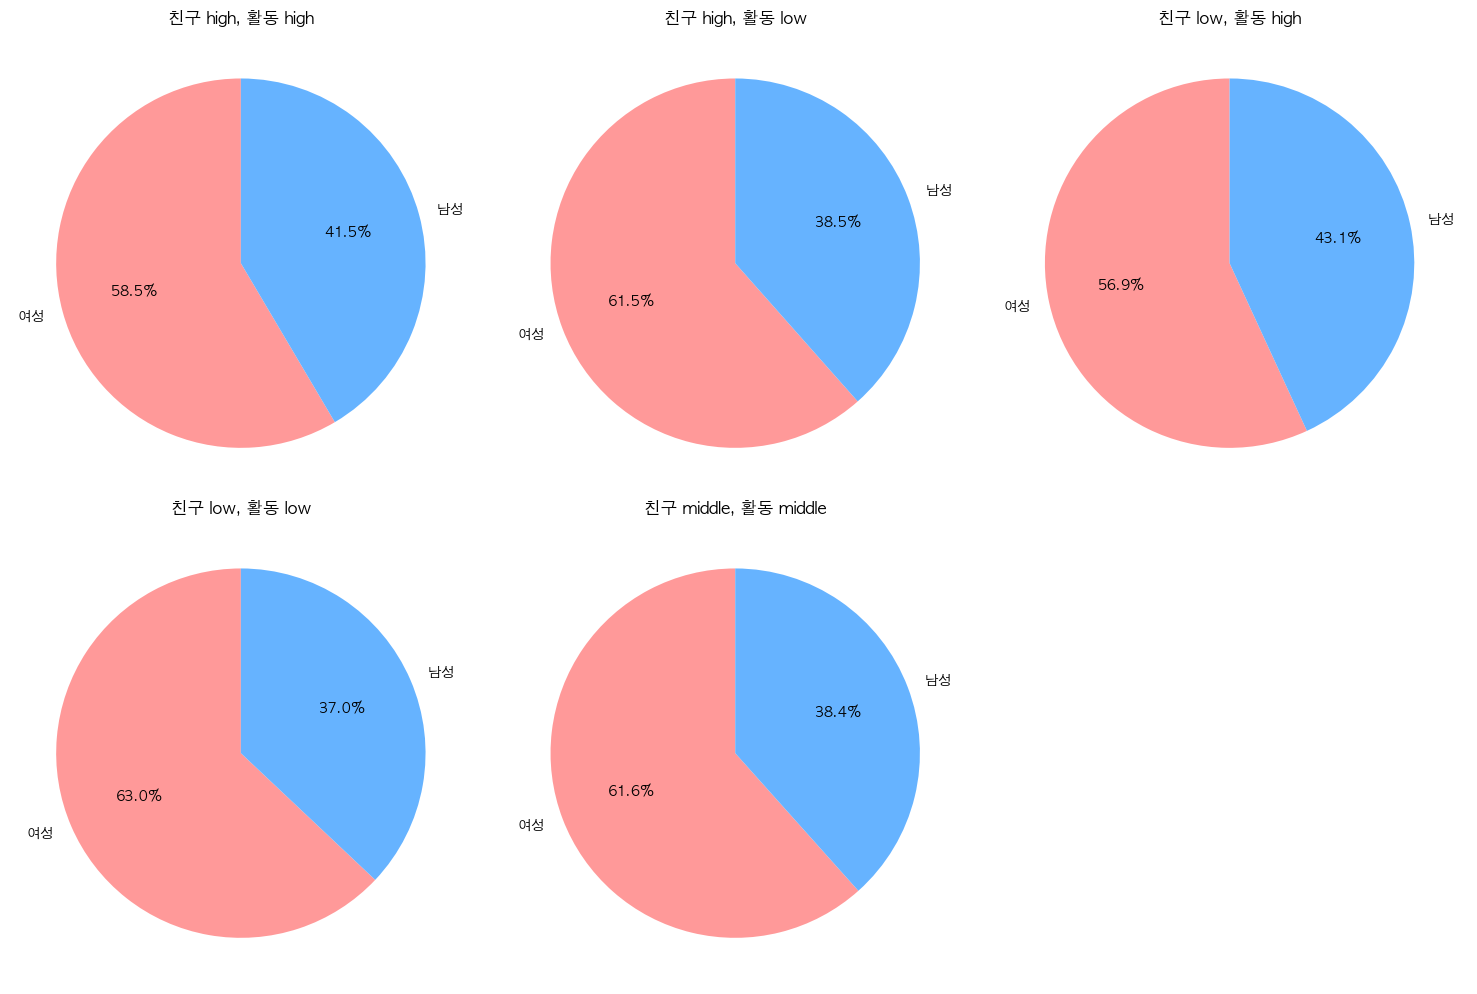

In [ ]:
# 여성과 남성 비율을 계산
group_info['female_ratio'] = group_info['female_count'] / (group_info['female_count'] + group_info['male_count'])
group_info['male_ratio'] = group_info['male_count'] / (group_info['female_count'] + group_info['male_count'])

# 전체 차트 크기 설정
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 각 그룹별로 파이차트를 그리기
for i, ax in enumerate(axes.flat):
    if i < len(group_info):  # 그룹이 부족할 경우에는 빈 공간을 피하기 위해 조건 추가
        # 각 그룹에 대한 여성과 남성 비율 파이차트
        labels = ['여성', '남성']
        sizes = [group_info.loc[i, 'female_ratio'], group_info.loc[i, 'male_ratio']]
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
        ax.set_title(group_info.loc[i, 'groupname'])
    else:
        ax.axis('off')  # 빈 공간에 대해 차트 비활성화

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()

/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_44782/1405062985.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_info, x='groupname', y='push_on_ratio', palette='Set2')


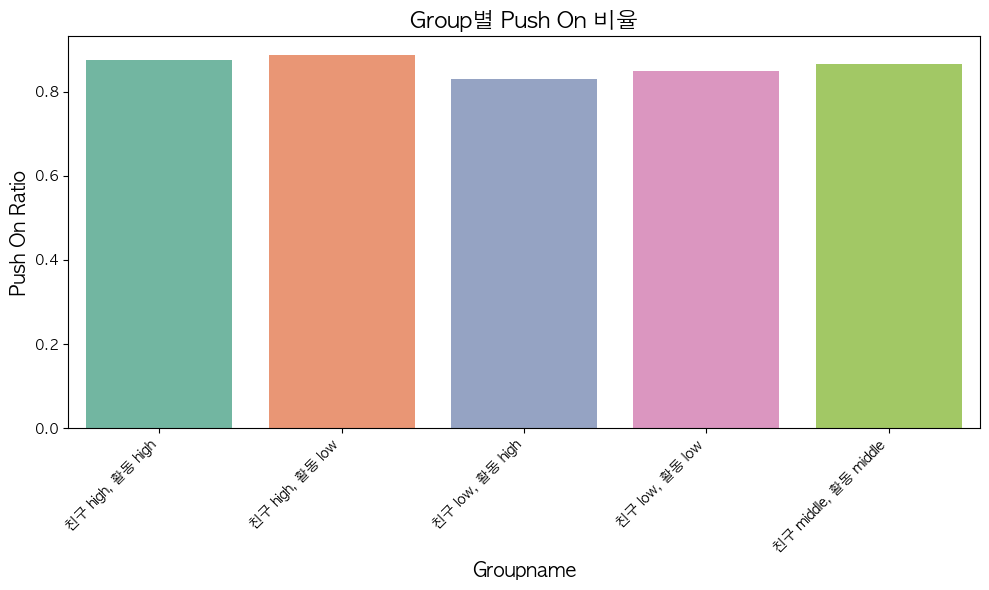

In [ ]:
# push_on 비율 계산
group_info['push_on_ratio'] = group_info['push_on_count'] / (group_info['push_on_count'] + group_info['push_off_count'])

# 그래프 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 그리기
sns.barplot(data=group_info, x='groupname', y='push_on_ratio', palette='Set2')

# 그래프 제목 및 레이블 설정
plt.title('Group별 Push On 비율', fontsize=16)
plt.xlabel('Groupname', fontsize=14)
plt.ylabel('Push On Ratio', fontsize=14)

# x축 라벨 회전
plt.xticks(rotation=45, ha='right')

# 그래프 출력
plt.tight_layout()
plt.show()

7. 그룹별 이탈률

In [ ]:
#필요한 데이터 불러오기
max_interval = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/가공 데이터/atd_user_df.csv')

#필요한 컬럼만 사용
use_max_interval_df = max_interval[['user_id','avg_interval','is_breakaway_plenty']]

#데이터 복사
interval_df = use_df.copy()

#데이터 합치기
interval_merge = pd.merge(interval_df, use_max_interval_df, on ='user_id', how = 'left')

#null값 제거
filter_interval = interval_merge.dropna()

# 그룹별 이탈자(True)와 이탈 안한 사람(False)의 수 세기
group_counts = filter_interval.groupby(['groupname', 'is_breakaway_plenty']).size().unstack(fill_value=0)

# 그룹별 avg_interval의 평균 구하기
avg_interval_mean = filter_interval.groupby('groupname')['avg_interval'].mean()

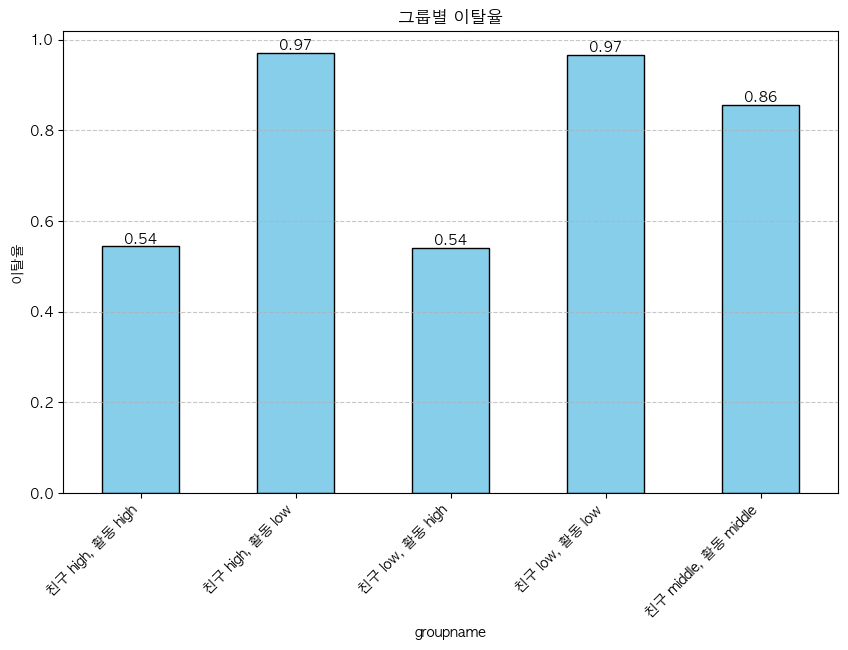

In [ ]:
# 전체 사람 수와 이탈자 수 계산
total_counts = group_counts.sum(axis=1)  # 각 그룹의 전체 인원 수
breakaway_counts = group_counts[True]  # 각 그룹의 이탈자 수

# 이탈율 계산
breakaway_rate = breakaway_counts / total_counts

# 시각화
plt.figure(figsize=(10, 6))
breakaway_rate.plot(kind='bar', color='skyblue', edgecolor='black')  # 세로 막대그래프
plt.ylabel('이탈율')  # y축 라벨
plt.title('그룹별 이탈율')
plt.xticks(rotation=45, ha='right')  # x축 라벨 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)  # y축 그리드 추가

# 이탈율 값 텍스트로 표시
for index, value in enumerate(breakaway_rate):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

3) 그룹별 공유수

In [ ]:
# 필요한 데이터 로드
h_evt_df = pd.read_csv("../h_evt_userid.csv")
user_df_group = pd.read_csv("../user_df_group.csv", encoding='utf-8-sig')

# 해클 데이터 날짜 컬럼 생성성
h_evt_df['event_datetime'] = pd.to_datetime(h_evt_df['event_datetime'])
h_evt_df['event_datetime'] = h_evt_df['event_datetime'].dt.date

# 투표 받은 수 구하는 df 생성
elected_df = h_evt_df[['user_id','event_datetime', 'votes_count']].reset_index(drop=True).drop_duplicates()

# user_id별로 가장 최근 event_datetime의 행만 남기기
latest_rows = elected_df.loc[elected_df.groupby('user_id')['event_datetime'].idxmax()]

# user_id별 투표 받은 수
latest_rows.head(2)

#그룹별 user_id list
# 열정적인 작가
enthu_writer = user_df_group[user_df_group['groupname'] == '열정적인 작가']['user_id'].unique()
# 인기쟁이 수집가
popul_collector = user_df_group[user_df_group['groupname'] == '인기쟁이 수집가']['user_id'].unique()
# 호기심 많은 탐험가
curious_explorer = user_df_group[user_df_group['groupname'] == '호기심 많은 탐험가']['user_id'].unique()
# 여유로운 마을 지킴이
protector = user_df_group[user_df_group['groupname'] == '여유로운 마을 지킴이']['user_id'].unique()
# 잠꾸러기 여행자
sleepy_traveler = user_df_group[user_df_group['groupname'] == '잠꾸러기 여행자']['user_id'].unique()

# 공유 수가 들어 있는 df
share_df = h_evt_df[h_evt_df['event_key'] == 'click_question_share']

def cnt_share(group):
  cnt = share_df[share_df['user_id'].isin(group)].shape[0]
  elected_cnt = latest_rows[latest_rows['user_id'].isin(group)]['votes_count'].sum()
  percentage_population = round(cnt / len(group)*100,2)
  percentage_election = round(cnt/elected_cnt* 100,2)
  print(f"공유수: {cnt}")
  print(f"그룹 사용자 수 대비 공유 수 비율: {percentage_population}%")
  print(f"받은 질문 수 대비 공유 수 비율: {percentage_election}%")


# 결과
print("[열정적인 작가]")
cnt_share(enthu_writer)
print("")

print("[인기쟁이 수집가]")
cnt_share(popul_collector)
print("")

print("[호기심 많은 탐험가]")
cnt_share(curious_explorer)
print("")

print("[여유로운 마을 지킴이]")
cnt_share(protector)
print("")

print("[잠꾸러기 여행자]")
cnt_share(sleepy_traveler)

[열정적인 작가]
공유수: 14394
그룹 사용자 수 대비 공유 수 비율: 23.14%
받은 질문 수 대비 공유 수 비율: 0.12%

[인기쟁이 수집가]
공유수: 5442
그룹 사용자 수 대비 공유 수 비율: 9.57%
받은 질문 수 대비 공유 수 비율: 0.07%

[호기심 많은 탐험가]
공유수: 10464
그룹 사용자 수 대비 공유 수 비율: 17.88%
받은 질문 수 대비 공유 수 비율: 0.22%

[여유로운 마을 지킴이]
공유수: 6562
그룹 사용자 수 대비 공유 수 비율: 9.45%
받은 질문 수 대비 공유 수 비율: 0.1%

[잠꾸러기 여행자]
공유수: 3606
그룹 사용자 수 대비 공유 수 비율: 6.42%
받은 질문 수 대비 공유 수 비율: 0.15%


- 앱 내 행동간 상관관계 분석

In [ ]:
# key 정리
question_event_key = ['click_question_open', 'click_question_share', 'click_question_start','complete_question']
timeline_event_key= ['click_bottom_navigation_timeline', 'view_timeline_tap']
purchase_event_key = ['view_shop', 'complete_purchase', 'click_purchase']
profile_event_key = ['click_bottom_navigation_profile', 'click_copy_profile_link_ask', 'click_copy_profile_link_profile', 'view_profile_tap']
frequency_event_key = ['launch_app']
communication_event_key = ['click_timeline_chat_start', 'click_question_ask', 'click_community_chat', 'click_appbar_chat_rooms', 'click_random_ask_normal', 'click_profile_ask', 'click_random_ask_other']

# key에 있는 값만 event_key에 남김
use_event_key = question_event_key + timeline_event_key + purchase_event_key + profile_event_key + frequency_event_key + communication_event_key
h_evt_df = h_evt_df.drop_duplicates(subset=['user_id', 'event_datetime', 'event_key'])
h_evt_df_filt = h_evt_df[h_evt_df['event_key'].isin(use_event_key)]

# 각 유저의 행동 수 카운트
user_event_counts = h_evt_df_filt.groupby('user_id')['event_key'].count().reset_index()
user_event_counts.columns = ['user_id', 'event_count']

print(f"전체 user_id 수: {h_evt_df_filt['user_id'].nunique()}")
print(f"80퍼센트 이벤트 수: {len(h_evt_df_filt)*0.8:,.0f}")
n = 18
select_user = user_event_counts[user_event_counts['event_count'] >= n]
print(f"{n}개 이상 이벤트 참여한 유저 수: {select_user['user_id'].nunique():,}")
sct_user_id = set(select_user['user_id'].unique())
see_data = h_evt_df_filt[h_evt_df_filt['user_id'].isin(sct_user_id)]
print(f"이벤트 수: {len(see_data):,.0f}")



# 기준으로 새로운 데이터프레임 만들기
# 수정완료 24-12-19 17:10
# event_key 정리 (중복)
question_event_key = ['click_question_open', 'click_question_share', 'click_question_start','complete_question']
timeline_event_key= ['click_bottom_navigation_timeline', 'view_timeline_tap']
purchase_event_key = ['view_shop', 'complete_purchase', 'click_purchase']
profile_event_key = ['click_bottom_navigation_profile', 'click_copy_profile_link_ask', 'click_copy_profile_link_profile', 'view_profile_tap']
frequency_event_key = ['launch_app']
communication_event_key = ['click_timeline_chat_start', 'click_question_ask', 'click_community_chat', 'click_appbar_chat_rooms', 'click_random_ask_normal', 'click_profile_ask', 'click_random_ask_other']

h_evt_df_filt = h_evt_df[h_evt_df['event_key'].isin(use_event_key)]
user_event_counts = h_evt_df_filt.groupby('user_id')['event_key'].count().reset_index()
user_event_counts.columns = ['user_id', 'event_count']
standard_user_df = user_event_counts[user_event_counts['event_count'] >= 18]
standard_user = set(standard_user_df['user_id'].unique())
h_seg_df = h_evt_df_filt[h_evt_df_filt['user_id'].isin(standard_user)]

In [ ]:
## 필요한 컬럼만 모으기
seg_df = h_seg_df[['user_id','event_datetime','event_key','friend_count']]

# 그룹 매핑
event_groups = {
    "question": question_event_key,
    "timeline": timeline_event_key,
    "purchase": purchase_event_key,
    "profile": profile_event_key,
    "frequency": frequency_event_key,
    "communication": communication_event_key
}

# 각 이벤트 키 그룹에 대해 라벨링
def label_event_group(event):
    for group, keys in event_groups.items():
        if event in keys:
            return group
    return "other"

seg_df["event_group"] = seg_df["event_key"].apply(label_event_group)

# 유저별 행동 횟수와 그룹별 비율 계산
user_event_counts = seg_df.groupby("user_id")["event_group"].value_counts(normalize=True).unstack(fill_value=0)

correlation_matrix = user_event_counts.iloc[:, 1:].corr()

In [ ]:
correlation_matrix

event_group,frequency,profile,purchase,question,timeline
event_group,,,,,
frequency,1.000000,-0.329265,-0.066274,-0.043907,-0.383790
profile,-0.329265,1.000000,-0.064054,-0.621974,0.366158
purchase,-0.066274,-0.064054,1.000000,0.000376,-0.094860
question,-0.043907,-0.621974,0.000376,1.000000,-0.718638
timeline,-0.383790,0.366158,-0.094860,-0.718638,1.000000


In [ ]:
#스피어만 상관계수
#필요한 라이브러리 불러오기
import scipy.stats as stats

In [ ]:
# 프로필 관련 행동과 투표 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['profile'], user_event_counts['question'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: -0.6656724555023811, p-값: 0.0


In [ ]:
# 투표 관련 행동과 타임라인 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['question'], user_event_counts['timeline'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: -0.7512869474967553, p-값: 0.0


In [ ]:
# 프로필 관련 행동과 타임라인 관련 행동 상관계수 유의성 검정
rho, p_value = stats.spearmanr(user_event_counts['profile'], user_event_counts['timeline'])

print(f"스피어만 상관계수: {rho}, p-값: {p_value}")

스피어만 상관계수: 0.47639776437829195, p-값: 0.0


## 10. 페르소나별 전략 및 성과 분석

### 호기심 많은 탐험가

#### 데이터셋 준비

In [ ]:
start_date = '2023-05-27'
end_date = '2023-06-12'
elected_date_df = v_acc_uqrec[(v_acc_uqrec['created_at'] >= start_date) & (v_acc_uqrec['created_at'] <= end_date)]
elected_date_df = elected_date_df[['chosen_user_id', 'created_at']]

chosen_user_id = set(elected_date_df['chosen_user_id'])

# 사용자 데이터 user_df에서 호기심 많은 탐험가 추출
df_explorer = user_df[user_df['groupname'] == '호기심 많은 탐험가']
df_explorer_user = set(df_explorer['user_id'])

# push 여부 추출
v_user_df = v_acc_user[['id', 'is_push_on']]
v_user_df = v_user_df[v_user_df['id'].isin(df_explorer_user)]

df_explorer = df_explorer.merge(v_user_df, left_on='user_id', right_on='id', how='left')
df_explorer.drop(columns=['id', 'groupname'], inplace=True)

dfsim_exp = df_explorer[['user_id', 'attendance_count', 'is_push_on']]
df_push = dfsim_exp[dfsim_exp['is_push_on'] == 1]
df_nonpush = dfsim_exp[dfsim_exp['is_push_on'] == 0]

push_explorer_id = set(df_push['user_id'])
nonpush_explorer_id = set(df_nonpush['user_id'])

user_friend_df = v_acc_user[['id', 'friend_id_list']]

push_user_friend_df = user_friend_df[user_friend_df['id'].isin(push_explorer_id)]
nonpush_user_friend_df = user_friend_df[user_friend_df['id'].isin(nonpush_explorer_id)]

push_user_friend_df['friend_id_list'] = push_user_friend_df['friend_id_list'].apply(eval)
push_user_friend_pairs = push_user_friend_df.explode('friend_id_list')
push_user_friend_pairs = push_user_friend_pairs.rename(columns={'id': 'user_id', 'friend_id_list': 'friend_id'})

nonpush_user_friend_df['friend_id_list'] = nonpush_user_friend_df['friend_id_list'].apply(eval)
nonpush_user_friend_pairs = nonpush_user_friend_df.explode('friend_id_list')
nonpush_user_friend_pairs = nonpush_user_friend_pairs.rename(columns={'id': 'user_id', 'friend_id_list': 'friend_id'})

push_friend_user_id = set(push_user_friend_pairs['friend_id'])
nonpush_friend_user_id = set(nonpush_user_friend_pairs['friend_id'])

push_user_friend_pairs = push_user_friend_pairs[push_user_friend_pairs['friend_id'].isin(chosen_user_id)]
nonpush_user_friend_pairs = nonpush_user_friend_pairs[nonpush_user_friend_pairs['friend_id'].isin(chosen_user_id)]

# 투표 날짜 추출
elected_date_df['created_at'] = pd.to_datetime(elected_date_df['created_at']).dt.date
elected_date_df = elected_date_df.drop_duplicates(subset=['chosen_user_id', 'created_at'])

vote_dates_by_user = elected_date_df.groupby('chosen_user_id')['created_at'].agg(list).reset_index()
vote_dates_by_user = vote_dates_by_user.rename(columns={'created_at': 'vote_dates'})

push_user_friend_pairs = push_user_friend_pairs.merge(
    vote_dates_by_user,
    left_on='friend_id',
    right_on='chosen_user_id',
    how='left'
)

nonpush_user_friend_pairs = nonpush_user_friend_pairs.merge(
    vote_dates_by_user,
    left_on='friend_id',
    right_on='chosen_user_id',
    how='left'
)

push_user_friend_pairs.drop(columns=['chosen_user_id'], inplace=True)
push_user_friend_pairs.rename(columns={'vote_dates': 'friend_elected_dates'}, inplace=True)

nonpush_user_friend_pairs.drop(columns=['chosen_user_id'], inplace=True)
nonpush_user_friend_pairs.rename(columns={'vote_dates': 'friend_elected_dates'}, inplace=True)

# 출석일 리스트로 변환
v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date']).dt.date

user_atd_list_df = v_acc_atd.groupby('user_id')['attendance_date'].agg(list).reset_index()
user_atd_list_df = user_atd_list_df.rename(columns={'attendance_date': 'user_atd_dates'})

push_user_friend_pairs = push_user_friend_pairs.merge(
    user_atd_list_df,
    on='user_id',
    how='left'
)
nonpush_user_friend_pairs = nonpush_user_friend_pairs.merge(
    user_atd_list_df,
    on='user_id',
    how='left'
)

# 리스트 간 차집합
def get_date_difference(row):
    if isinstance(row['friend_elected_dates'], list) and isinstance(row['user_atd_dates'], list):
        return sorted(list(set(row['friend_elected_dates']) - set(row['user_atd_dates'])))
    return []

push_user_friend_pairs['push_date'] = push_user_friend_pairs.apply(get_date_difference, axis=1)
nonpush_user_friend_pairs['push_date'] = nonpush_user_friend_pairs.apply(get_date_difference, axis=1)

# 푸쉬알람 가능일수 계산
user_push_dates = push_user_friend_pairs.groupby('user_id')['push_date'].agg(lambda x: sorted(list(set([date for dates in x for date in dates])))).reset_index()
user_push_dates = user_push_dates.rename(columns={'push_date': 'all_push_dates'})

nonpush_user_push_dates = nonpush_user_friend_pairs.groupby('user_id')['push_date'].agg(lambda x: sorted(list(set([date for dates in x for date in dates])))).reset_index()
nonpush_user_push_dates = nonpush_user_push_dates.rename(columns={'push_date': 'all_push_dates'})

user_push_dates['push_day_count'] = user_push_dates['all_push_dates'].str.len()
nonpush_user_push_dates['push_day_count'] = nonpush_user_push_dates['all_push_dates'].str.len()

push_user_df = user_push_dates[['user_id', 'push_day_count']]
nonpush_user_df = nonpush_user_push_dates[['user_id', 'push_day_count']]

user_push_count_df = pd.concat([push_user_df, nonpush_user_df])

df_explorer = df_explorer.merge(user_push_count_df, on='user_id', how='left').fillna(0)
user_push_count_df.head(3)

C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\3096296166.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  push_user_friend_df['friend_id_list'] = push_user_friend_df['friend_id_list'].apply(eval)
C:\Users\rkdal\AppData\Local\Temp\ipykernel_28368\3096296166.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonpush_user_friend_df['friend_id_list'] = nonpush_user_friend_df['friend_id_list'].apply(eval)


,user_id,push_day_count
0,834089,3
1,837235,0
2,837703,10


#### 가중치 학습(XGBoost)

클래스 분포:
is_breakaway_plenty
True     0.666204
False    0.333796
Name: proportion, dtype: float64


[I 2025-01-13 02:31:44,727] A new study created in memory with name: no-name-98b2d540-eb9c-44a1-a387-65e79ea82820



SMOTE 적용 후 클래스 분포:
is_breakaway_plenty
True     0.5
False    0.5
Name: proportion, dtype: float64


[I 2025-01-13 02:31:47,376] Trial 0 finished with value: 0.9541823653471131 and parameters: {'learning_rate': 0.25017634198969796, 'n_estimators': 372, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8569325049059617, 'colsample_bytree': 0.6682213485793651, 'gamma': 4.856828560632166}. Best is trial 0 with value: 0.9541823653471131.
[I 2025-01-13 02:31:48,656] Trial 1 finished with value: 0.9615778314224579 and parameters: {'learning_rate': 0.27913629915194577, 'n_estimators': 103, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.8617389552049928, 'colsample_bytree': 0.767236729199478, 'gamma': 3.7179315787386265}. Best is trial 1 with value: 0.9615778314224579.
[I 2025-01-13 02:31:50,789] Trial 2 finished with value: 0.9625468926870543 and parameters: {'learning_rate': 0.16154062935267086, 'n_estimators': 220, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9763428855021654, 'colsample_bytree': 0.8005906302328778, 'gamma': 1.7837205277419144}. Best is trial 2 with va

Best trial:
  AUC: 0.9665
  Best hyperparameters: 
    learning_rate: 0.05886944328000497
    n_estimators: 532
    max_depth: 10
    min_child_weight: 1
    subsample: 0.5699280124411454
    colsample_bytree: 0.734816969856146
    gamma: 0.04537214163648653

Optuna 최적화 모델 성능 평가:
Accuracy: 0.8714
Precision: 0.9169
Recall: 0.8875
F1 Score: 0.9019
ROC AUC: 0.9497


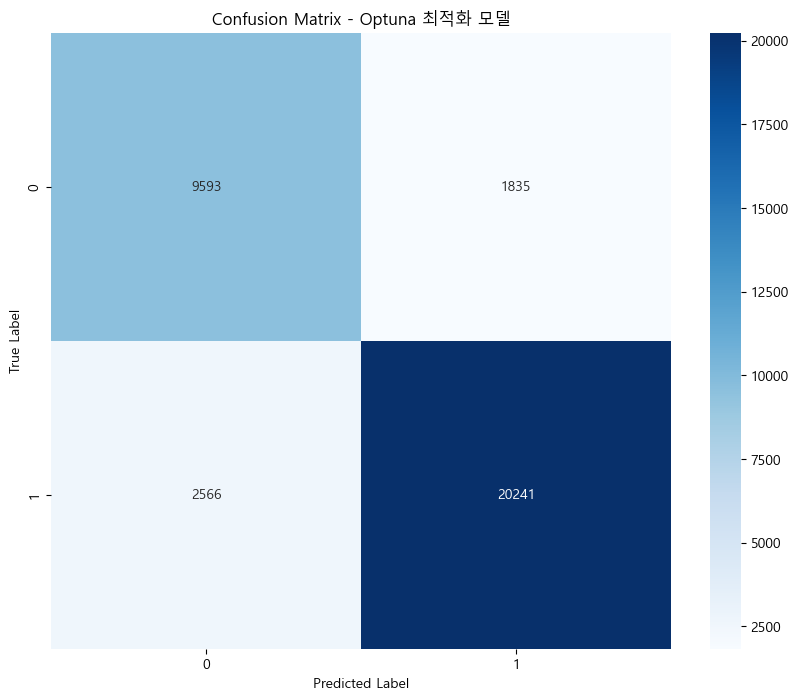

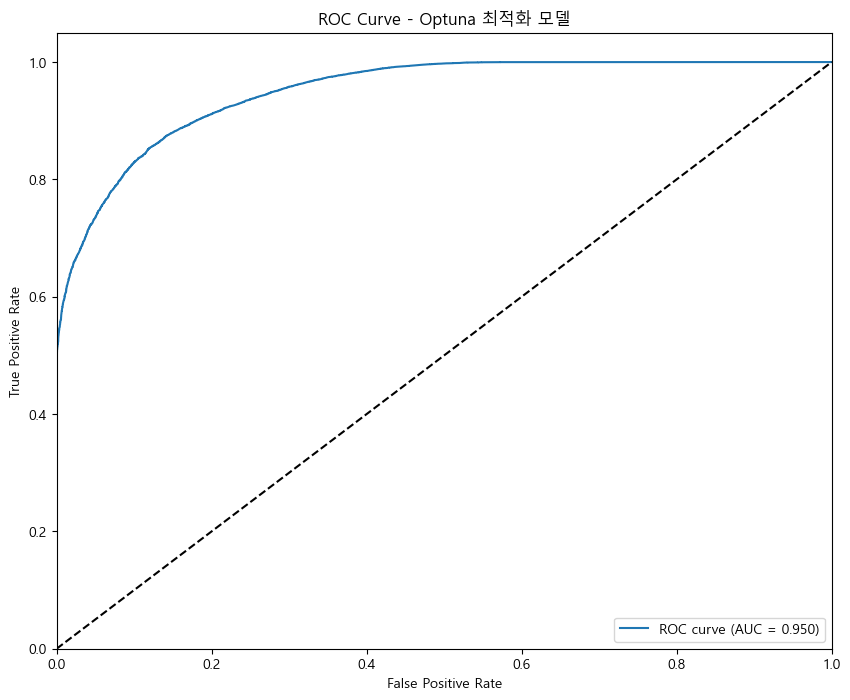

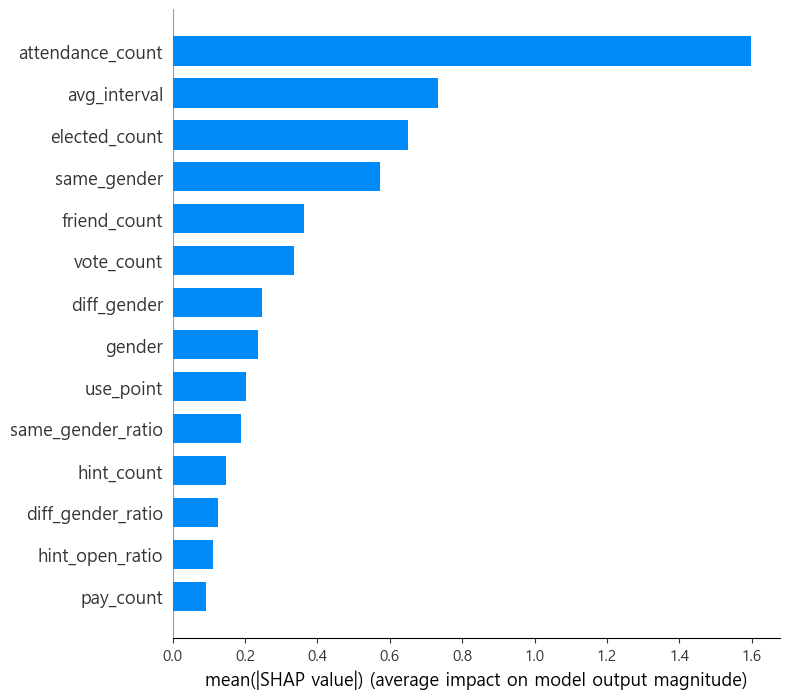

<Figure size 1000x600 with 0 Axes>

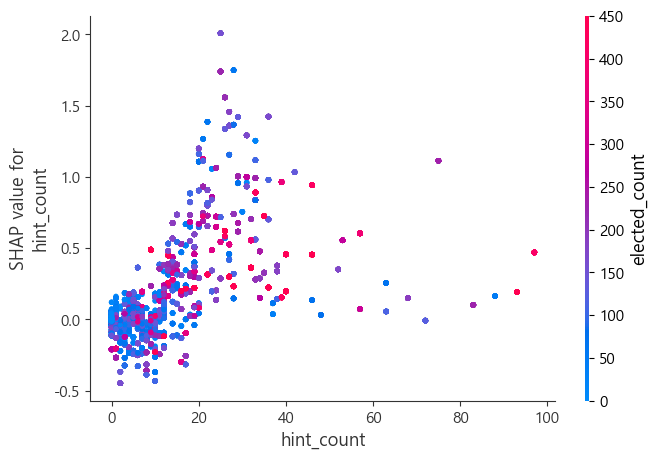

<Figure size 1000x600 with 0 Axes>

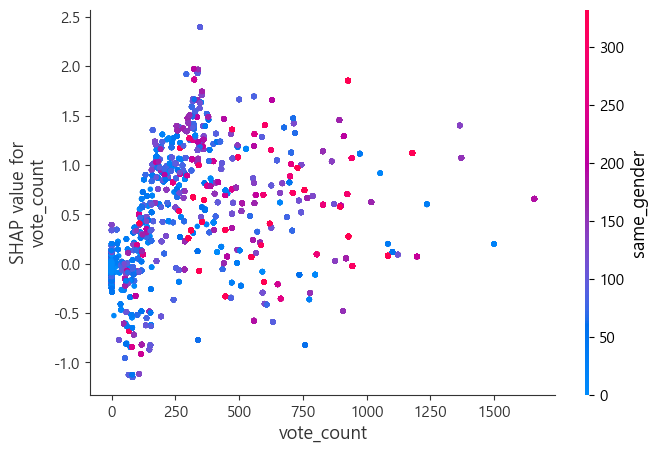

<Figure size 1000x600 with 0 Axes>

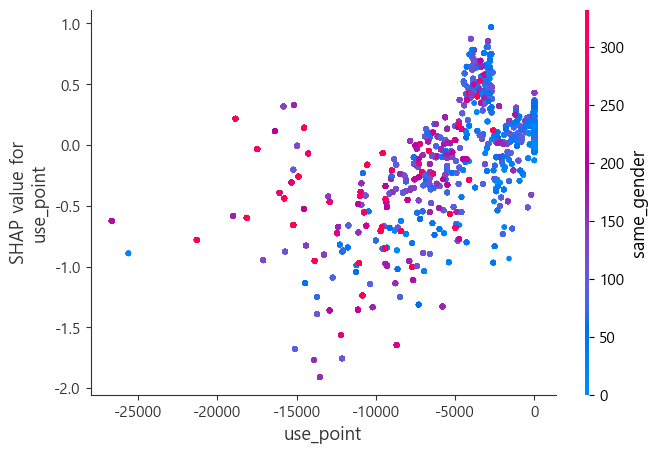

In [ ]:
drop_columns = ['user_id','is_push_on', 'push_day_count']
X = df_explorer.drop(drop_columns + ['is_breakaway_plenty'], axis=1)
y = df_explorer['is_breakaway_plenty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("클래스 분포:")
print(y_train.value_counts(normalize=True))

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'tree_method': 'hist',
        'device': 'cuda',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': 1.0,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

    return auc_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=1200)

print("Best trial:")
trial = study.best_trial

print(f"  AUC: {trial.value:.4f}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 최적 하이퍼파라미터
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'auc'
best_params['use_label_encoder'] = False
best_params['random_state'] = 42

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_resampled, y_train_resampled)

# 모델 평가 함수
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} 성능 평가:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model

evaluate_model(best_model, X_test, y_test, "Optuna 최적화 모델")

# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# SHAP Dependence Plot
feature_importance = pd.DataFrame({'feature': X.columns,
                                 'importance': best_model.feature_importances_})
top_features = feature_importance.nlargest(3, 'importance')['feature'].values

for feature in top_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values, X_test)
    plt.show()

In [ ]:
booster = best_model.get_booster()
booster.save_model("best_model_explorer.json")

#### 마케팅 시뮬레이션

In [ ]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("best_model_explorer.json")

def increment_attendance(push_day_count):
    """
    push_day_count에 따라 attendance_count를 얼마나 올릴지 결정
    - 1일 땐 +1
    - 2일 땐 +2
    - 3 이상일 땐 round(push_day_count / 3)
    """
    if push_day_count == 1:
        return 1
    elif push_day_count == 2:
        return 2
    else:
        return round(push_day_count / 3)

def marketing_for_push_on(df: pd.DataFrame, random_state=42):
    # push_on 유저 중 푸쉬알람 가능일수가 0일이 아닌 유저들
    condition = (df['is_push_on'] == 1) & (df['push_day_count'] != 0)
    target_users = df[condition]

    # 30% 샘플링
    sample_size = int(len(target_users) * 0.3)
    sampled_users = target_users.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] +
        df.loc[sampled_users.index, 'push_day_count'].apply(increment_attendance)
    )

    return df

def marketing_for_push_off(df: pd.DataFrame, random_state=42):
    # push_off 유저 중 푸쉬알람 가능일수가 0일이 아닌 유저들
    condition = (df['is_push_on'] == 0) & (df['push_day_count'] != 0)
    target_users = df[condition]

    # 30% 샘플링
    sample_size = int(len(target_users) * 0.3)
    sampled_users = target_users.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] +
        df.loc[sampled_users.index, 'push_day_count'].apply(increment_attendance)
    )

    return df

def run_marketing_scenario(df: pd.DataFrame) -> pd.DataFrame:
    """
    df를 받아 마케팅 시나리오(푸시 ON/OFF에 따른 attendance_count 증가)를 실행한 뒤
    결과를 반환하는 함수
    """
    df_experiment = df.copy()

    # push on 유저
    df_experiment = marketing_for_push_on(df_experiment)

    # push off 유저
    df_experiment = marketing_for_push_off(df_experiment)

    return df_experiment

def multiple_experiments(df_original: pd.DataFrame, model, n_times: int = 1000):
    """
    df_original: 원본 데이터프레임
    model: 불러온 XGBClassifier (loaded_model)
    n_times: 몇 번 반복할지 (default=1000)
    """

    # 예측 결과(예측 라벨, 예측 확률)를 저장할 리스트
    preds_list = []
    proba_list = []

    for i in range(n_times):
        # 마케팅 시나리오 실행
        df_sim = run_marketing_scenario(df_original)

        X_for_prediction = df_sim.drop(['user_id',
                                        'is_breakaway_plenty',
                                        'avg_interval',
                                        'is_push_on',
                                        'push_day_count'], axis=1)

        # 모델 예측
        y_pred = model.predict(X_for_prediction)
        y_pred_proba = model.predict_proba(X_for_prediction)[:, 1]

        preds_list.append(np.mean(y_pred))          # 예측 라벨의 평균
        proba_list.append(np.mean(y_pred_proba))    # 예측 확률의 평균


    overall_pred_mean = np.mean(preds_list)
    overall_proba_mean = np.mean(proba_list)

    return overall_pred_mean, overall_proba_mean

if __name__ == "__main__":
    mean_pred, mean_proba = multiple_experiments(df_explorer, loaded_model, n_times=1000)

    print("호기심 많은 탐험가의 기존 이탈률:", df_explorer['is_breakaway_plenty'].mean().round(4) * 100, "%")
    print("마케팅 1000번 반복 후, 예측 이탈률:", mean_pred.round(4) * 100, "%")
    print("마케팅 1000번 반복 후, 예측 확률:", mean_proba.round(4) * 100, "%")

호기심 많은 탐험가의 기존 이탈률: 58.77 %
마케팅 1000번 반복 후, 예측 이탈률: 57.98 %
마케팅 1000번 반복 후, 예측 확률: 52.18999981880188 %


### 인기쟁이 수집가

#### 데이터셋 준비

In [ ]:
# 앞의 머신러닝에서 사용한 user_df 사용
df_collecter = user_df[user_df['groupname'] == '인기쟁이 수집가']

#### 가중치 학습(XGBoost) - 호기심많은 탐험가와 동일

#### 마케팅 시뮬레이션

In [ ]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("best_model_collecter.json")

def marketing_collecter(df: pd.DataFrame, random_state=42):

    # 30% 샘플링
    sample_size = int(len(df) * 0.1)
    sampled_users = df.sample(n=sample_size, random_state=random_state)

    # attendance_count 증가
    df.loc[sampled_users.index, 'attendance_count'] = (
        df.loc[sampled_users.index, 'attendance_count'] + 1
    )

    return df

def run_marketing_scenario(df: pd.DataFrame) -> pd.DataFrame:
    """
    인기쟁이 수집가의 30%를 대상으로 마케팅 시나리오 진행하는 함수
    """
    df_experiment = df.copy()

    df_experiment = marketing_collecter(df_experiment)

    return df_experiment

def multiple_experiments(df_original: pd.DataFrame, model, n_times: int = 1000):
    """
    df_original: 원본 데이터프레임
    model: 불러온 XGBClassifier (loaded_model)
    n_times: 몇 번 반복할지 (default=1000)
    """

    # 예측 결과(예측 라벨, 예측 확률)를 저장할 리스트
    preds_list = []
    proba_list = []

    for i in range(n_times):
        # 마케팅 시나리오 실행
        df_sim = run_marketing_scenario(df_original)

        X_for_prediction = df_sim.drop(['user_id',
                                        'is_breakaway_plenty',
                                        'avg_interval',
                                        'groupname'], axis=1)

        # 모델 예측
        y_pred = model.predict(X_for_prediction)
        y_pred_proba = model.predict_proba(X_for_prediction)[:, 1]

        preds_list.append(np.mean(y_pred))          # 예측 라벨의 평균
        proba_list.append(np.mean(y_pred_proba))    # 예측 확률의 평균


    overall_pred_mean = np.mean(preds_list)
    overall_proba_mean = np.mean(proba_list)

    return overall_pred_mean, overall_proba_mean

if __name__ == "__main__":
    mean_pred, mean_proba = multiple_experiments(df_collecter, loaded_model, n_times=1000)

    print("인기쟁이 수집가의 기존 이탈률:", df_collecter['is_breakaway_plenty'].mean().round(4))
    print("마케팅 1000번 반복 후, 예측 이탈률:", mean_pred)
    print("마케팅 1000번 반복 후, 예측 확률:", mean_proba)

인기쟁이 수집가의 기존 이탈률: 0.9797
마케팅 1000번 반복 후, 예측 이탈률: 0.7450307827616532
마케팅 1000번 반복 후, 예측 확률: 0.7111654


## 11. 부록

### 퍼널분석

#### 1) click_question_start → complete_question

In [ ]:
from scipy.stats import chi2_contingency
import statsmodels.api as sm

## 관련 데이터 로드
h_evt_userid = pd.read_csv("../h_evt_userid.csv")
user_ml_df = pd.read_csv("../user_ml_df.csv")

## 친구수 합계 그룹화
user_ml_df['friend_qcut'] = pd.qcut(user_ml_df['friend_count'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])

## 분류에 사용할 마스터 테이블 생성
master = pd.merge(h_evt_userid, user_ml_df[['user_id','gender','friend_qcut','school_type']],on='user_id', how='left')

## 친구수 그룹화에 따른 유저 리스트 생성
low = master[master['friend_qcut'] == 1]['user_id'].unique()
middle = master[master['friend_qcut'] == 2]['user_id'].unique()
high = master[master['friend_qcut'] == 3]['user_id'].unique()
very_high = master[master['friend_qcut'] == 4]['user_id'].unique()

## 성별 그룹화
male_user = master[master['gender'] == 'M']['user_id'].unique()
female_user = master[master['gender'] == 'F']['user_id'].unique()

## 중고등학교 그룹화
middle_school_user = master[master['school_type']== 0]['user_id'].unique()
high_school_user = master[master['school_type']== 1]['user_id'].unique()

In [ ]:
## 퍼널 분석 함수
def funnel_analysis_cnt_ver(df, group, event_order, user_col='user_id', event_col='event_key'):
  # 결과를 저장할 리스트 초기화
  funnel_result = []

  # target data 설정
  event_log_by_grp = df[df['user_id'].isin(group)]

  for i in range(len(event_order)):
    current_event= event_order[i]
    current_stage_user_count = event_log_by_grp[event_log_by_grp[event_col] == current_event][user_col].nunique()

    if i < len(event_order) - 1:  # 마지막 단계에서는 다음 단계가 없음
      next_event = event_order[i + 1]
      next_event_user_count = event_log_by_grp[event_log_by_grp[event_col] == next_event][user_col].nunique()
      moved_to_next_stage = next_event_user_count

      # 이탈한 사용자 수 (현재 단계의 사용자 중 다음 단계로 이동하지 않은 사용자)
      dropped_out = current_stage_user_count - moved_to_next_stage

    else:
      moved_to_next_stage = 0
      dropped_out = current_stage_user_count  # 마지막 단계에서는 모두 이탈로 간주

    # 비율 계산
    move_rate = (moved_to_next_stage / current_stage_user_count) * 100 if current_stage_user_count > 0 else 0
    dropout_rate = (dropped_out / current_stage_user_count) * 100 if current_stage_user_count > 0 else 0

    # 결과 기록
    funnel_result.append({
        'Event': current_event,
        'Total Users at Stage': current_stage_user_count,
        'Moved to Next Stage': moved_to_next_stage,
        'Move Rate (%)': round(move_rate, 2),
        'Dropped Out': dropped_out,
        'Dropout Rate (%)': round(dropout_rate, 2)
    })

  funnel_result = pd.DataFrame(funnel_result)
  return funnel_result

In [ ]:
##그룹별 퍼널 분석 코드(함수 적용)
## 친구 그룹별 퍼널 분석
names =['very_high','high','middle','low']
groups = [very_high, high, middle,low]
event_order=['click_question_start', 'complete_question']

for name, group in zip(names, groups):
  print(f"{name}의 퍼널분석 결과")
  display(funnel_analysis_cnt_ver(master, group, event_order))


## 성별 퍼널 분석
names =['male_user','female_user']
groups = [male_user,female_user]

for name, group in zip(names, groups):
  print(f"{name}의 퍼널분석 결과")
  display(funnel_analysis_cnt_ver(master, group, event_order))


## 중고등학교별 퍼널 분석
names =['middle_school_user','high_school_user']
groups = [middle_school_user ,high_school_user]

for name, group in zip(names, groups):
  print(f"{name}의 퍼널분석 결과")
  display(funnel_analysis_cnt_ver(master, group, event_order))

very_high의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,17638,11945,67.72,5693,32.28
1,complete_question,11945,0,0.00,11945,100.00


high의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,17676,11511,65.12,6165,34.88
1,complete_question,11511,0,0.00,11511,100.00


middle의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,18452,11958,64.81,6494,35.19
1,complete_question,11958,0,0.00,11958,100.00


low의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,20427,13534,66.26,6893,33.74
1,complete_question,13534,0,0.00,13534,100.00


male_user의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,34906,22682,64.98,12224,35.02
1,complete_question,22682,0,0.00,22682,100.00


female_user의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,39287,26266,66.86,13021,33.14
1,complete_question,26266,0,0.00,26266,100.00


middle_school_user의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,43157,30778,71.32,12379,28.68
1,complete_question,30778,0,0.00,30778,100.00


high_school_user의 퍼널분석 결과


,Event,Total Users at Stage,Moved to Next Stage,Move Rate (%),Dropped Out,Dropout Rate (%)
0,click_question_start,31036,18170,58.54,12866,41.46
1,complete_question,18170,0,0.00,18170,100.00


In [ ]:
## 검정
## 친구 수 카이제곱 검정
friend = {'very_high': [11945, 5693],
          'high': [11511,6165],
          'middle': [11958,6494],
          'low': [13534,6893]
          }

# 데이터를 행렬 형태로 변환 (성공, 실패를 행으로, 그룹을 열로)
df = pd.DataFrame(friend, index=['success', 'failure'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(df)

# 결과 출력
print(f'Chi-square statistic: {chi2}')
print(f'p-value: {p}')

if p < 0.05:
    print("집단 간 전환율의 차이가 통계적으로 유의합니다.")
else:
    print("집단 간 전환율의 차이가 통계적으로 유의하지 않습니다.")



## 친구수 middle/low Z검정
# 친구수 middle/low 데이터
success_middle = 11958  # middle그룹의 성공 수
total_middle = 18452  # middle그룹의 전체 수

success_low = 13534  # low그룹의 성공 수
total_low = 20427   # low그룹의 전체 수

# 성공률 계산
conversion_rate_middle = success_middle / total_middle
conversion_rate_low = success_low / total_low

# 두 집단의 성공 수와 실패 수를 배열로 만듦
count = [success_middle, success_low]  # 성공 수
nobs = [total_middle, total_low]       # 전체 시도 수

# 비율 검정 (Z-test for proportions)
stat, p_value = sm.stats.proportions_ztest(count, nobs)

# 결과 출력
print(f'Z-statistic: {stat}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("두 집단 간 전환율의 차이가 통계적으로 유의합니다.")
else:
    print("두 집단 간 전환율의 차이가 통계적으로 유의하지 않습니다.")


## 성별 Z검정
# 성별 데이터
success_male = 22682  # A그룹의 성공 수
total_male = 34906   # A그룹의 전체 수

success_female = 26266  # female그룹의 성공 수
total_female = 39287   # female그룹의 전체 수

# 성공률 계산
conversion_rate_male = success_male / total_male
conversion_rate_female = success_female / total_female

# 두 집단의 성공 수와 실패 수를 배열로 만듦
count = [success_male, success_female]  # 성공 수
nobs = [total_male, total_female]       # 전체 시도 수

# 비율 검정 (Z-test for proportions)
stat, p_value = sm.stats.proportions_ztest(count, nobs)

# 결과 출력
print(f'Z-statistic: {stat}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("두 집단 간 전환율의 차이가 통계적으로 유의합니다.")
    #print(f'A 집단의 전환율 95% 신뢰구간: {confint_male}')
    #print(f'B 집단의 전환율 95% 신뢰구간: {confint_female}')
else:
    print("두 집단 간 전환율의 차이가 통계적으로 유의하지 않습니다.")



## 중고등학교 그룹 Z검정
# 중고등학교 데이터
success_middle_scl = 30778  # middle_scl그룹의 성공 수
total_middle_scl = 43157   # middle_scl그룹의 전체 수

success_high_scl = 18170  # high_scl그룹의 성공 수
total_high_scl = 31036   # high_scl그룹의 전체 수

# 성공률 계산
conversion_rate_middle_scl = success_middle_scl / total_middle_scl
conversion_rate_high_scl = success_high_scl / total_high_scl

# 두 집단의 성공 수와 실패 수를 배열로 만듦
count = [success_middle_scl, success_high_scl]  # 성공 수
nobs = [total_middle_scl, total_high_scl]       # 전체 시도 수

# 비율 검정 (Z-test for proportions)
stat, p_value = sm.stats.proportions_ztest(count, nobs)

# 결과 출력
print(f'Z-statistic: {stat}')
print(f'p-value: {p_value}')

if p_value < 0.05:
    print("두 집단 간 전환율의 차이가 통계적으로 유의합니다.")
else:
    print("두 집단 간 전환율의 차이가 통계적으로 유의하지 않습니다.")

Chi-square statistic: 41.68556241433831
p-value: 4.678374571085763e-09
집단 간 전환율의 차이가 통계적으로 유의합니다.
Z-statistic: -3.0036211036757234
p-value: 0.002667873474504263
두 집단 간 전환율의 차이가 통계적으로 유의합니다.
Z-statistic: -5.384515965603717
p-value: 7.26398564975068e-08
두 집단 간 전환율의 차이가 통계적으로 유의합니다.
Z-statistic: 36.218019560323796
p-value: 3.1687659818148957e-287
두 집단 간 전환율의 차이가 통계적으로 유의합니다.


#### 2) view_lab_tap → click_bottom_navigation_questions → click_question_start → complete_question

In [ ]:
df = pd.read_csv("./h_evt_userid.csv")
df2 = pd.read_csv("./user_ml_df.csv")

In [ ]:
# 'friend_count' 컬럼을 4분위수로 그룹화
# 새로운 열 'friend_group'을 생성하여 친구 수를 4개의 그룹(Low, Medium, High, Very High)로 분류
df2['friend_group'] = pd.qcut(df2['friend_count'], q=4, labels=['low', 'medium', 'high', 'very high'])

# 분류된 친구 그룹의 분포 확인
friend_group_distribution = df2['friend_group'].value_counts()

friend_group_distribution

friend_group
low          58568
medium       57503
high         55377
very high    54808
Name: count, dtype: int64

In [ ]:
col_mapping = df2[['user_id', 'gender','school_type','friend_group']]

# 'user_id'를 기준으로 두 데이터 병합
merged_df = df.merge(col_mapping, on='user_id', how='left')

merged_df['event_datetime'] = pd.to_datetime(merged_df['event_datetime'])

In [ ]:
# 필요한 이벤트만 필터링
funnel_events = ['view_lab_tap', 'click_bottom_navigation_questions', 'click_question_start', 'complete_question']
funnel_data = merged_df[merged_df['event_key'].isin(funnel_events)]

# 사용자별로 시간 기준 정렬
funnel_data['event_datetime'] = pd.to_datetime(funnel_data['event_datetime'])  # 시간 변환
funnel_data = funnel_data.sort_values(by=['user_id', 'event_datetime'])

#  단계별 사용자 수 계산
funnel_counts = []
for event in funnel_events:
    unique_users = funnel_data[funnel_data['event_key'] == event]['user_id'].nunique()
    funnel_counts.append({'event': event, 'unique_users': unique_users})

#  데이터프레임 생성
funnel_df = pd.DataFrame(funnel_counts)

# 전환율 계산: 이전 단계 사용자 수 기준
funnel_df['prev_unique_users'] = funnel_df['unique_users'].shift(1)  # 이전 단계
funnel_df['conversion_rate'] = (funnel_df['unique_users'] / funnel_df['prev_unique_users']) * 100
funnel_df['conversion_rate'] = funnel_df['conversion_rate'].fillna(100)  # 첫 단계는 100%

# 퍼센트 감소율 계산
funnel_df['percent_drop'] = (1 - (funnel_df['unique_users'] / funnel_df['prev_unique_users'])) * 100
funnel_df['percent_drop'] = funnel_df['percent_drop'].fillna(0)


# 전환율 결과 출력
funnel_df

,event,unique_users,prev_unique_users,conversion_rate,percent_drop
0,view_lab_tap,170903,NaN,100.000000,0.000000
1,click_bottom_navigation_questions,166164,170903.0,97.227082,2.772918
2,click_question_start,74193,166164.0,44.650466,55.349534
3,complete_question,48948,74193.0,65.973879,34.026121


In [ ]:
# 필요한 이벤트만 필터링
funnel_events = ['view_lab_tap', 'click_bottom_navigation_questions', 'click_question_start', 'complete_question']
funnel_data = merged_df[merged_df['event_key'].isin(funnel_events)]

# 시간 기준 정렬
funnel_data['event_datetime'] = pd.to_datetime(funnel_data['event_datetime'])
funnel_data = funnel_data.sort_values(by=['user_id', 'event_datetime'])

# 친구 그룹별 퍼널 분석 결과 저장용 리스트
group_funnel_results = []

# 친구 그룹별 데이터 분리 및 퍼널 분석
friend_groups = funnel_data['friend_group'].dropna().unique()
for group in friend_groups:
    group_data = funnel_data[funnel_data['friend_group'] == group]

    # 단계별 사용자 수 계산
    funnel_counts = []
    for event in funnel_events:
        unique_users = group_data[group_data['event_key'] == event]['user_id'].nunique()
        funnel_counts.append({'friend_group': group, 'event': event, 'unique_users': unique_users})

    # 데이터프레임 생성
    group_funnel_df = pd.DataFrame(funnel_counts)

    # 전환율 계산: 이전 단계 사용자 수 기준
    group_funnel_df['prev_unique_users'] = group_funnel_df['unique_users'].shift(1)  # 이전 단계
    group_funnel_df['conversion_rate'] = (group_funnel_df['unique_users'] / group_funnel_df['prev_unique_users']) * 100
    group_funnel_df['conversion_rate'] = group_funnel_df['conversion_rate'].fillna(100)  # 첫 단계는 100%

    # 퍼센트 감소율 계산
    group_funnel_df['percent_drop'] = (1 - (group_funnel_df['unique_users'] / group_funnel_df['prev_unique_users'])) * 100
    group_funnel_df['percent_drop'] = group_funnel_df['percent_drop'].fillna(0)

    group_funnel_results.append(group_funnel_df)

# 모든 그룹의 퍼널 분석 결과 통합
funnel_df_2 = pd.concat(group_funnel_results, ignore_index=True)

# 결과 출력
funnel_df_2

,friend_group,event,unique_users,prev_unique_users,conversion_rate,percent_drop
0,very high,view_lab_tap,40839,NaN,100.000000,0.000000
1,very high,click_bottom_navigation_questions,39492,40839.0,96.701682,3.298318
2,very high,click_question_start,17638,39492.0,44.662210,55.337790
3,very high,complete_question,11945,17638.0,67.723098,32.276902
4,medium,view_lab_tap,43504,NaN,100.000000,0.000000
5,medium,click_bottom_navigation_questions,42542,43504.0,97.788709,2.211291
6,medium,click_question_start,18452,42542.0,43.373607,56.626393
7,medium,complete_question,11958,18452.0,64.805983,35.194017
8,high,view_lab_tap,41664,NaN,100.000000,0.000000
9,high,click_bottom_navigation_questions,40434,41664.0,97.047811,2.952189


In [ ]:
# 필요한 이벤트만 필터링
funnel_events = ['view_lab_tap', 'click_bottom_navigation_questions', 'click_question_start', 'complete_question']
funnel_data = merged_df[merged_df['event_key'].isin(funnel_events)]

# 시간 기준 정렬
funnel_data['event_datetime'] = pd.to_datetime(funnel_data['event_datetime'])
funnel_data = funnel_data.sort_values(by=['user_id', 'event_datetime'])

# 성별별 퍼널 분석 결과 저장용 리스트
gender_funnel_results = []

# 성별별 데이터 분리 및 퍼널 분석
genders = funnel_data['gender'].dropna().unique()
for gender in genders:
    gender_data = funnel_data[funnel_data['gender'] == gender]

    # 단계별 사용자 수 계산
    funnel_counts = []
    for event in funnel_events:
        unique_users = gender_data[gender_data['event_key'] == event]['user_id'].nunique()
        funnel_counts.append({'gender': gender, 'event': event, 'unique_users': unique_users})

    # 데이터프레임 생성
    gender_funnel_df = pd.DataFrame(funnel_counts)

    # 전환율 계산: 이전 단계 사용자 수 기준
    gender_funnel_df['prev_unique_users'] = gender_funnel_df['unique_users'].shift(1)  # 이전 단계
    gender_funnel_df['conversion_rate'] = (gender_funnel_df['unique_users'] / gender_funnel_df['prev_unique_users']) * 100
    gender_funnel_df['conversion_rate'] = gender_funnel_df['conversion_rate'].fillna(100)  # 첫 단계는 100%

    # 퍼센트 감소율 계산
    gender_funnel_df['percent_drop'] = (1 - (gender_funnel_df['unique_users'] / gender_funnel_df['prev_unique_users'])) * 100
    gender_funnel_df['percent_drop'] = gender_funnel_df['percent_drop'].fillna(0)

    gender_funnel_results.append(gender_funnel_df)


# 모든 성별의 퍼널 분석 결과 통합
gender_funnel_df = pd.concat(gender_funnel_results, ignore_index=True)

gender_funnel_df

,gender,event,unique_users,prev_unique_users,conversion_rate,percent_drop
0,F,view_lab_tap,97658,NaN,100.000000,0.000000
1,F,click_bottom_navigation_questions,93820,97658.0,96.069958,3.930042
2,F,click_question_start,39287,93820.0,41.874867,58.125133
3,F,complete_question,26266,39287.0,66.856721,33.143279
4,M,view_lab_tap,73245,NaN,100.000000,0.000000
5,M,click_bottom_navigation_questions,72344,73245.0,98.769882,1.230118
6,M,click_question_start,34906,72344.0,48.250028,51.749972
7,M,complete_question,22682,34906.0,64.980233,35.019767


In [ ]:
# 필요한 이벤트만 필터링
funnel_events = ['view_lab_tap', 'click_bottom_navigation_questions', 'click_question_start', 'complete_question']
funnel_data = merged_df[merged_df['event_key'].isin(funnel_events)]

# 시간 기준 정렬
funnel_data['event_datetime'] = pd.to_datetime(funnel_data['event_datetime'])
funnel_data = funnel_data.sort_values(by=['user_id', 'event_datetime'])

# 중/고등별 퍼널 분석 결과 저장
school_funnel_results = []

# 중/고등별 데이터 분리 및 퍼널 분석
school_types = funnel_data['school_type'].dropna().unique()
for school_type in school_types:
    school_data = funnel_data[funnel_data['school_type'] == school_type]

    # 단계별 사용자 수 계산
    funnel_counts = []
    for event in funnel_events:
        unique_users = school_data[school_data['event_key'] == event]['user_id'].nunique()
        funnel_counts.append({'school_type': school_type, 'event': event, 'unique_users': unique_users})

    # 데이터프레임 생성
    school_funnel_df = pd.DataFrame(funnel_counts)

    # 전환율 계산: 이전 단계 사용자 수 기준
    school_funnel_df['prev_unique_users'] = school_funnel_df['unique_users'].shift(1)  # 이전 단계 사용자 수
    school_funnel_df['conversion_rate'] = (school_funnel_df['unique_users'] / school_funnel_df['prev_unique_users']) * 100
    school_funnel_df['conversion_rate'] = school_funnel_df['conversion_rate'].fillna(100)  # 첫 단계는 100%

    # 퍼센트 감소율 계산
    school_funnel_df['percent_drop'] = (1 - (school_funnel_df['unique_users'] / school_funnel_df['prev_unique_users'])) * 100
    school_funnel_df['percent_drop'] = school_funnel_df['percent_drop'].fillna(0)

    school_funnel_results.append(school_funnel_df)

school_funnel_df = pd.concat(school_funnel_results, ignore_index=True)

school_funnel_df

,school_type,event,unique_users,prev_unique_users,conversion_rate,percent_drop
0,1.0,view_lab_tap,85161,NaN,100.000000,0.000000
1,1.0,click_bottom_navigation_questions,82308,85161.0,96.649875,3.350125
2,1.0,click_question_start,31036,82308.0,37.707149,62.292851
3,1.0,complete_question,18170,31036.0,58.544916,41.455084
4,0.0,view_lab_tap,85742,NaN,100.000000,0.000000
5,0.0,click_bottom_navigation_questions,83856,85742.0,97.800378,2.199622
6,0.0,click_question_start,43157,83856.0,51.465608,48.534392
7,0.0,complete_question,30778,43157.0,71.316357,28.683643


In [ ]:
import statsmodels.api as sm

# 데이터 준비
data = {
    'friend_group': ['very high', 'very high', 'very high', 'very high',
                     'high', 'high', 'high', 'high',
                     'medium', 'medium', 'medium', 'medium',
                     'low', 'low', 'low', 'low'],
    'step': ['step_1', 'step_2', 'step_3', 'step_4'] * 4,
    'success': [40839, 39492, 17638, 11945,  # very high
                41664, 40434, 17676, 11511,  # high
                43504, 42542, 18452, 11958,  # medium
                44896, 43696, 20427, 13534],  # low
    'prev_unique_users': [40839, 40839, 39492, 17638,
                          41664, 41664, 40434, 17676,
                          43504, 43504, 42542, 18452,
                          44896, 44896, 43696, 20427]
}

df3 = pd.DataFrame(data)

# 실패 수 계산
df3['failure'] = df3['prev_unique_users'] - df3['success']

# GLM 모델 적용
df_long = pd.DataFrame({
    'friend_group': df3['friend_group'].tolist() * 2,
    'step': df3['step'].tolist() * 2,
    'outcome': [1] * len(df3) + [0] * len(df3),
    'counts': df3['success'].tolist() + df3['failure'].tolist()
})

model = sm.GLM(df_long['outcome'],
               pd.get_dummies(df_long[['friend_group', 'step']], drop_first=True),
               family=sm.families.Binomial(),
               freq_weights=df_long['counts'])

result = model.fit()
print(result.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   32
Model:                            GLM   Df Residuals:                   582157
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4893e+05
Date:                Sun, 12 Jan 2025   Deviance:                   4.9787e+05
Time:                        22:23:01   Pearson chi2:                 6.73e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
friend_group_low           1

In [ ]:
data = {
    'friend_group': ['very high', 'very high', 'very high', 'very high',
                     'high', 'high', 'high', 'high',
                     'medium', 'medium', 'medium', 'medium',
                     'low', 'low', 'low', 'low'],
    'step': ['step_1', 'step_2', 'step_3', 'step_4'] * 4,
    'success': [40839, 39492, 17638, 11945,  # very high
                41664, 40434, 17676, 11511,  # high
                43504, 42542, 18452, 11958,  # medium
                44896, 43696, 20427, 13534],  # low
    'prev_unique_users': [40839, 40839, 39492, 17638,
                          41664, 41664, 40434, 17676,
                          43504, 43504, 42542, 18452,
                          44896, 44896, 43696, 20427]
}

df3 = pd.DataFrame(data)

# 실패 수 계산
df3['failure'] = df3['prev_unique_users'] - df3['success']

# 데이터 확장: 성공(1)과 실패(0)로 변환
df_long = pd.DataFrame({
    'friend_group': df3['friend_group'].tolist() * 2,
    'step': df3['step'].tolist() * 2,
    'outcome': [1] * len(df3) + [0] * len(df3),  # 성공(1), 실패(0)
    'counts': df3['success'].tolist() + df3['failure'].tolist()  # 가중치
})

df_long['counts_scaled'] = df_long['counts'] / 100

# 기준 그룹 명확히 설정: 'low'를 기준 그룹으로 설정
df_long['friend_group'] = pd.Categorical(df_long['friend_group'], categories=['low', 'medium', 'high', 'very high'], ordered=False)
df_long['step'] = pd.Categorical(df_long['step'], categories=['step_1', 'step_2', 'step_3', 'step_4'], ordered=False)

# GLM 모델 적용
X = pd.get_dummies(df_long[['friend_group', 'step']], drop_first=True)
y = df_long['outcome']

model = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=df_long['counts_scaled'])
result = model.fit()

# 결과 출력
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   32
Model:                            GLM   Df Residuals:                  5815.63
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2545.4
Date:                Sun, 12 Jan 2025   Deviance:                       5090.8
Time:                        22:23:01   Pearson chi2:                 6.69e+03
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
friend_group_medium        1

In [ ]:
print("p-values (정확한 값):")
for param, pval in result.pvalues.items():
    print(f"{param}: {np.format_float_scientific(pval, precision=10)}")

p-values (정확한 값):
friend_group_medium: 1.9367066605e-87
friend_group_high: 2.0228558314e-84
friend_group_very high: 8.2832625958e-86
step_step_2: 5.7860062761e-68
step_step_3: 4.6283406101e-95
step_step_4: 1.8863680352e-07


In [ ]:
odds_medium = np.exp(1.6567)
odds_high = np.exp(1.6525)
odds_very_high = np.exp(1.6879)

print("Odds Ratio (Medium):", odds_medium)
print("Odds Ratio (High):", odds_high)
print("Odds Ratio (Very High):", odds_very_high)

Odds Ratio (Medium): 5.241983724133101
Odds Ratio (High): 5.220013562128081
Odds Ratio (Very High): 5.408111737244806


##### 친구 수에 따라 그룹화된 사용자들의 퍼널 전환율에 차이가 존재하는지 확인하기 위해 이항 로지스틱 회귀 분석을 수행

##### 기준 그룹: Low (친구 수가 가장 적은 그룹)
- 나머지 그룹들의 전환율이 Low 그룹과 비교하여 얼마나 차이가 나는지 확인

##### 전환율 비교
- Medium 그룹이 Low 그룹 대비 전환율이 약 5.24배 높다.
- High 그룹: Low 그룹 대비 전환율이 약 5.22배 높다.
- Very High 그룹: Low 그룹 대비 전환율이 약 5.41배 높다.

##### p-value
- p-value가 0.05보다 작아 모든 그룹의 차이가 통계적으로 유의미한 것을 확인 가능.
- 그룹 간 전환율 차이가 우연이 아니라 실제 존재한다는 것을 확인.

##### Low 그룹은 다른 그룹들에 비해 전환율이 현저히 낮음.
Medium, High, Very High 그룹 간의 차이는 상대적으로 작지만, 그 중에서 Very High 그룹이 가장 높은 전환율을 보였습니다.

In [ ]:
import pandas as pd
import statsmodels.api as sm

# 데이터 준비
data = {
    'school_type': ['1.0'] * 4 + ['0.0'] * 4,  # 중학교와 고등학교
    'step': ['step_1', 'step_2', 'step_3', 'step_4'] * 2,  # 퍼널 단계
    'success': [82308, 31036, 18170, 0,  # 중학교 성공
                83856, 43157, 30778, 0],  # 고등학교 성공
    'failure': [85161-82308, 82308-31036, 31036-18170, 0,  # 중학교 실패
                85742-83856, 83856-43157, 43157-30778, 0]  # 고등학교 실패
}

# DataFrame 생성
df4 = pd.DataFrame(data)

# 성공과 실패를 결합한 outcome 데이터 생성
df_long3 = pd.DataFrame({
    'school_type': df4['school_type'].tolist() * 2,
    'step': df4['step'].tolist() * 2,
    'outcome': [1] * len(df4) + [0] * len(df4),  # 성공(1), 실패(0)
    'counts': df4['success'].tolist() + df4['failure'].tolist()
})

# 독립 변수 변환: 더미 변수로 변환 (학교 유형과 단계)
X = pd.get_dummies(df_long3[['school_type', 'step']], drop_first=True)
y = df_long3['outcome']

# 로지스틱 회귀 모델 적용
model3 = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=df_long3['counts'])
result3 = model3.fit()

# 결과 출력
print(result3.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   16
Model:                            GLM   Df Residuals:                   411256
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6577e+05
Date:                Sun, 12 Jan 2025   Deviance:                   5.3153e+05
Time:                        22:23:01   Pearson chi2:                 4.11e+05
No. Iterations:                     5   Pseudo R-squ. (CS):               -inf
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
school_type_1.0     0.9384      0.006    1

In [ ]:
# 성별 및 퍼널 단계별 성공/실패 데이터 준비
data = {
    'gender': ['F'] * 4 + ['M'] * 4,  # 성별 구분
    'step': ['step_1', 'step_2', 'step_3', 'step_4'] * 2,  # 퍼널 단계
    'success': [97658, 93820, 39287, 26266,  # 여성 성공
                73245, 72344, 34906, 22682],  # 남성 성공
    'prev_users': [97658, 97658, 93820, 39287,  # 여성 이전 사용자 수
                   73245, 73245, 72344, 34906]  # 남성 이전 사용자 수
}

# DataFrame 생성
df5 = pd.DataFrame(data)

# 실패 수 계산
df5['failure'] = df5['prev_users'] - df5['success']

# 성공/실패 데이터를 이항 형태로 확장
df_long4 = pd.DataFrame({
    'gender': df5['gender'].tolist() * 2,
    'step': df5['step'].tolist() * 2,
    'outcome': [1] * len(df5) + [0] * len(df5),  # 성공(1), 실패(0)
    'counts': df5['success'].tolist() + df5['failure'].tolist()
})

# 더미 변수 생성 (gender, step)
X = pd.get_dummies(df_long4[['gender', 'step']], drop_first=True)
y = df_long4['outcome']

# 이항 로지스틱 회귀 모델 생성
model4 = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=df_long4['counts'])
result4 = model4.fit()

# 결과 출력
print(result4.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   16
Model:                            GLM   Df Residuals:                   582159
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7707e+05
Date:                Sun, 12 Jan 2025   Deviance:                   5.5415e+05
Time:                        22:23:01   Pearson chi2:                 5.82e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
gender_M        1.3006      0.006    208.516      

In [ ]:
# 친구 그룹별 평균 view_timeline_tap 발생 횟수
friend_group_tap_high = high_group.groupby('friend_group')['event_key'].apply(lambda x: (x == 'view_timeline_tap').sum())
friend_group_tap_low = low_group.groupby('friend_group')['event_key'].apply(lambda x: (x == 'view_timeline_tap').sum())

print("고빈도 사용자의 친구 그룹별 view_timeline_tap 이벤트 발생 횟수:")
print(friend_group_tap_high)

print("\n저빈도 사용자의 친구 그룹별 view_timeline_tap 이벤트 발생 횟수:")
print(friend_group_tap_low)

고빈도 사용자의 친구 그룹별 view_timeline_tap 이벤트 발생 횟수:
friend_group
low          287118
medium       228749
high         199172
very high    181166
Name: event_key, dtype: int64

저빈도 사용자의 친구 그룹별 view_timeline_tap 이벤트 발생 횟수:
friend_group
low          112084
medium       110382
high         106072
very high    103989
Name: event_key, dtype: int64


In [ ]:
# 친구 그룹별 타임라인 진입 경로 분석
def group_timeline_entry_top5(group_df):
    # 이전 이벤트를 추가하기 위해 데이터 정렬
    group_df = group_df.sort_values(by=['user_id', 'event_datetime'])
    group_df['previous_event'] = group_df.groupby('user_id')['event_key'].shift(1)

    # view_timeline_tap 이전 이벤트 필터링
    timeline_tap = group_df[group_df['event_key'] == 'view_timeline_tap']
    previous_event_counts = timeline_tap.groupby('friend_group')['previous_event'].value_counts(normalize=True)

    # 그룹별 상위 5개 선택
    top5 = previous_event_counts.groupby(level=0).head(5)  # 각 friend_group별 상위 5개
    return top5

# 고빈도 사용자와 저빈도 사용자 타임라인 진입 경로 상위 5개씩 확인
entry_high_top5 = group_timeline_entry_top5(high_group)
entry_low_top5 = group_timeline_entry_top5(low_group)

print("고빈도 사용자의 view_timeline_tap 진입 경로:")
print(entry_high_top5)


고빈도 사용자의 view_timeline_tap 진입 경로:
friend_group  previous_event                   
low           view_lab_tap                         0.202756
              view_timeline_tap                    0.180546
              click_bottom_navigation_timeline     0.135112
              click_bottom_navigation_questions    0.087661
              click_bottom_navigation_profile      0.071741
medium        view_timeline_tap                    0.201522
              view_lab_tap                         0.197282
              click_bottom_navigation_timeline     0.128630
              click_bottom_navigation_questions    0.086807
              click_bottom_navigation_profile      0.067602
high          view_timeline_tap                    0.208850
              view_lab_tap                         0.196795
              click_bottom_navigation_timeline     0.127799
              click_bottom_navigation_questions    0.086940
              click_bottom_navigation_profile      0.064341
very high     view

In [ ]:
# 친구 수와 투표 수의 상관관계 분석
correlation_high = high_group[['friend_count', 'votes_count']].corr()
correlation_low = low_group[['friend_count', 'votes_count']].corr()

print("고빈도 사용자 친구 수와 투표 수의 상관관계:")
print(correlation_high)

print("\n저빈도 사용자 친구 수와 투표 수의 상관관계:")
print(correlation_low)

고빈도 사용자 친구 수와 투표 수의 상관관계:
              friend_count  votes_count
friend_count      1.000000     0.473892
votes_count       0.473892     1.000000

저빈도 사용자 친구 수와 투표 수의 상관관계:
              friend_count  votes_count
friend_count      1.000000     0.589707
votes_count       0.589707     1.000000


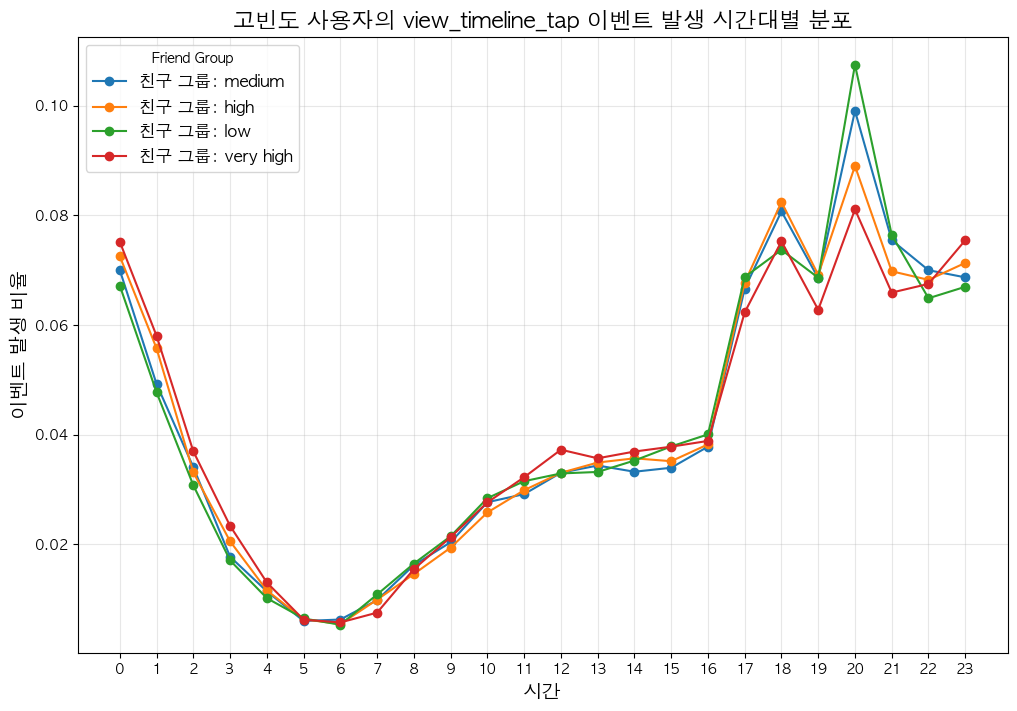

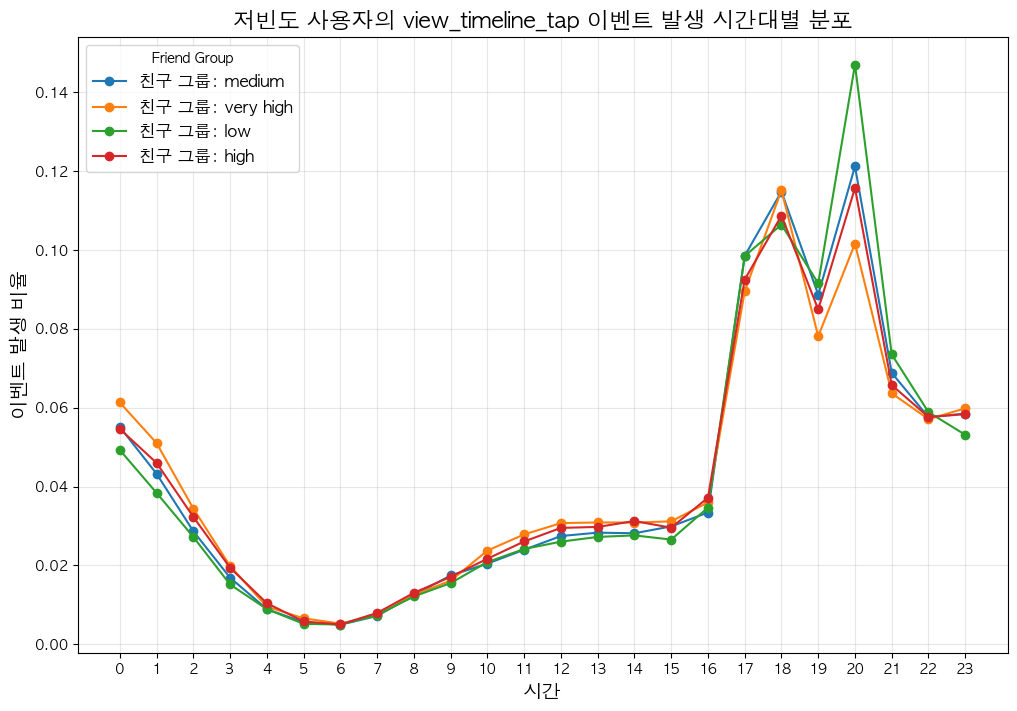

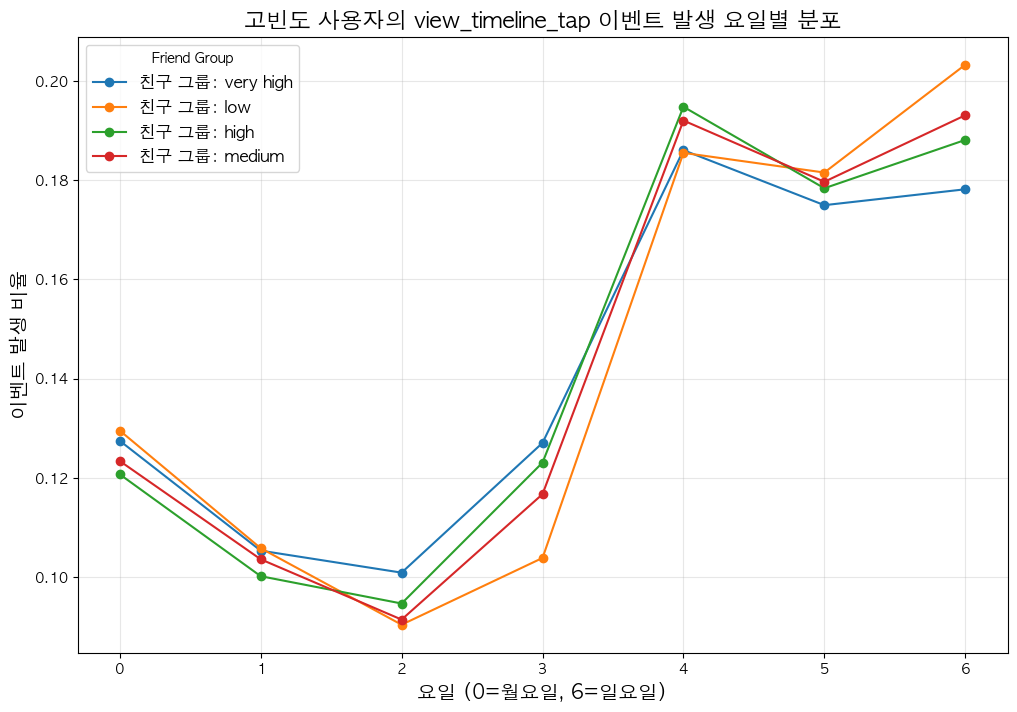

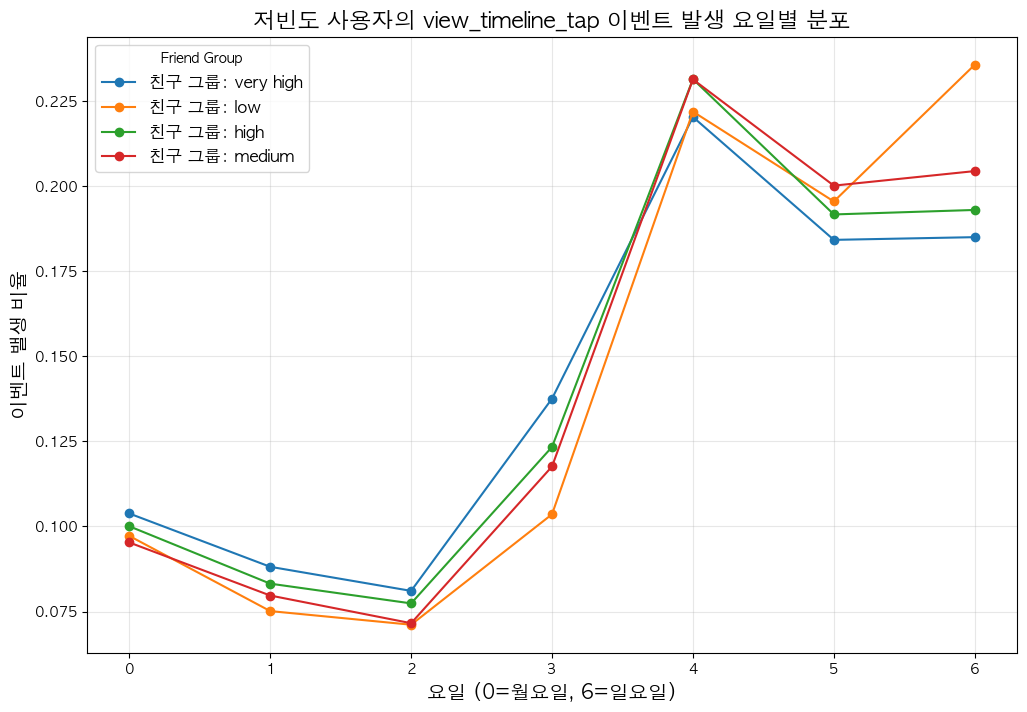

In [ ]:
# 시간대 및 요일 분포 시각화 함수 (수정)
def plot_distribution_sorted(distribution, x_labels, title, xlabel, ylabel):
    # 데이터프레임으로 변환 및 정렬
    dist_df = distribution.reset_index()
    dist_df.columns = ['friend_group', x_labels, 'proportion']
    dist_df = dist_df.sort_values(by=x_labels)  # x_labels 기준으로 정렬

    # 시각화
    plt.figure(figsize=(12, 8))
    for group in dist_df['friend_group'].unique():
        group_data = dist_df[dist_df['friend_group'] == group]
        plt.plot(
            group_data[x_labels],
            group_data['proportion'],
            marker='o',
            label=f"친구 그룹: {group}"
        )

    # 그래프 설정
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(sorted(dist_df[x_labels].unique()))  # 정렬된 x축 값 설정
    plt.grid(True, alpha=0.3)
    plt.legend(title="Friend Group", fontsize=12)
    plt.show()

# 시간대 분포 시각화 (고빈도 사용자)
plot_distribution_sorted(hour_dist_high, 'hour',
                         "고빈도 사용자의 view_timeline_tap 이벤트 발생 시간대별 분포",
                         "시간", "이벤트 발생 비율")

# 시간대 분포 시각화 (저빈도 사용자)
plot_distribution_sorted(hour_dist_low, 'hour',
                         "저빈도 사용자의 view_timeline_tap 이벤트 발생 시간대별 분포",
                         "시간", "이벤트 발생 비율")

# 요일 분포 시각화 (고빈도 사용자)
plot_distribution_sorted(weekday_dist_high, 'weekday',
                         "고빈도 사용자의 view_timeline_tap 이벤트 발생 요일별 분포",
                         "요일 (0=월요일, 6=일요일)", "이벤트 발생 비율")

# 요일 분포 시각화 (저빈도 사용자)
plot_distribution_sorted(weekday_dist_low, 'weekday',
                         "저빈도 사용자의 view_timeline_tap 이벤트 발생 요일별 분포",
                         "요일 (0=월요일, 6=일요일)", "이벤트 밸생 비율")


#### 3)click_bottom_navigation_questions → view_question_tap → click_question_start → complete_question

In [ ]:
#필요한 데이터 로드
h_evt_userid = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/가공 데이터/h_evt_userid.csv')

1. 전체기간 분석

In [ ]:
# 'click_bottom_navigation_questions' 이벤트가 발생한 횟수
navigation_evt_count = h_evt_userid[h_evt_userid['event_key'] == 'click_bottom_navigation_questions'].shape[0]

#'view_questions_tap' 이벤트가 발생한 횟수
view_questions_tap_event_count = h_evt_userid[h_evt_userid['event_key'] == 'view_questions_tap'].shape[0]

#'complete_question' 이벤트가 발생한 횟수
complete_question_event_count = h_evt_userid[h_evt_userid['event_key'] == 'complete_question'].shape[0]

In [ ]:
# click_bottom_navigation_questions에서 'view_questions_tap'으로 가는 전환율
print(view_questions_tap_event_count/navigation_evt_count * 100,'%')

#'view_questions_tap'에서 'complete_question'으로 가는 전환율
print(complete_question_event_count/view_questions_tap_event_count * 100,'%')

# 총 전환율
print(complete_question_event_count/navigation_evt_count * 100,'%')


46.007447005820026 %
46.393880555505945 %
21.34464001051784 %


2. 일별 분석

In [ ]:
# navigation_evt 의 일별 이벤트 발생량 count
navigation_evt = h_evt_userid[h_evt_userid['event_key'] == 'click_bottom_navigation_questions']

#datetime으로 데이터 타입 변경
navigation_evt['event_datetime'] = pd.to_datetime(navigation_evt['event_datetime'])

#월-일 컬럼 형성
navigation_evt['month_day'] = navigation_evt['event_datetime'].dt.strftime('%m-%d')

#월-일별로 이벤트 발생 횟수 카운트
navigation_evt_count = navigation_evt.groupby('month_day').size().reset_index(name = 'navigation_evt_count')

# view_questions_tap 의 일별 이벤트 발생량 count
view_questions_tap_evt = h_evt_userid[h_evt_userid['event_key'] == 'view_questions_tap']

#datetime으로 데이터 타입 변경
view_questions_tap_evt ['event_datetime'] = pd.to_datetime(view_questions_tap_evt ['event_datetime'])

#월-일 컬럼 형성
view_questions_tap_evt ['month_day'] = view_questions_tap_evt ['event_datetime'].dt.strftime('%m-%d')

#월-일별로 이벤트 발생 횟수 카운트
view_questions_tap_evt_count = view_questions_tap_evt .groupby('month_day').size().reset_index(name = 'view_questions_tap_count')

# complete_question 의 일별 이벤트 발생량 count
complete_question_evt = h_evt_userid[h_evt_userid['event_key'] == 'complete_question']

#datetime으로 데이터 타입 변경
complete_question_evt ['event_datetime'] = pd.to_datetime(complete_question_evt ['event_datetime'])

#월-일 컬럼 형성
complete_question_evt ['month_day'] = complete_question_evt ['event_datetime'].dt.strftime('%m-%d')

#월-일별로 이벤트 발생 횟수 카운트
complete_question_evt_count = complete_question_evt .groupby('month_day').size().reset_index(name = 'complete_question_evt_count')

#월-일별로 이벤트 발생 횟수 카운트
complete_question_evt_count = complete_question_evt .groupby('month_day').size().reset_index(name = 'complete_question_evt_count')

# complete_question 의 일별 이벤트 발생량 count
click_question_start_evt = h_evt_userid[h_evt_userid['event_key'] == 'click_question_start']

#datetime으로 데이터 타입 변경
click_question_start_evt['event_datetime'] = pd.to_datetime(click_question_start_evt['event_datetime'])

#월-일 컬럼 형성
click_question_start_evt['month_day'] = click_question_start_evt['event_datetime'].dt.strftime('%m-%d')

#월-일별로 이벤트 발생 횟수 카운트
click_question_start_evt_count = click_question_start_evt .groupby('month_day').size().reset_index(name = 'click_question_start_evt_count')

#전체 데이터 합치기
all_df = pd.merge(navigation_evt_count, view_questions_tap_evt_count, on = 'month_day', how = 'outer')
all_df = pd.merge(all_df,complete_question_evt_count, on = 'month_day', how = 'outer' )
all_df = pd.merge(all_df,click_question_start_evt_count, on = 'month_day', how = 'outer' )

# view_questions_tap_count 7월 18일부터 7월 23일 기록 없음 .. 왜지?? -> 0으로 채우기
all_df.fillna(0)

/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_956/2028574881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  navigation_evt['event_datetime'] = pd.to_datetime(navigation_evt['event_datetime'])
/var/folders/3q/sq957cvn6rb5jzklz3m3vkbr0000gn/T/ipykernel_956/2028574881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  navigation_evt['month_day'] = navigation_evt['event_datetime'].dt.strftime('%m-%d')


In [ ]:
#전환율 계산
# 전환율 계산 (분모가 0인 경우 0으로 설정)
all_df['conversion_rate_1'] = all_df.apply(
    lambda row: row['view_questions_tap_count'] / row['navigation_evt_count']
    if row['navigation_evt_count'] != 0 else 0,
    axis=1
)

all_df['conversion_rate_2'] = all_df.apply(
    lambda row: row['click_question_start_evt_count'] / row['view_questions_tap_count']
    if row['view_questions_tap_count'] != 0 else 0,
    axis=1
)

all_df['conversion_rate_3'] = all_df.apply(
    lambda row: row['complete_question_evt_count'] / row['click_question_start_evt_count']
    if row['view_questions_tap_count'] != 0 else 0,
    axis=1
)

In [ ]:
all_df

,index,month_day,navigation_evt_count,view_questions_tap_count,complete_question_evt_count,conversion_rate_1,conversion_rate_2,click_question_start_evt_count,conversion_rate_3
0,0,07-18,56321,NaN,11373,NaN,NaN,15776,0.720905
1,1,07-19,37859,NaN,10401,NaN,NaN,14133,0.735937
2,2,07-20,63516,NaN,12178,NaN,NaN,17126,0.711083
3,3,07-21,64597,NaN,12219,NaN,NaN,17331,0.705037
4,4,07-22,33699,NaN,9287,NaN,NaN,12315,0.754121
5,5,07-23,53634,NaN,10732,NaN,NaN,14942,0.718244
6,6,07-24,29908,201.0,8404,0.006721,56.955224,11448,0.734102
7,7,07-25,26039,10007.0,7792,0.384308,1.058559,10593,0.735580
8,8,07-26,23476,19030.0,7064,0.810615,0.509721,9700,0.728247
9,9,07-27,45561,34693.0,8134,0.761463,0.343931,11932,0.681696


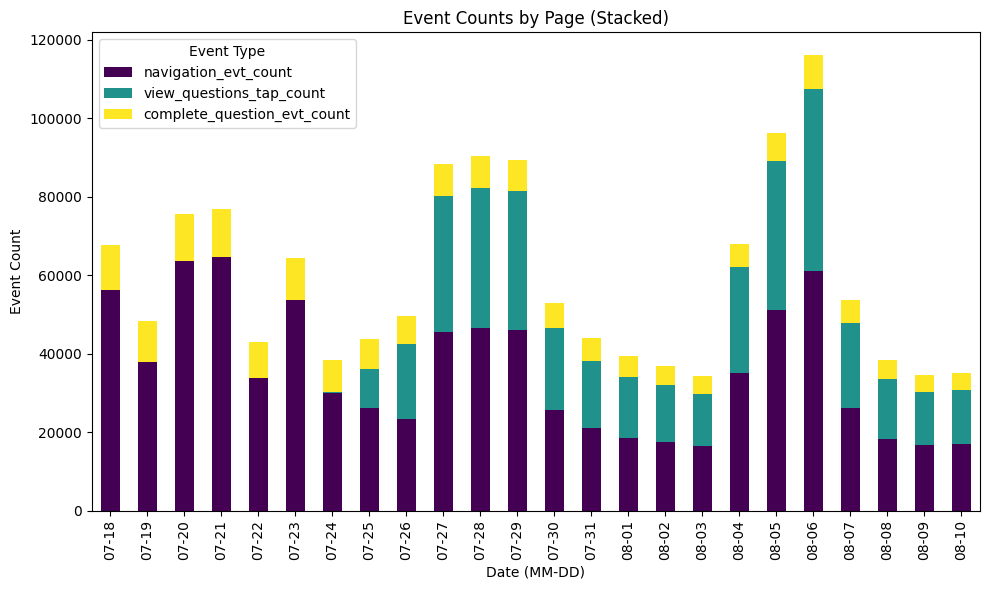

In [ ]:
# 데이터 준비
all_df.set_index('month_day', inplace=True)

# 페이지별 이벤트 데이터 선택
event_columns = ['navigation_evt_count', 'view_questions_tap_count', 'complete_question_evt_count']

# 누적 막대 그래프 생성
all_df[event_columns].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# 그래프 꾸미기
plt.title('Event Counts by Page (Stacked)')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Event Count')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()


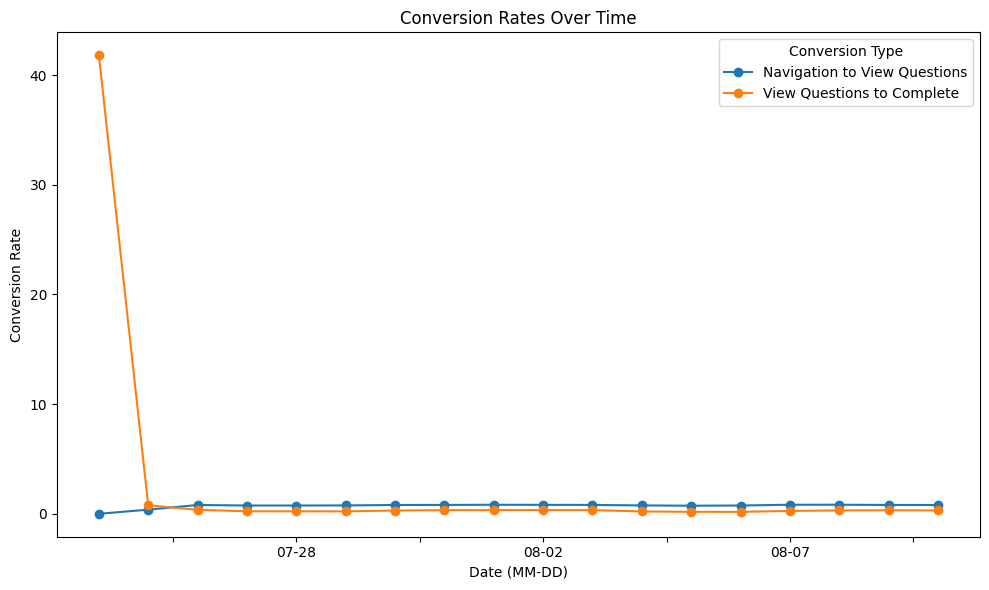

In [ ]:
# 전환율 라인 그래프
conversion_columns = ['conversion_rate_1', 'conversion_rate_2']

all_df[conversion_columns].plot(kind='line', figsize=(10, 6), marker='o')

# 그래프 꾸미기
plt.title('Conversion Rates Over Time')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Conversion Rate')
plt.legend(['Navigation to View Questions', 'View Questions to Complete'], title='Conversion Type')
plt.tight_layout()
plt.show()


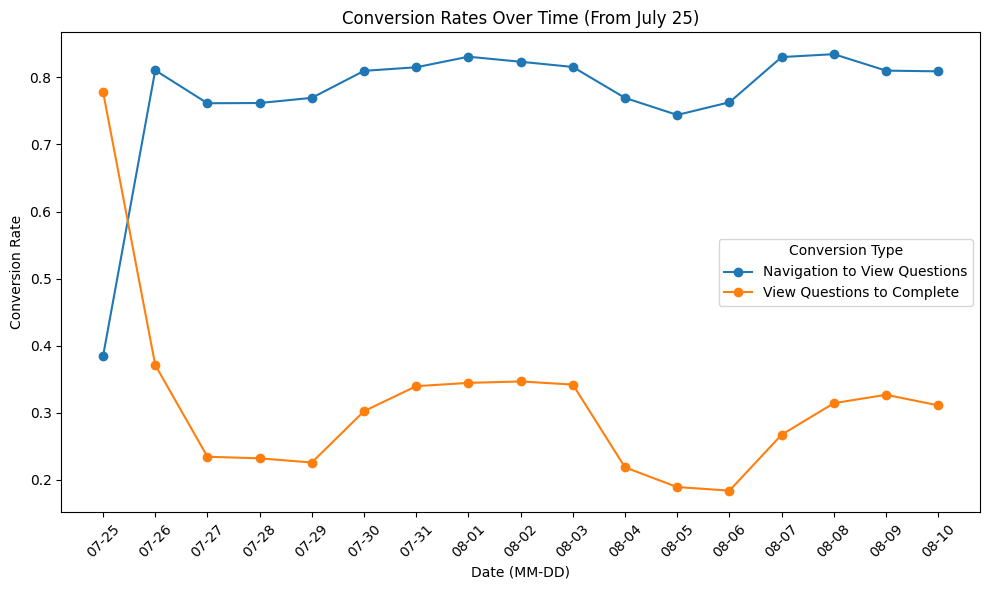

In [ ]:
# 페이지 전환율 (7월 25일 이후)
# 'month_day'가 07-25 이상인 데이터만 필터링
filtered_df = all_df[all_df['month_day'] >= '07-25']

# 전환율 라인 그래프
conversion_columns = ['conversion_rate_1', 'conversion_rate_2']

# 7월 25일부터 필터링된 데이터에 대해 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['month_day'], filtered_df['conversion_rate_1'], marker='o', label='Navigation to View Questions')
plt.plot(filtered_df['month_day'], filtered_df['conversion_rate_2'], marker='o', label='View Questions to Complete')

# X축에 'month_day' 값을 레이블로 설정
plt.xticks(rotation=45)

# 그래프 꾸미기
plt.title('Conversion Rates Over Time (From July 25)')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Conversion Rate')
plt.legend(title='Conversion Type')
plt.tight_layout()
plt.show()



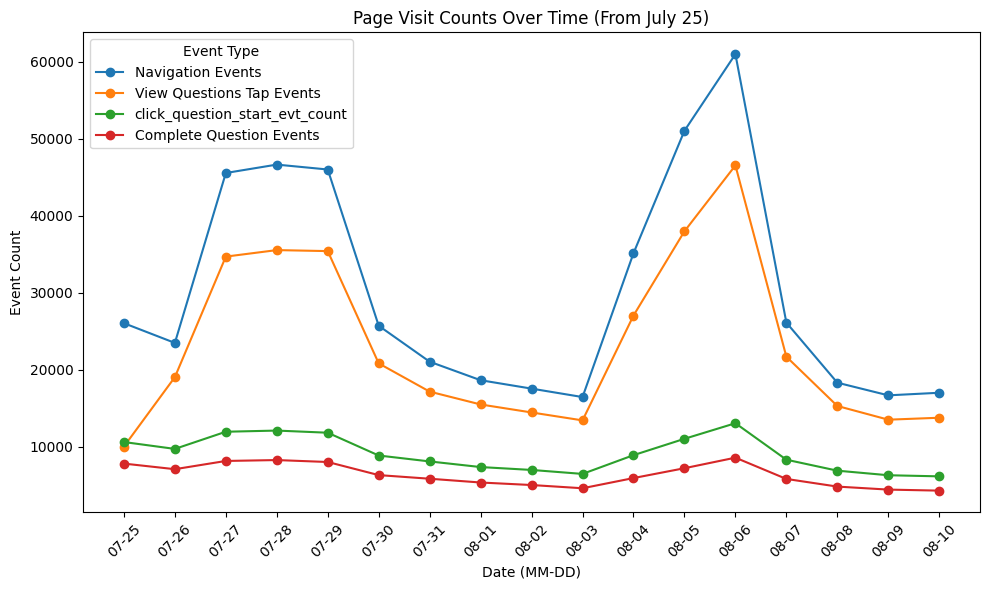

In [ ]:
# 이상한 날짜 제외 (7/25 이후) 페이지 접속 횟수
# 'month_day'가 07-25 이상인 데이터만 필터링
filtered_df = all_df[all_df['month_day'] >= '07-25']

# 페이지별 접속 수를 라인 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['month_day'], filtered_df['navigation_evt_count'], marker='o', label='Navigation Events')
plt.plot(filtered_df['month_day'], filtered_df['view_questions_tap_count'], marker='o', label='View Questions Tap Events')
plt.plot(filtered_df['month_day'], filtered_df['click_question_start_evt_count'], marker='o', label='click_question_start_evt_count')
plt.plot(filtered_df['month_day'], filtered_df['complete_question_evt_count'], marker='o', label='Complete Question Events')

# X축에 'month_day' 값을 레이블로 설정
plt.xticks(rotation=45)

# 그래프 꾸미기
plt.title('Page Visit Counts Over Time (From July 25)')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Event Count')
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()


3) 성별에 따른 분석

In [ ]:
user_df = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/가공 데이터/user_ml_df.csv')

#그룹 분리
male_df = user_df[user_df['gender'] == 'M']
female_df = user_df[user_df['gender'] == 'F']

#hackle_event에 성별 합치기
h_evt_userid_g = pd.merge(h_evt_userid, user_df[['user_id','gender']], on = 'user_id', how = 'inner')

#원하는 이벤트만 가져오기
gender_funnel = h_evt_userid_g[(h_evt_userid_g['event_key']=='click_bottom_navigation_questions')|(h_evt_userid_g['event_key']=='view_questions_tap')|(h_evt_userid_g['event_key']=='complete_question')]

#필요한 컬럼만 가져오기
g_funnel = gender_funnel[['user_id','event_datetime','event_key','gender']]

# 중복 제거: user_id별로 event_datetime이 가장 이른 행을 남김
g_funnel_unique = g_funnel.sort_values('event_datetime').drop_duplicates(subset='user_id', keep='first')

# g_funnel 데이터프레임을 event_key와 gender로 그룹화하여 행수(count)를 계산
grouped_df = g_funnel_unique.groupby(['event_key', 'gender']).size().reset_index(name='count')

#순서 변경
grouped_df = grouped_df.sort_values('gender')

# 이벤트 순서를 위한 정렬 우선순위 지정
event_order = ['click_bottom_navigation_questions', 'view_questions_tap', 'complete_question']

# 데이터프레임 정렬
sorted_df = grouped_df.sort_values(by=['gender', 'event_key'], key=lambda col: col.map(
    {event: i for i, event in enumerate(event_order)}
))

sorted_df = sorted_df.sort_values('gender')

pivot_df = sorted_df.pivot(index='gender', columns='event_key', values='count')

# 전환율 계산
pivot_df['view_questions_tap_rate'] = pivot_df['view_questions_tap'] / pivot_df['click_bottom_navigation_questions']
pivot_df['complete_question_rate'] = pivot_df['complete_question'] / pivot_df['click_bottom_navigation_questions']

# 'click_bottom_navigation_questions' 전환율을 1.0으로 설정
pivot_df['click_bottom_navigation_questions_rate'] = 1.0

# 피벗된 데이터에서 전환율 데이터를 병합하기 위해 melt
melted_df = pivot_df[['click_bottom_navigation_questions_rate',
                      'view_questions_tap_rate',
                      'complete_question_rate']].reset_index().melt(
                          id_vars='gender',
                          var_name='event_key',
                          value_name='conversion_rate')

# 'event_key' 이름 정리
melted_df['event_key'] = melted_df['event_key'].str.replace('_rate', '')

# 원래 데이터에 전환율 합치기
sorted_df = sorted_df.merge(melted_df, how='left', on=['gender', 'event_key'])

#전환율 * 100
sorted_df['conversion_rate'] = sorted_df['conversion_rate']*100

In [ ]:
sorted_df

,event_key,gender,count,conversion_rate
0,click_bottom_navigation_questions,F,75529,100.000000
1,view_questions_tap,F,14107,18.677594
2,complete_question,F,8467,11.210264
3,click_bottom_navigation_questions,M,58029,100.000000
4,view_questions_tap,M,11729,20.212308
5,complete_question,M,6435,11.089283


4) 중고등학생에 따른 분석

In [ ]:
#hackle_event에 학교타입 합치기
h_evt_userid_st = pd.merge(h_evt_userid, user_df[['user_id','school_type']], on = 'user_id', how = 'inner')

#원하는 이벤트만 가져오기
school_type_funnel = h_evt_userid_st[(h_evt_userid_st['event_key']=='click_bottom_navigation_questions')|(h_evt_userid_g['event_key']=='view_questions_tap')|(h_evt_userid_g['event_key']=='complete_question')]

#필요한 컬럼만 가져오기
school_type_funnel = school_type_funnel[['user_id','event_datetime','event_key','school_type']]

# 중복 제거: user_id별로 event_datetime이 가장 이른 행을 남김
school_funnel_unique = school_type_funnel.sort_values('event_datetime').drop_duplicates(subset='user_id', keep='first')

# school_funnel 데이터프레임을 event_key와 gender로 그룹화하여 행수(count)를 계산
grouped_df_sch = school_funnel_unique.groupby(['event_key', 'school_type']).size().reset_index(name='count')

#순서 변경
grouped_df_sch = grouped_df_sch.sort_values('school_type')

# 이벤트 순서를 위한 정렬 우선순위 지정
event_order = ['click_bottom_navigation_questions', 'view_questions_tap', 'complete_question']

# 데이터프레임 정렬
sorted_df_sch = grouped_df_sch.sort_values(by=['school_type', 'event_key'], key=lambda col: col.map(
    {event: i for i, event in enumerate(event_order)}
))


sorted_df_sch = sorted_df_sch.sort_values('school_type')

pivot_df_sch = sorted_df_sch.pivot(index='school_type', columns='event_key', values='count')

# 전환율 계산
pivot_df_sch['view_questions_tap_rate'] = pivot_df_sch['view_questions_tap'] / pivot_df_sch['click_bottom_navigation_questions']
pivot_df_sch['complete_question_rate'] = pivot_df_sch['complete_question'] / pivot_df_sch['click_bottom_navigation_questions']

# 'click_bottom_navigation_questions' 전환율을 1.0으로 설정
pivot_df_sch['click_bottom_navigation_questions_rate'] = 1.0

# 피벗된 데이터에서 전환율 데이터를 병합하기 위해 melt
melted_df_sch = pivot_df_sch[['click_bottom_navigation_questions_rate',
                      'view_questions_tap_rate',
                      'complete_question_rate']].reset_index().melt(
                          id_vars='school_type',
                          var_name='event_key',
                          value_name='conversion_rate')

# 'event_key' 이름 정리
melted_df_sch['event_key'] = melted_df_sch['event_key'].str.replace('_rate', '')

# 원래 데이터에 전환율 합치기
sorted_df_sch = sorted_df_sch.merge(melted_df_sch, how='left', on=['school_type', 'event_key'])

#전환율 * 100
sorted_df_sch['conversion_rate'] = sorted_df_sch['conversion_rate']*100

In [ ]:
sorted_df_sch

,event_key,school_type,count,conversion_rate
0,click_bottom_navigation_questions,0.0,66879,100.000000
1,view_questions_tap,0.0,11720,17.524185
2,complete_question,0.0,10186,15.230491
3,click_bottom_navigation_questions,1.0,66679,100.000000
4,view_questions_tap,1.0,14116,21.170084
5,complete_question,1.0,4716,7.072692


5.친구수에 따른 분석

In [ ]:
#친구수 그룹화
#숫자가 높을수록 친구가 많음
user_df['friend_qcut'] =  pd.qcut(user_df['friend_count'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])

h_evt_userid_fc = pd.merge(h_evt_userid, user_df[['user_id','friend_qcut']], on = 'user_id', how = 'inner')

#원하는 이벤트만 가져오기
friend_funnel = h_evt_userid_fc[(h_evt_userid_st['event_key']=='click_bottom_navigation_questions')|(h_evt_userid_g['event_key']=='view_questions_tap')|(h_evt_userid_g['event_key']=='complete_question')]

#필요한 컬럼만 가져오기
friend_funnel = friend_funnel[['user_id','event_datetime','event_key','friend_qcut']]

# 중복 제거: user_id별로 event_datetime이 가장 이른 행을 남김
friend_funnel_unique = friend_funnel.sort_values('event_datetime').drop_duplicates(subset='user_id', keep='first')

# g_funnel 데이터프레임을 event_key와 friend_qcut로 그룹화하여 행수(count)를 계산
grouped_df_fri = friend_funnel_unique.groupby(['event_key', 'friend_qcut']).size().reset_index(name='count')

#순서 변경
grouped_df_fri = grouped_df_fri.sort_values('friend_qcut')

# 이벤트 순서를 위한 정렬 우선순위 지정
event_order = ['click_bottom_navigation_questions', 'view_questions_tap', 'complete_question']

# 데이터프레임 정렬
sorted_df_fri = grouped_df_fri.sort_values(by=['friend_qcut', 'event_key'], key=lambda col: col.map(
    {event: i for i, event in enumerate(event_order)}
))

sorted_df_fri = sorted_df_fri.sort_values('friend_qcut')

pivot_df_fri = sorted_df_fri.pivot(index='friend_qcut', columns='event_key', values='count')

# 전환율 계산
pivot_df_fri['view_questions_tap_rate'] = pivot_df_fri['view_questions_tap'] / pivot_df_fri['click_bottom_navigation_questions']
pivot_df_fri['complete_question_rate'] = pivot_df_fri['complete_question'] / pivot_df_fri['click_bottom_navigation_questions']

# 'click_bottom_navigation_questions' 전환율을 1.0으로 설정
pivot_df_fri['click_bottom_navigation_questions_rate'] = 1.0

# 피벗된 데이터에서 전환율 데이터를 병합하기 위해 melt
melted_df_fri = pivot_df_fri[['click_bottom_navigation_questions_rate',
                      'view_questions_tap_rate',
                      'complete_question_rate']].reset_index().melt(
                          id_vars='friend_qcut',
                          var_name='event_key',
                          value_name='conversion_rate')

# 'event_key' 이름 정리
melted_df_fri['event_key'] = melted_df_fri['event_key'].str.replace('_rate', '')

# 원래 데이터에 전환율 합치기
sorted_df_fri = sorted_df_fri.merge(melted_df_fri, how='left', on=['friend_qcut', 'event_key'])

#전환율 * 100
sorted_df_fri['conversion_rate'] = sorted_df_fri['conversion_rate']*100

In [ ]:
sorted_df_fri

,event_key,friend_qcut,count,conversion_rate
0,click_bottom_navigation_questions,1,34139,100.000000
1,view_questions_tap,1,7455,21.837195
2,complete_question,1,4335,12.698087
3,click_bottom_navigation_questions,2,34480,100.000000
4,view_questions_tap,2,6494,18.834107
5,complete_question,2,3571,10.356729
6,click_bottom_navigation_questions,3,33003,100.000000
7,view_questions_tap,3,6019,18.237736
8,complete_question,3,3403,10.311184
9,click_bottom_navigation_questions,4,31936,100.000000
